* SJSU ID - 010816832
* VIDYA COIMBATORE NAND KUMAR
* Alternus Vera Assignment

## **Analyse Influence of several factors on Fake news (Alternus Vera)

* The aim of the project is to develop a strategy to help identify fake news from real news and understand the influence of Controversy and other factors. 
* The subject of fake news became popular in connection with the recent US presidential elections and with possible Russian meddling into elections in the US, France, and Germany. 
* The project uses LIAR - LIAR dataset.


We identified several factors that could contribute to fake news detection, by analysing the dataset.
Key factors identified are:
* Political affiliation
* Sensationalism
* Controversy Analysis
* Topic features 
* Post/Social media activities based: People express their emotions or opinions towards fake news through social media posts.
* Visual based: Fake news detection based on images and video links features in the dataset.
* Linguistic based: Fake news detection based on Sensationalism and writing style (features: Article title and text)
* Reliable source: Fake news detection based on the source of the article.
* Sentiment Analysis
* Authenticity: Fake news includes false information that can be verified as such.

## ** Feature - Controversy 
#### Analyse Influence of Controversy on Fake news dataset (Alternus Vera)


Controversial content can be defined as any contentious matter or argument that may spark public debate. The approach is motivated by several factors. First, news is a significant part of our everyday lives. It shapes our beliefs and opinions on how we see the world and now more than ever people rely on a variety of online resources for their news. 

Therefore, the aim is to identify the potential of using single keywords to detect controversial content or topics that will influence fake news.

Distillation
* LDA, LSA, TF-Idf, Doc2vec gensim models and sentiment analysis methods have been used for distillation.

Scoring Component: To detect the posts that cast controversy on the article and score the controversy level.
* Ranking Component: Ranked the articles based on the controversy scores of each statement.



In [248]:
import os
import pickle
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from collections import Counter
import nltk
from nltk.tokenize import RegexpTokenizer
import re
import nltk
from nltk.stem import SnowballStemmer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree

from sklearn.metrics import confusion_matrix,classification_report
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import tree
from sklearn.datasets import load_wine
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
from graphviz import Digraph
from collections import OrderedDict
import seaborn as sns
sns.set_style("darkgrid")

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)
import nltk
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
path_train='train.tsv'
path_test='test.tsv'
path_valid='valid.tsv'
path_controversy_vocab = 'controversy_vocabulary.csv'




## Loading Training, Test and Validation data

In [249]:
train_data = pd.read_csv(path_train, sep='\t', header = None)
test_data = pd.read_csv(path_test, sep='\t', header = None)
valid_data = pd.read_csv(path_valid, sep='\t', header = None)

contro_vocab_data = pd.read_csv(path_controversy_vocab)
contro_vocab_data.head()
columns = ['id', 'label', 'statement', 'subjects', 'speaker',
         'speaker_job', 'state', 'party', 'barely_true_counts',
         'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts',
         'context']
train_data.columns = columns
test_data.columns = columns
valid_data.columns = columns


#### Adding text length to training set

In [250]:
train_data['text-length'] = train_data['statement'].apply(len)
#train_data.head()

## Visualizing the dataset 

### Distribution of classes based on labels - Train ,Test and Validation datasets

In [251]:
train_data.subjects.unique()

array(['abortion', 'energy,history,job-accomplishments', 'foreign-policy',
       ..., 'animals,elections', 'retirement,social-security',
       'florida,foreign-policy'], dtype=object)

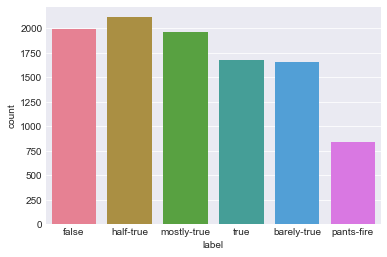

In [252]:
sb.countplot(x='label', data=train_data, palette='husl')

* Here, we see that the number of articles per class is roughly balanced, which is helpful!

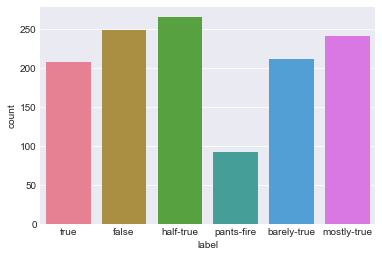

In [253]:
sb.countplot(x='label', data=test_data, palette='husl')

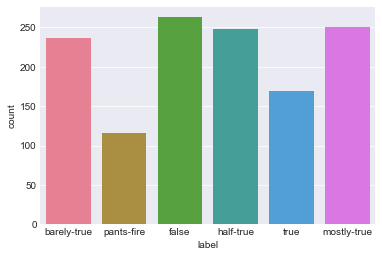

In [254]:
sb.countplot(x='label', data=valid_data, palette='husl')

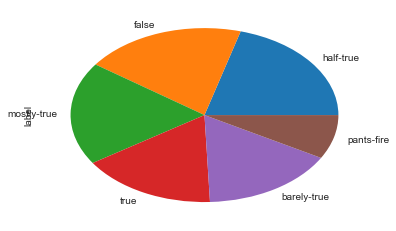

In [255]:
%matplotlib inline
train_data['label'].value_counts().plot(kind="pie")

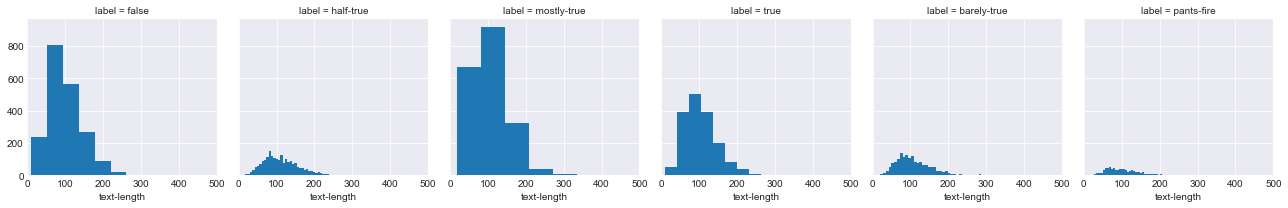

In [256]:
g = sns.FacetGrid(data=train_data, col='label')
for i, ax in enumerate(g.axes.flat): # set every-other axis for testing purposes
       ax.set_xlim(0,500)
g.map(plt.hist, 'text-length', bins=50)


* Seems like overall, the distribution of text length is similar across all labels. However, the number of text length seems to be skewed a lot higher for false and mostly-true labels. 

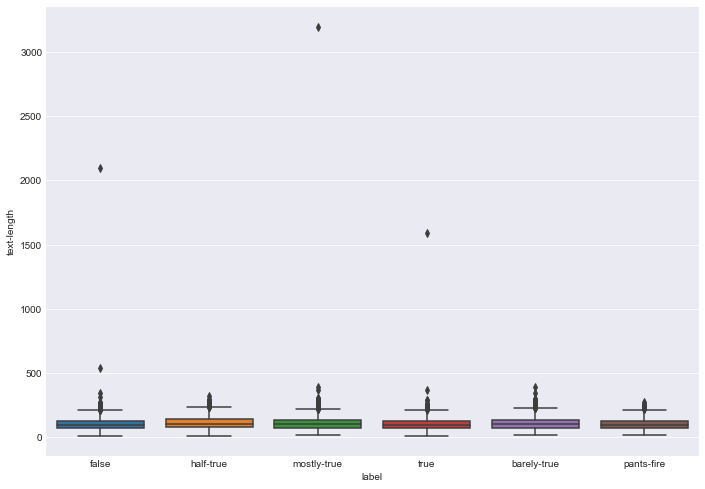

In [257]:
a4_dims = (11.7, 8.27)
f, ax = plt.subplots(figsize=a4_dims)
sns.set_style("whitegrid")
sns.boxplot(x='label', y='text-length', data=train_data)

#### From the plot I  inferred that 'false' 'mostly-true' and 'true' have much longer text, but there are many outliers too which can be seen as points above the boxes

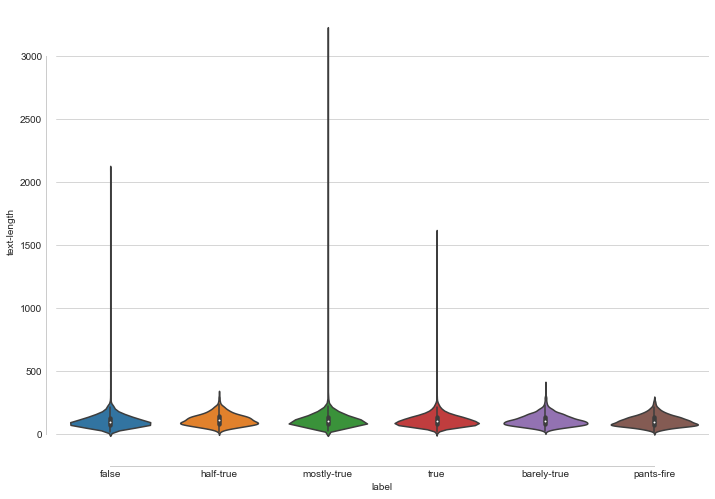

In [258]:
a4_dims = (11.7, 8.27)
f, ax = plt.subplots(figsize=a4_dims)
sns.violinplot(x='label', y='text-length', data=train_data)
sns.despine(offset=10, trim=True);

In [259]:
train_data.describe()

barely_true_counts  false_counts  half_true_counts  mostly_true_counts  \
count        10238.000000  10238.000000      10238.000000        10238.000000   
mean            11.533210     13.286482         17.133718           16.434265   
std             18.973764     24.112936         35.846511           36.151688   
min              0.000000      0.000000          0.000000            0.000000   
25%              0.000000      0.000000          0.000000            0.000000   
50%              2.000000      2.000000          3.000000            3.000000   
75%             12.000000     12.000000         13.000000           11.000000   
max             70.000000    114.000000        160.000000          163.000000   

       pants_on_fire_counts   text-length  
count          10238.000000  10240.000000  
mean               6.201407    106.918750  
std               16.128927     59.917722  
min                0.000000     11.000000  
25%                0.000000     73.000000  
50%                1.000000     99.000000  
75%                5.000000    132.250000  
max              105.000000   3192.000000

In [260]:
labels = train_data.groupby('label').mean()
labels.corr()

barely_true_counts  false_counts  half_true_counts  \
barely_true_counts              1.000000     -0.127664          0.305618   
false_counts                   -0.127664      1.000000         -0.823283   
half_true_counts                0.305618     -0.823283          1.000000   
mostly_true_counts              0.283077     -0.851132          0.983699   
pants_on_fire_counts           -0.348281      0.925060         -0.851951   
text-length                     0.520355     -0.731996          0.740105   

                      mostly_true_counts  pants_on_fire_counts  text-length  
barely_true_counts              0.283077             -0.348281     0.520355  
false_counts                   -0.851132              0.925060    -0.731996  
half_true_counts                0.983699             -0.851951     0.740105  
mostly_true_counts              1.000000             -0.875937     0.696002  
pants_on_fire_counts           -0.875937              1.000000    -0.645328  
text-length                     0.696002             -0.645328     1.000000

### Feature selection or attribute evaluator consists of identifying the relevant features and ignoring the irrelevant ones from a dataset. The use of attribute evaluator methods enhances the performance of machine learning algorithms. Visualizing Correlation heatmap helps in better correlation-based feature selection

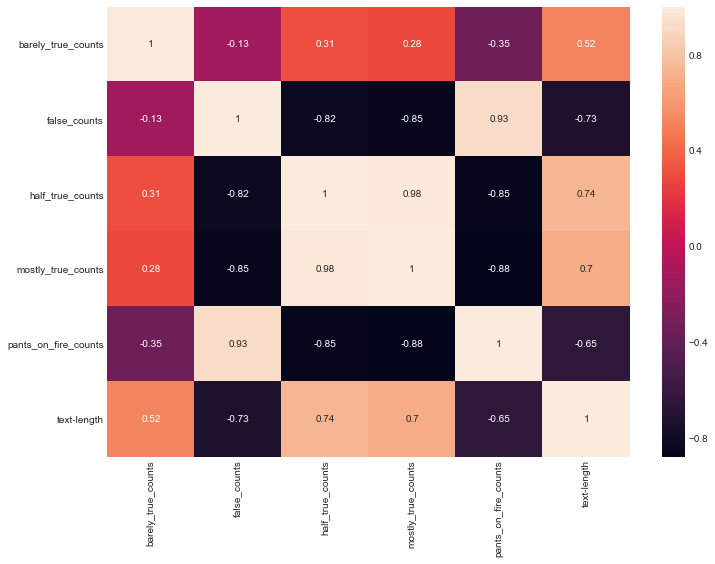

In [261]:
from matplotlib import pyplot
a4_dims = (11.7, 8.27)
fig, ax = pyplot.subplots(figsize=a4_dims)
sns.heatmap(ax=ax,data=labels.corr(), annot=True)


* Looking at the map, false is strongly correlated with pants_on_fire, and mostly_true seems strongly correlated with half_true. There is also a negative correlation between false_counts and the other features.

### Visualizing mostly used words corresponding to True, False, barely-true, mostly-true, half-true, pants-fire labels

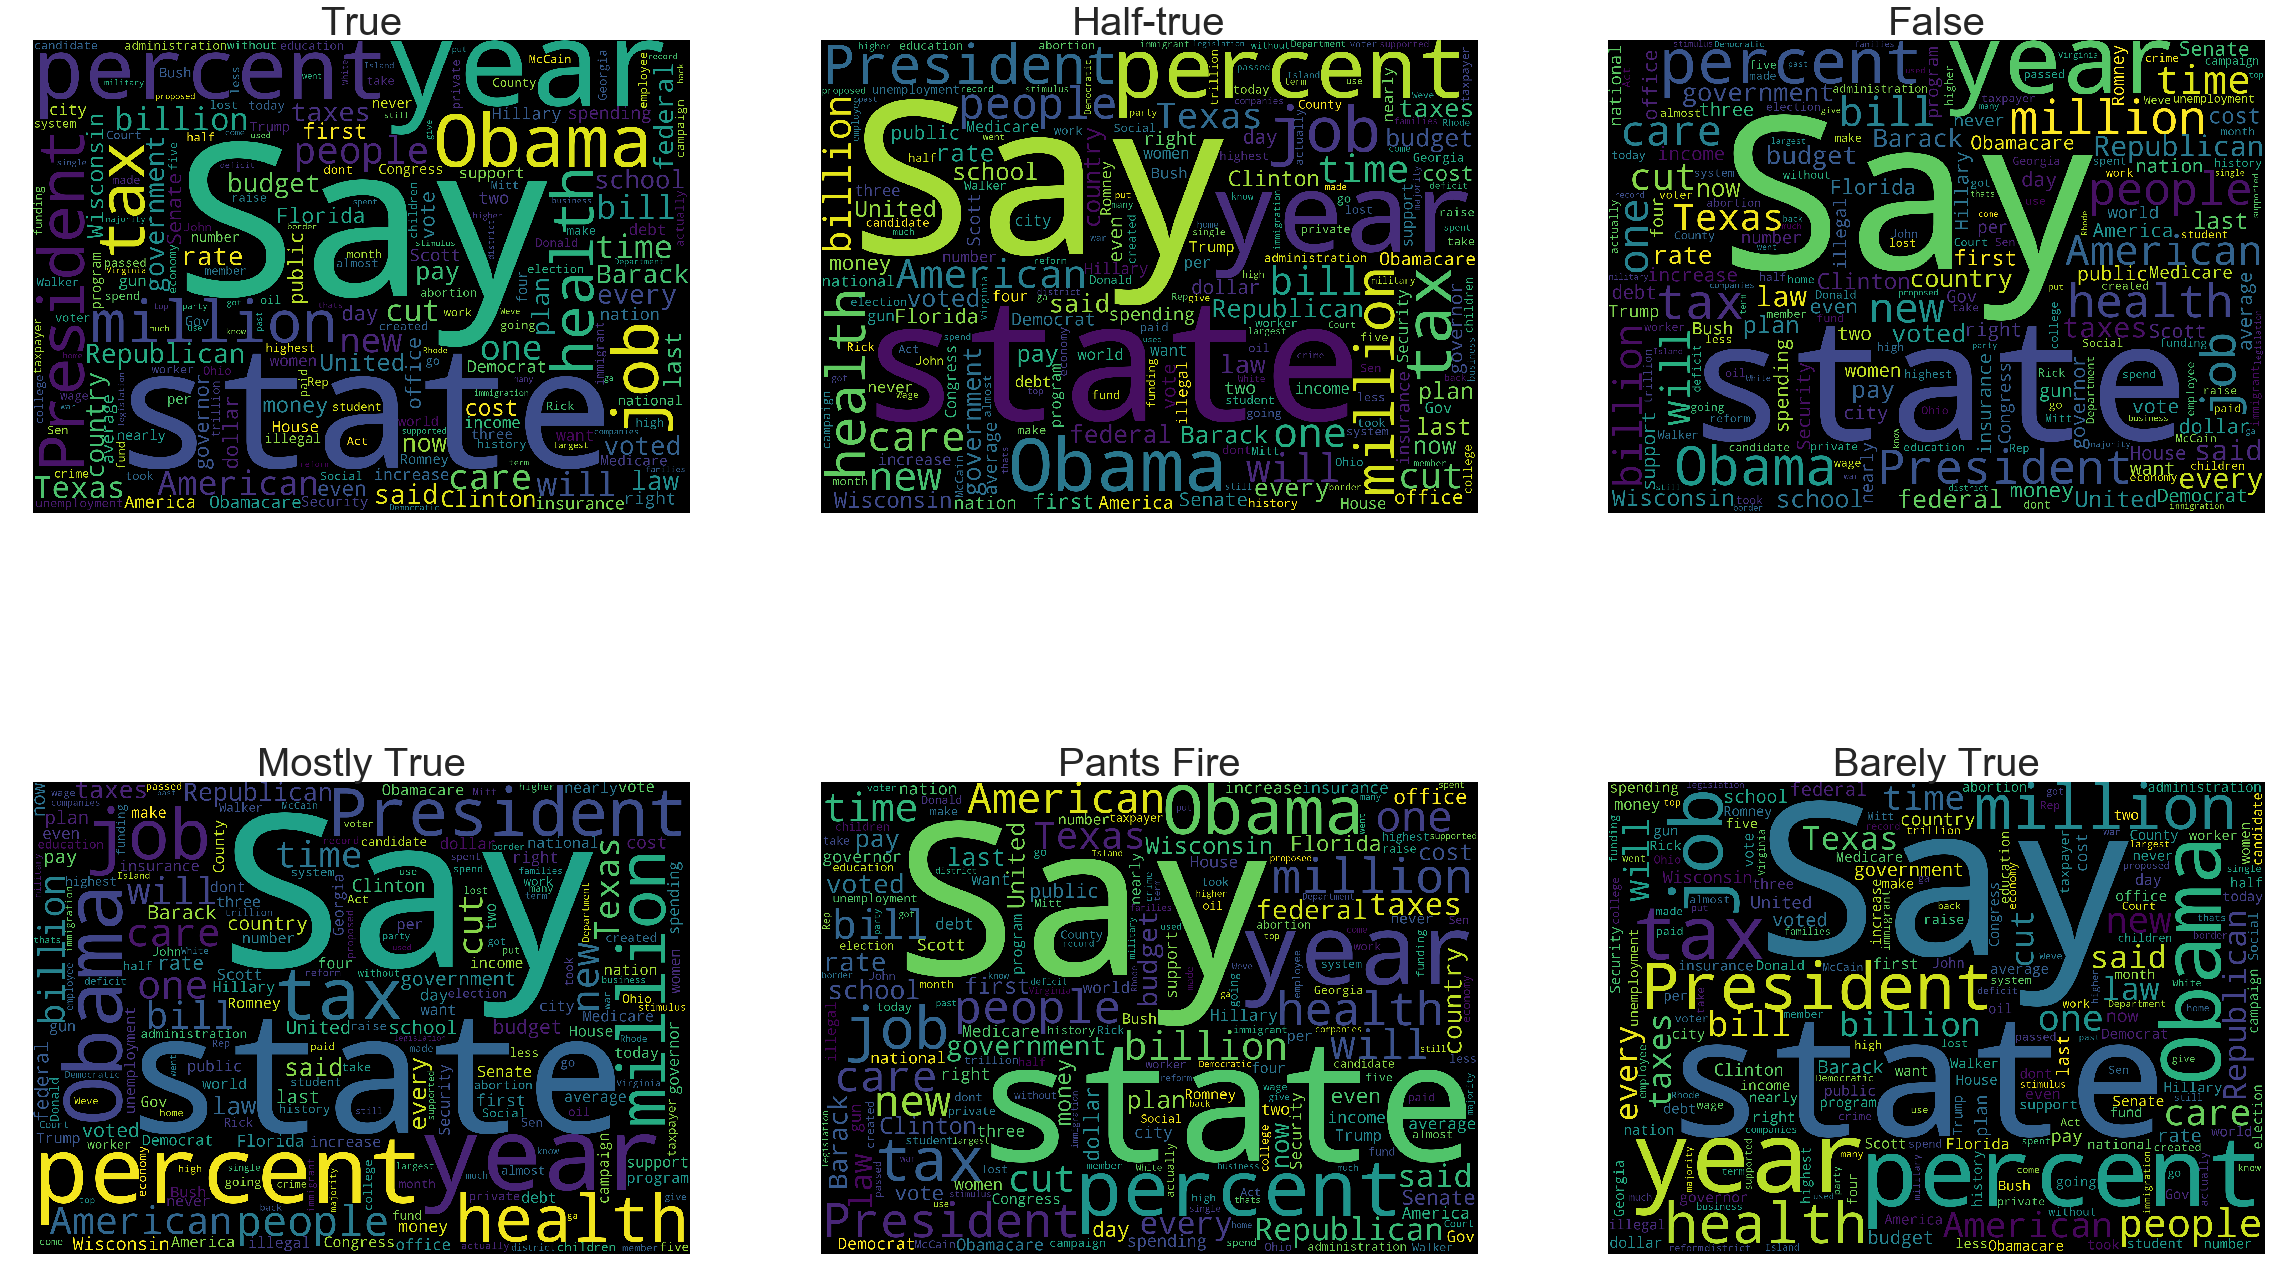

In [262]:
from wordcloud import WordCloud,STOPWORDS
plt.figure(figsize=(40,25))
# true
subset = train_data[train_data.label==True]
text = train_data['statement']
cloud_true = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          collocations=False,
                          width=2500,
                          height=1800
                         ).generate(" ".join(text))


plt.subplot(2, 3, 1)
plt.axis('off')
plt.title("True",fontsize=40)
plt.imshow(cloud_true)

# true
subset = train_data[train_data.label=='half-true']
text = train_data['statement']
cloud_half_true = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          collocations=False,
                          width=2500,
                          height=1800
                         ).generate(" ".join(text))

plt.subplot(2, 3, 2)
plt.axis('off')
plt.title("Half-true",fontsize=40)
plt.imshow(cloud_half_true)



# false
subset = train_data[train_data.label=='false']
text = train_data['statement']
cloud_false = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          collocations=False,
                          width=2500,
                          height=1800
                         ).generate(" ".join(text))

plt.subplot(2, 3, 3)
plt.axis('off')
plt.title("False",fontsize=40)
plt.imshow(cloud_false)



# mostly-true
subset = train_data[train_data.label=='mostly-true']
text = train_data['statement']
cloud_mostly_true = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          collocations=False,
                          width=2500,
                          height=1800
                         ).generate(" ".join(text))

plt.subplot(2, 3, 4)
plt.axis('off')
plt.title("Mostly True",fontsize=40)
plt.imshow(cloud_mostly_true)

#pants-fire
subset = train_data[train_data.label=='pants-fire']
text = train_data['statement']
cloud_pants_fire = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          collocations=False,
                          width=2500,
                          height=1800
                         ).generate(" ".join(text))

plt.subplot(2, 3, 5)
plt.axis('off')
plt.title("Pants Fire",fontsize=40)
plt.imshow(cloud_pants_fire)


#barely-true
subset = train_data[train_data.label=='barely-true']
text = train_data['statement']
cloud_barely_true = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          collocations=False,
                          width=2500,
                          height=1800
                         ).generate(" ".join(text))

plt.subplot(2, 3, 6)
plt.axis('off')
plt.title("Barely True",fontsize=40)
plt.imshow(cloud_barely_true)

### An important set of metrics in text mining relates to the frequency of words or token in a certain corpus of text documents. 
* Following is the frequency distribution (list) of most frequently used words among the statements in traning data set

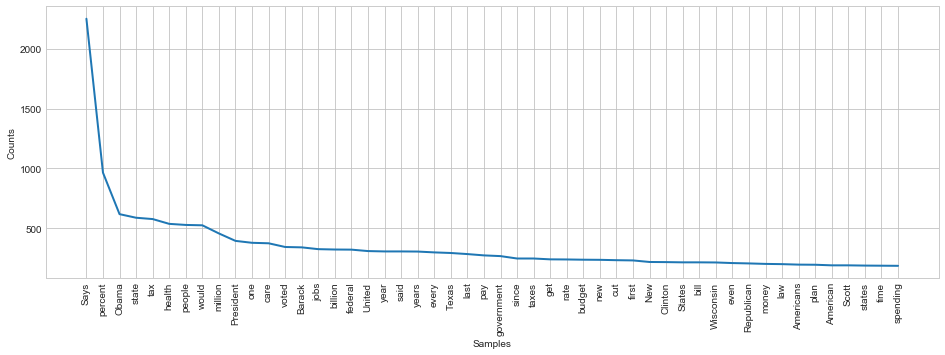

In [263]:
from collections import defaultdict
from nltk.corpus import stopwords
import pandas as pd

stop_words = stopwords.words('english')


word_list=[]
word_freq = defaultdict(int)

for text in train_data.statement:
    for word in text.split():
        if word.lower() not in stop_words and word.isalpha():
            word_list.append(word)
            word_freq[word] += 1

pd.DataFrame.from_dict(word_freq, orient='index') \
.sort_values(0, ascending=False) \
.rename(columns={0: 'abs_freq'})

freqdist = nltk.FreqDist(word_list)
plt.figure(figsize=(16,5))
freqdist.plot(50)


* The words 'Says','percent','Obama' are frequently used

## Forming Vocabulary of Controversial words

 * Using a four-point scale to classify 200 high-frequency terms analysed from 
   * https://wpcurve.com/words-that-trigger-emotional-responses/
   * https://www.scribd.com/doc/82701103/Analyst-Desktop-Binder-REDACTED
   * https://arxiv.org/pdf/1409.8152.pdf

Indicate based on threshold if sentence is -
* Strongly Controversial: 
* Somewhat Controversial:
* Less Controversial
* Non-Controversial: 

In [264]:
vocab_doc = ["abuse administration afghanistan aid america american army attack attacks authorities authority ban banks benefits bill border budget campaign candidate candidates catholic china chinese church concerns congress conservative control country court crime criminal crisis cuts debate debt defense deficit democrats disease dollar drug drugs economy education egypt election elections enforcement fighting finance fiscal force funding gas government gun health immigration inaccuracies india insurance investigation investigators iran israel job jobs judge justice killing korea labor land law lawmakers laws lawsuit leadership legislation marriage media mexico military money murder nation nations news obama offensive officials oil parties peace police policies policy politics poll power president prices primary prison progress race reform republican republicans restrictions rule rules ruling russia russian school security senate sex shooting society spending strategy strike support syria syrian tax taxes threat trial unemployment union usa victim violence vote voters war washington weapons world account advantage amount attorney chairman charge charges cities class comment companies cost credit delays effect expectations families family february germany goal housing information investment markets numbers oklahoma parents patients population price projects raise rate reason sales schools sector shot source sources status stock store whether worth"]

### To further analyze our dataset, we need to transform each article's text to a feature vector or word embedding


# Data pre-processing 
* Check for missing or null values
* Lowercase
* Tokenize
* Remove stop words, punctuations and special characters
* Stem


### Categorize label column

In [265]:
train_data['label_id'] = train_data['label'].factorize()[0]

In [266]:
train_data.isnull().sum()

id                         0
label                      0
statement                  0
subjects                   2
speaker                    2
speaker_job             2897
state                   2208
party                      2
barely_true_counts         2
false_counts               2
half_true_counts           2
mostly_true_counts         2
pants_on_fire_counts       2
context                  102
text-length                0
label_id                   0
dtype: int64

In [267]:
train_data.info()
    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10240 entries, 0 to 10239
Data columns (total 16 columns):
id                      10240 non-null object
label                   10240 non-null object
statement               10240 non-null object
subjects                10238 non-null object
speaker                 10238 non-null object
speaker_job             7343 non-null object
state                   8032 non-null object
party                   10238 non-null object
barely_true_counts      10238 non-null float64
false_counts            10238 non-null float64
half_true_counts        10238 non-null float64
mostly_true_counts      10238 non-null float64
pants_on_fire_counts    10238 non-null float64
context                 10138 non-null object
text-length             10240 non-null int64
label_id                10240 non-null int64
dtypes: float64(5), int64(2), object(9)
memory usage: 1.3+ MB


In [268]:
test_data.isnull().sum()

id                        0
label                     0
statement                 0
subjects                  0
speaker                   0
speaker_job             325
state                   262
party                     0
barely_true_counts        0
false_counts              0
half_true_counts          0
mostly_true_counts        0
pants_on_fire_counts      0
context                  17
dtype: int64

In [269]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1267 entries, 0 to 1266
Data columns (total 14 columns):
id                      1267 non-null object
label                   1267 non-null object
statement               1267 non-null object
subjects                1267 non-null object
speaker                 1267 non-null object
speaker_job             942 non-null object
state                   1005 non-null object
party                   1267 non-null object
barely_true_counts      1267 non-null int64
false_counts            1267 non-null int64
half_true_counts        1267 non-null int64
mostly_true_counts      1267 non-null int64
pants_on_fire_counts    1267 non-null int64
context                 1250 non-null object
dtypes: int64(5), object(9)
memory usage: 138.7+ KB


In [270]:
valid_data.isnull().sum()

id                        0
label                     0
statement                 0
subjects                  0
speaker                   0
speaker_job             345
state                   279
party                     0
barely_true_counts        0
false_counts              0
half_true_counts          0
mostly_true_counts        0
pants_on_fire_counts      0
context                  12
dtype: int64

In [271]:
valid_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1284 entries, 0 to 1283
Data columns (total 14 columns):
id                      1284 non-null object
label                   1284 non-null object
statement               1284 non-null object
subjects                1284 non-null object
speaker                 1284 non-null object
speaker_job             939 non-null object
state                   1005 non-null object
party                   1284 non-null object
barely_true_counts      1284 non-null int64
false_counts            1284 non-null int64
half_true_counts        1284 non-null int64
mostly_true_counts      1284 non-null int64
pants_on_fire_counts    1284 non-null int64
context                 1272 non-null object
dtypes: int64(5), object(9)
memory usage: 140.5+ KB


In [272]:
label_id_df = train_data[['label', 'label_id']].sort_values('label_id')
label_to_id = dict(label_id_df.values)
id_to_label = dict(label_id_df[['label_id', 'label']].values)

In [273]:
label_to_id

{'false': 0,
 'half-true': 1,
 'mostly-true': 2,
 'true': 3,
 'barely-true': 4,
 'pants-fire': 5}

## Remove unnecessary columns

In [274]:

train_data = train_data.drop(labels = ['party','subjects','speaker','speaker_job','state','context','barely_true_counts','false_counts','half_true_counts','mostly_true_counts','pants_on_fire_counts'], axis=1)

In [275]:
train_data.head()

id        label                                          statement  \
0   2635.json        false  Says the Annies List political group supports ...   
1  10540.json    half-true  When did the decline of coal start? It started...   
2    324.json  mostly-true  Hillary Clinton agrees with John McCain "by vo...   
3   1123.json        false  Health care reform legislation is likely to ma...   
4   9028.json    half-true  The economic turnaround started at the end of ...   

   text-length  label_id  
0           82         0  
1          141         1  
2          105         2  
3           78         0  
4           54         1

# Parts of speech tagging 
### Parts of speech tagging can be important for syntactic and semantic analysis, for each word in news can have several semantic meanings. 
### Identify Part of Speech Tags:
* Noun Count
* Verb Count
* Adjective Count
* Adverb Count
* Pronoun Count

In [276]:
pos_family = {
    'noun' : ['NN','NNS','NNP','NNPS'],
    'pron' : ['PRP','PRP$','WP','WP$'],
    'verb' : ['VB','VBD','VBG','VBN','VBP','VBZ'],
    'adj' :  ['JJ','JJR','JJS'],
    'adv' : ['RB','RBR','RBS','WRB']
}

# function to check and get the part of speech tag count of a words in a given sentence
def check_pos_tag(x, flag):
    cnt = 0
    try:
        wiki = textblob.TextBlob(x)
        for tup in wiki.tags:
            ppo = list(tup)[1]
            if ppo in pos_family[flag]:
                cnt += 1
    except:
        pass
    return cnt

# train_data['noun_count'] = train_data['statement'].apply(lambda x: check_pos_tag(x, 'noun'))
# train_data['verb_count'] = train_data['statement'].apply(lambda x: check_pos_tag(x, 'verb'))
# train_data['adj_count'] = train_data['statement'].apply(lambda x: check_pos_tag(x, 'adj'))
# train_data['adv_count'] = train_data['statement'].apply(lambda x: check_pos_tag(x, 'adv'))
# train_data['pron_count'] = train_data['statement'].apply(lambda x: check_pos_tag(x, 'pron'))

In [277]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag

In [278]:
ex = 'European authorities fined Google a record $5.1 billion on Wednesday for abusing its power in the mobile phone market and ordered the company to alter its practices'

In [279]:
def processtag(sent):
    sent = nltk.word_tokenize(sent)
    sent = nltk.pos_tag(sent)
    return sent

In [280]:
sent = processtag(ex)
sent

[('European', 'JJ'),
 ('authorities', 'NNS'),
 ('fined', 'VBD'),
 ('Google', 'NNP'),
 ('a', 'DT'),
 ('record', 'NN'),
 ('$', '$'),
 ('5.1', 'CD'),
 ('billion', 'CD'),
 ('on', 'IN'),
 ('Wednesday', 'NNP'),
 ('for', 'IN'),
 ('abusing', 'VBG'),
 ('its', 'PRP$'),
 ('power', 'NN'),
 ('in', 'IN'),
 ('the', 'DT'),
 ('mobile', 'JJ'),
 ('phone', 'NN'),
 ('market', 'NN'),
 ('and', 'CC'),
 ('ordered', 'VBD'),
 ('the', 'DT'),
 ('company', 'NN'),
 ('to', 'TO'),
 ('alter', 'VB'),
 ('its', 'PRP$'),
 ('practices', 'NNS')]

In [281]:
#modules for preprocessing the corpus by regular expressions
import re
import textacy
# module for preprocessing the corpus by parts of speach 
import spacy 
nlp = spacy.load('en')

### Parts of Speech Cleaning

In [282]:
def clean_corpus(sentence):
    sentence = re.sub(r"\\\'", r' ', sentence)
    sentence = re.sub(r' s ', r" ", sentence)
    ## removing character sequences of Word files
    sentence = re.sub(r'(\\n|\\xe2|\\xa2|\\x80|\\x9c|\\x9c|\\x9d|\\t|\\nr|\\x93)', r' ', sentence)
    sentence = sentence.replace(r"b'", ' ') ## removing the beginning of some documents
    sentence = re.sub(r'\{[^\}]+\}', r' ', sentence) ## removing word macros

    sentence = textacy.preprocess.replace_emails(sentence, replace_with=r' ') ## removing emails
    sentence = textacy.preprocess.replace_urls(sentence, replace_with=r' ') ## removing urls

    sentence = re.sub(r'(#|$| [b-z] |\s[B-Z]\s|\sxxx\s|\sXXX\s|XXX\w+)', r' ', sentence)
    
    ## removing character sequences of pdf files
    sentence = re.sub(r'(\\x01|\\x0c|\\x98|\\x99|\\xa6|\\xc2|\\xa0|\\xa9|\\x82)', r' ', sentence)

    sentence = re.sub(r'(c/-d*)', r' ', sentence) #remove address
    
    sentence = re.sub(r'(\\x01|\\x0c|\\x98|\\x99|\\xa6|\\xc2|\\xa0|\\xa9|\\x82|\\xb7)', r' ', sentence)
    
    # removing trade mark of specific pdf file
    sentence = sentence.replace(r'LE G A SA L E M D PL O C E S', ' ')      
    
    # striping consecutive white spaces
    sentence = re.sub(r'\s\s+', ' ', sentence).strip()
    sentence = sentence.strip()
    return sentence

In [283]:
test_data.head()

id       label                                          statement  \
0  11972.json        true  Building a wall on the U.S.-Mexico border will...   
1  11685.json       false  Wisconsin is on pace to double the number of l...   
2  11096.json       false  Says John McCain has done nothing to help the ...   
3   5209.json   half-true  Suzanne Bonamici supports a plan that will cut...   
4   9524.json  pants-fire  When asked by a reporter whether hes at the ce...   

                                            subjects  \
0                                        immigration   
1                                               jobs   
2                    military,veterans,voting-record   
3  medicare,message-machine-2012,campaign-adverti...   
4  campaign-finance,legal-issues,campaign-adverti...   

                            speaker           speaker_job      state  \
0                        rick-perry              Governor      Texas   
1                 katrina-shankland  State representative  Wisconsin   
2                      donald-trump       President-Elect   New York   
3                     rob-cornilles            consultant     Oregon   
4  state-democratic-party-wisconsin                   NaN  Wisconsin   

        party  barely_true_counts  false_counts  half_true_counts  \
0  republican                  30            30                42   
1    democrat                   2             1                 0   
2  republican                  63           114                51   
3  republican                   1             1                 3   
4    democrat                   5             7                 2   

   mostly_true_counts  pants_on_fire_counts                       context  
0                  23                    18               Radio interview  
1                   0                     0             a news conference  
2                  37                    61  comments on ABC's This Week.  
3                   1                     1                  a radio show  
4                   2                     7                   a web video

In [284]:
clean_texts = [clean_corpus(str(doc)) for doc in train_data['statement']]
test_clean_texts = [clean_corpus(str(doc)) for doc in test_data['statement']]


* Using Spacy nlp documents were instantiated to perform parts of speech cleaning

In [285]:

nlp_docs = [nlp(clean_text) for clean_text in clean_texts]
nlp_test_docs = [nlp(clean_text) for clean_text in test_clean_texts]

In [286]:

sentence = list(nlp_docs[23].sents)[0]
sentence

Says Scott Walker favors cutting up to 350,000 families and children off health care.

### Only nouns, verbs and adjectives will be kept
Entities like 'PERSON', 'NAME','GPE', 'NORP', 'FACILITY', 'PRODUCT', 'EVENT', 'WORK_OF_ART','LANGUAGE', 'DATE', 'TIME', 'PERCENT', 'MONEY', 'QUANTITY', 'ORDINAL', 'CARDINAL' are removed, based on vocabulary terms.

In [287]:
tags_to_keep = ['JJ', 'NN', 'NNP', 'NNPS', 'NNS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']

In [288]:
_=[print('{} - {} - {}'.format(token, token.tag_, token.pos_)) for token in sentence]

Says - VBZ - VERB
Scott - NNP - PROPN
Walker - NNP - PROPN
favors - VBZ - VERB
cutting - VBG - VERB
up - RP - PART
to - IN - ADP
350,000 - CD - NUM
families - NNS - NOUN
and - CC - CCONJ
children - NNS - NOUN
off - IN - ADP
health - NN - NOUN
care - NN - NOUN
. - . - PUNCT


In [289]:
_=[print('{} - {} - {} - {}'.format(token, token.tag_, token.pos_, token.lemma_))
   for token in sentence if token.tag_ in tags_to_keep]

Says - VBZ - VERB - say
Scott - NNP - PROPN - scott
Walker - NNP - PROPN - walker
favors - VBZ - VERB - favor
cutting - VBG - VERB - cut
families - NNS - NOUN - family
children - NNS - NOUN - child
health - NN - NOUN - health
care - NN - NOUN - care


In [290]:

# spacy.en.language_data.STOP_WORDS.update(['SA', 'fax', 'sa m ple', 'm', 'e'])
# print ("; ".join(spacy.en.language_data.STOP_WORDS))

In [291]:
# entities_to_remove = ['PERSON', 'NAME','GPE', 'LOC', 'NORP', 'FACILITY', 'PRODUCT', 'EVENT', 'WORK_OF_ART',
#                       'LANGUAGE', 'DATE', 'TIME', 'PERCENT', 'MONEY', 'QUANTITY', 'ORDINAL', 'CARDINAL']

entities_to_remove = ['PERSON', 'NAME','GPE', 'NORP', 'FACILITY', 'PRODUCT', 'EVENT', 'WORK_OF_ART',
                      'LANGUAGE', 'DATE', 'TIME', 'PERCENT', 'MONEY', 'QUANTITY', 'ORDINAL', 'CARDINAL']

In [292]:

filtered_texts = []
for doc in nlp_docs:
    filtered_text = ''
    for sentence in doc.sents:
        sent_filt_text = ' '.join([token.lemma_ 
                                   for token in sentence if (token.tag_ in tags_to_keep 
                                                             and not token.is_stop
                                                             and not token.ent_type_ in entities_to_remove
                                                            )])
        filtered_text = filtered_text + ' ' + sent_filt_text
    filtered_texts.append(filtered_text)

In [293]:

test_filtered_texts = []
for doc in nlp_test_docs:
    filtered_text = ''
    for sentence in doc.sents:
        sent_filt_text = ' '.join([token.lemma_ 
                                   for token in sentence if (token.tag_ in tags_to_keep 
                                                             and not token.is_stop
                                                             and not token.ent_type_ in entities_to_remove
                                                            )])
        filtered_text = filtered_text + ' ' + sent_filt_text
    test_filtered_texts.append(filtered_text)

In [294]:
filtered_texts = [clean_corpus(str(doc)) for doc in filtered_texts]

In [295]:
test_filtered_texts = [clean_corpus(str(doc)) for doc in test_filtered_texts]

In [296]:
train_data.head()

id        label                                          statement  \
0   2635.json        false  Says the Annies List political group supports ...   
1  10540.json    half-true  When did the decline of coal start? It started...   
2    324.json  mostly-true  Hillary Clinton agrees with John McCain "by vo...   
3   1123.json        false  Health care reform legislation is likely to ma...   
4   9028.json    half-true  The economic turnaround started at the end of ...   

   text-length  label_id  
0           82         0  
1          141         1  
2          105         2  
3           78         0  
4           54         1

In [297]:

print(clean_texts[7], '\n\n', filtered_texts[7])

I'm the only person on this stage who has worked actively just last year passing, along with Russ Feingold, some of the toughest ethics reform since Watergate. 

 be person stage work pass ethic reform


In [298]:
train_data['filtered_text']= filtered_texts
test_data['filtered_text']= test_filtered_texts

In [299]:
test_data[['statement','filtered_text']][:10]

statement  \
0  Building a wall on the U.S.-Mexico border will...   
1  Wisconsin is on pace to double the number of l...   
2  Says John McCain has done nothing to help the ...   
3  Suzanne Bonamici supports a plan that will cut...   
4  When asked by a reporter whether hes at the ce...   
5  Over the past five years the federal governmen...   
6  Says that Tennessee law requires that schools ...   
7  Says Vice President Joe Biden "admits that the...   
8  Donald Trump is against marriage equality. He ...   
9  We know that more than half of Hillary Clinton...   

                                       filtered_text  
0                           build wall mexico border  
1                          pace double number layoff  
2                                       say help vet  
3  support plan cut choice medicare advantage senior  
4  ask reporter center criminal scheme violate ca...  
5  federal government pay retirement disability b...  
6  say law require school receive proceed year in...  
7  say vice president admit people scamm economic...  
8                             marriage equality want  
9  know meeting secretary state give major contri...

## Apply Stemming , Lemmatization and remove Stopwords and special characters from News Statement column
* Check for missing or null values
* Lowercase
* Tokenize
* Remove stop words, punctuations and special characters
* Stem

In [300]:
from nltk.corpus import wordnet as wn

#pre-processing
import re 

def preprocess(raw_news):
    import nltk    
    news = re.sub("[^a-zA-Z]", " ", raw_news) 
    news = re.sub(r"\"", "", news) 
    news = re.sub(r"\'", "", news) 
    news = re.sub(r"[0-9]", "digit", news)
    news =  news.lower()     
    news_words = nltk.word_tokenize( news)        
    stops = set(nltk.corpus.stopwords.words("english"))       
    words = [w for w in  news_words  if not w in stops]        
    stems = [nltk.stem.SnowballStemmer('english').stem(w) for w in words]     
    return " ".join(stems)


import re
train_data['stemmed'] = train_data["filtered_text"].apply(preprocess) 
test_data['stemmed'] = test_data["filtered_text"].apply(preprocess) 
#testing['statement'] = testing["statement"].apply(cleaning)
print(len(train_data), "statements")
#print(len(testing), "statements")

pos_family = {
    'noun' : ['NN','NNS','NNP','NNPS'],
    'pron' : ['PRP','PRP$','WP','WP$'],
    'verb' : ['VB','VBD','VBG','VBN','VBP','VBZ'],
    'adj' :  ['JJ','JJR','JJS'],
    'adv' : ['RB','RBR','RBS','WRB']
}

def lemmatize(self, word, pos=wn.NOUN):
    lemmas = wordnet._morphy(word, pos)
    return min(lemmas, key=len) if lemmas else word


from bs4 import BeautifulSoup
def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r"[0-9]", "digit", text)
    text = re.sub(r"\'", "", text)    
    text = re.sub(r"\"", "", text)   
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    return text

10240 statements


In [301]:

import time
def initial_clean(text):
    """
    Function to clean text of websites, email addresess and any punctuation
    We also lower case the text
    """
    text = re.sub("((\S+)?(http(s)?)(\S+))|((\S+)?(www)(\S+))|((\S+)?(\@)(\S+)?)", " ", text)
    text = re.sub(r"[0-9]", "digit", text)
    text = re.sub("[^a-zA-Z ]", "", text)
    text = text.lower() # lower case the text
    text = nltk.word_tokenize(text)
    return text

stop_words = stopwords.words('english')
def remove_stop_words(text):
    """
    Function that removes all stopwords from text
    """
    return [word for word in text if word not in stop_words]

stemmer = PorterStemmer()
def stem_words(text):
    """
    Function to stem words, so plural and singular are treated the same
    """
    try:
        text = [stemmer.stem(word) for word in text]
        text = [word for word in text if len(word) > 1] # make sure we have no 1 letter words
    except IndexError: # the word "oed" broke this, so needed try except
        pass
    return text

def apply_all(text):
    """
    This function applies all the functions above into one
    """
    return stem_words(remove_stop_words(initial_clean(text)))
# clean text and title and create new column "tokenized"
t1 = time.time()
train_data['tokenized'] = train_data['stemmed'].apply(apply_all)
t2 = time.time()
print("Time to clean and tokenize", len(train_data), "articles:", (t2-t1)/60, "min")


Time to clean and tokenize 10240 articles: 0.05996203819910685 min


In [302]:
import string
def text_process(text):
    '''
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Return the cleaned text as a list of words
    '''
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [303]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
 
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for idx, sent in enumerate(texts):
        if (idx) % 500 == 0:
            print(str(idx) + ' documents lemmatised')
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out
 

In [304]:
#train_data.head()

### Tokenize the Controversy vocab document

In [305]:
# tokenize

texts = ([list(set([stemmer.stem(word) for word in vocab_doc[0].split()]))])
print(texts)


[['senat', 'fiscal', 'lawmak', 'violenc', 'class', 'conserv', 'war', 'polic', 'obama', 'sale', 'citi', 'mexico', 'enforc', 'control', 'church', 'budget', 'expect', 'hous', 'weapon', 'vote', 'inform', 'america', 'fund', 'victim', 'lawsuit', 'militari', 'power', 'trial', 'whether', 'project', 'nation', 'market', 'gun', 'judg', 'primari', 'attorney', 'educ', 'investig', 'support', 'health', 'china', 'israel', 'immigr', 'voter', 'elect', 'sourc', 'labor', 'land', 'debat', 'murder', 'societi', 'reason', 'shot', 'goal', 'leadership', 'strategi', 'price', 'border', 'unemploy', 'amount', 'effect', 'economi', 'rais', 'februari', 'legisl', 'govern', 'progress', 'ban', 'chairman', 'rule', 'russia', 'spend', 'money', 'ga', 'compani', 'campaign', 'concern', 'germani', 'famili', 'financ', 'armi', 'account', 'iran', 'india', 'cost', 'offici', 'oil', 'cathol', 'author', 'attack', 'stock', 'peac', 'inaccuraci', 'forc', 'candid', 'aid', 'crime', 'kill', 'tax', 'sector', 'parti', 'offens', 'dollar', 'pop

### Create a dictionary of Controversial vocabulary words
The classifiers and learning algorithms can not directly process the text documents in their original form, as most of them expect numerical feature vectors with a fixed size rather than the raw text documents with variable length. Therefore, the texts are converted to a more manageable representation.

One way of extracting features from text is to use the bag of words model: a model where for each document, containing the controversial terms, the presence and  frequency of words is taken into consideration, but the order in which they occur is ignored.

In [306]:
import gensim
dictionary = gensim.corpora.Dictionary(texts)

dictionary.save('/Users/vidya/vocab_list.dict')
print(dictionary[5])
print(dictionary.token2id['expect'])

aid
58


In [307]:
print(dictionary)

Dictionary(170 unique tokens: ['abus', 'account', 'administr', 'advantag', 'afghanistan']...)


In [308]:
print(dictionary.token2id)

{'abus': 0, 'account': 1, 'administr': 2, 'advantag': 3, 'afghanistan': 4, 'aid': 5, 'america': 6, 'american': 7, 'amount': 8, 'armi': 9, 'attack': 10, 'attorney': 11, 'author': 12, 'ban': 13, 'bank': 14, 'benefit': 15, 'bill': 16, 'border': 17, 'budget': 18, 'campaign': 19, 'candid': 20, 'cathol': 21, 'chairman': 22, 'charg': 23, 'china': 24, 'chines': 25, 'church': 26, 'citi': 27, 'class': 28, 'comment': 29, 'compani': 30, 'concern': 31, 'congress': 32, 'conserv': 33, 'control': 34, 'cost': 35, 'countri': 36, 'court': 37, 'credit': 38, 'crime': 39, 'crimin': 40, 'crisi': 41, 'cut': 42, 'debat': 43, 'debt': 44, 'defens': 45, 'deficit': 46, 'delay': 47, 'democrat': 48, 'diseas': 49, 'dollar': 50, 'drug': 51, 'economi': 52, 'educ': 53, 'effect': 54, 'egypt': 55, 'elect': 56, 'enforc': 57, 'expect': 58, 'famili': 59, 'februari': 60, 'fight': 61, 'financ': 62, 'fiscal': 63, 'forc': 64, 'fund': 65, 'ga': 66, 'germani': 67, 'goal': 68, 'govern': 69, 'gun': 70, 'health': 71, 'hous': 72, 'imm

In [309]:
new_doc = "credit budget violenc"
new_vec = dictionary.doc2bow(new_doc.lower().split())
print(new_vec)

[(18, 1), (38, 1), (161, 1)]


#### Create doc2bow() of the tokenized texts, to count the number of occurences of each distinct word, and convert the word to its integer word id and returns the result as a sparse vector
* store the serialized corpus in memory

In [310]:
corpus = [dictionary.doc2bow(text) for text in texts]
gensim.corpora.MmCorpus.serialize('/Users/vidya/vocab_list.mm', corpus) 

In [311]:
print(corpus)

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1), (97, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 1), (105, 1), (106, 1), (107, 1), (108, 1), (109, 1), (110, 1)

### Load dictionary and corpus

In [312]:
from gensim import corpora, models, similarities
dictionary = corpora.Dictionary.load('/Users/vidya/vocab_list.dict')
corpus = corpora.MmCorpus('/Users/vidya/vocab_list.mm')
print(corpus)

MmCorpus(1 documents, 170 features, 170 non-zero entries)


# Distillation Process


## Emotion polarity-based controversy detection
* Editors use more sentiment-loaded language on news articles. I calculated the frequencies of negative/neutral/positive words for each article and use these as input for classifiers. 
* The algorithm to train the emotion polarity classifier (EP), using both the annotations and sentiment measures.
* Useful in analysing the degree of controversy


# 1. Sentiment Analysis using nltk Vader

In [313]:
testing = train_data['statement']

In [314]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [315]:
sid = SentimentIntensityAnalyzer()

### Computing Polarity of each sentence in training data set using Vader

In [316]:
count=0
for x in testing:
    if count<3:
        print(x)
        ss = sid.polarity_scores(x)
        for k in sorted(ss):
            print("{0}:{1},".format (k, ss[k]), end ="\n\n")
            print
    count+=1
    

Says the Annies List political group supports third-trimester abortions on demand.
compound:0.25,

neg:0.115,

neu:0.692,

pos:0.192,

When did the decline of coal start? It started when natural gas took off that started to begin in (President George W.) Bushs administration.
compound:0.3612,

neg:0.0,

neu:0.902,

pos:0.098,

Hillary Clinton agrees with John McCain "by voting to give George Bush the benefit of the doubt on Iran."
compound:0.3182,

neg:0.107,

neu:0.687,

pos:0.206,



### Appending polarity values to the new  column 'sentiment_polarity' in traning dataset

In [317]:

sentiment_polarity = [] 
senti = []
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# install Vader and make sure you download the lexicon as well
sid = SentimentIntensityAnalyzer()
# this step will return an error if you have not installed the lexicon
summary = {"positive":0,"neutral":0,"negative":0}
for x in train_data['statement']: 
    ss = sid.polarity_scores(x)
    ss['statement'] = x
    senti.append(ss)
    if ss["compound"] == 0.0: 
        summary["neutral"] +=1
        sentiment_polarity.append("neutral")
        
    elif ss["compound"] > 0.0:
        summary["positive"] +=1
        sentiment_polarity.append("positive")
     
    else:
        summary["negative"] +=1
        sentiment_polarity.append("negative")
        
print(summary)
train_data['sentiment_polarity'] = sentiment_polarity

{'positive': 3350, 'neutral': 3488, 'negative': 3402}


In [318]:
senti_df = pd.DataFrame(senti)
senti_df.head()

compound    neg    neu    pos  \
0    0.2500  0.115  0.692  0.192   
1    0.3612  0.000  0.902  0.098   
2    0.3182  0.107  0.687  0.206   
3    0.7579  0.000  0.606  0.394   
4    0.0000  0.000  1.000  0.000   

                                           statement  
0  Says the Annies List political group supports ...  
1  When did the decline of coal start? It started...  
2  Hillary Clinton agrees with John McCain "by vo...  
3  Health care reform legislation is likely to ma...  
4  The economic turnaround started at the end of ...

### Variance min and max range for Controversy detection
* While it is not possible to say that controversial topics are more positive or negative than noncontroversial ones.
* we can analyse the degree by calculating their variance. 
* Controversial topics have a higher variance than non-controversial ones. 
* Controversial ones have a variance of at least 2, while non-controversial ones have a variance of at most 1.5.



In [319]:
senti_df['variance']= abs(senti_df['pos'] - senti_df['neg'])
print(senti_df['variance'].max())
print(senti_df['variance'].min())
senti_df 
label = []

for variance in senti_df['variance']:
    
    if variance > 0.7:
        label.append(3) ## strongly-controversial
    elif 0.5<variance < 0.7:
        label.append(2)   ## somewhat-controversial
    elif 0.2<variance<0.5:
         label.append(1) ## weakly- controversial
    elif variance < 0.2:
         label.append(0) ## non- controversial

senti_df.head()

0.796
0.0


compound    neg    neu    pos  \
0    0.2500  0.115  0.692  0.192   
1    0.3612  0.000  0.902  0.098   
2    0.3182  0.107  0.687  0.206   
3    0.7579  0.000  0.606  0.394   
4    0.0000  0.000  1.000  0.000   

                                           statement  variance  
0  Says the Annies List political group supports ...     0.077  
1  When did the decline of coal start? It started...     0.098  
2  Hillary Clinton agrees with John McCain "by vo...     0.099  
3  Health care reform legislation is likely to ma...     0.394  
4  The economic turnaround started at the end of ...     0.000

## Enrich the dataset - Add variance as a column from above dataframe

In [320]:
train_data['variance_level']= senti_df['variance']

In [321]:
train_data.head()

id        label                                          statement  \
0   2635.json        false  Says the Annies List political group supports ...   
1  10540.json    half-true  When did the decline of coal start? It started...   
2    324.json  mostly-true  Hillary Clinton agrees with John McCain "by vo...   
3   1123.json        false  Health care reform legislation is likely to ma...   
4   9028.json    half-true  The economic turnaround started at the end of ...   

   text-length  label_id                                      filtered_text  \
0           82         0  say annies list political group support trimes...   
1          141         1  decline coal start start natural gas take star...   
2          105         2                           agree vote benefit doubt   
3           78         0  health care reform legislation likely mandate ...   
4           54         1                 economic turnaround start end term   

                                             stemmed  \
0  say anni list polit group support trimest abor...   
1  declin coal start start natur gas take start b...   
2                            agre vote benefit doubt   
3  health care reform legisl like mandat free sex...   
4                   econom turnaround start end term   

                                           tokenized sentiment_polarity  \
0  [say, anni, list, polit, group, support, trime...           positive   
1  [declin, coal, start, start, natur, ga, take, ...           positive   
2                        [agr, vote, benefit, doubt]           positive   
3  [health, care, reform, legisl, like, mandat, f...           positive   
4             [econom, turnaround, start, end, term]            neutral   

   variance_level  
0           0.077  
1           0.098  
2           0.099  
3           0.394  
4           0.000

## WordCloud Visualization of positive and negative words

Highly Positive named entities


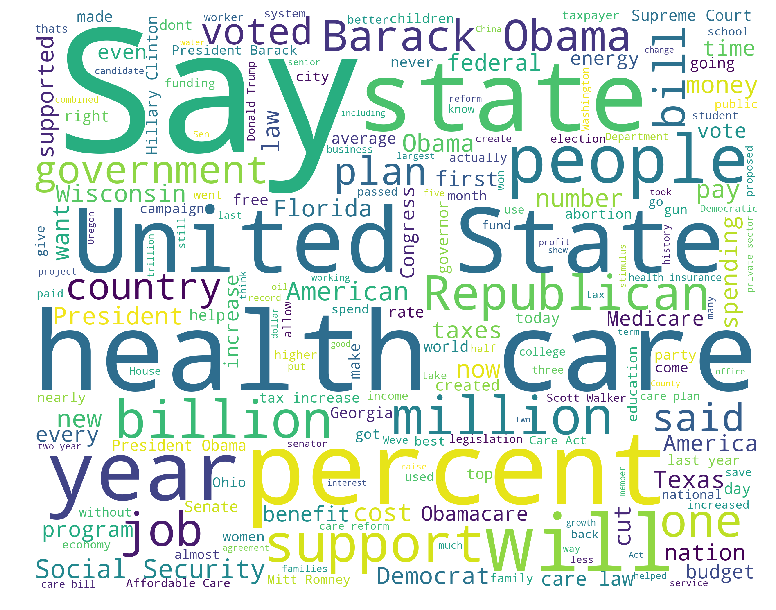

Highly Negative Named Entities


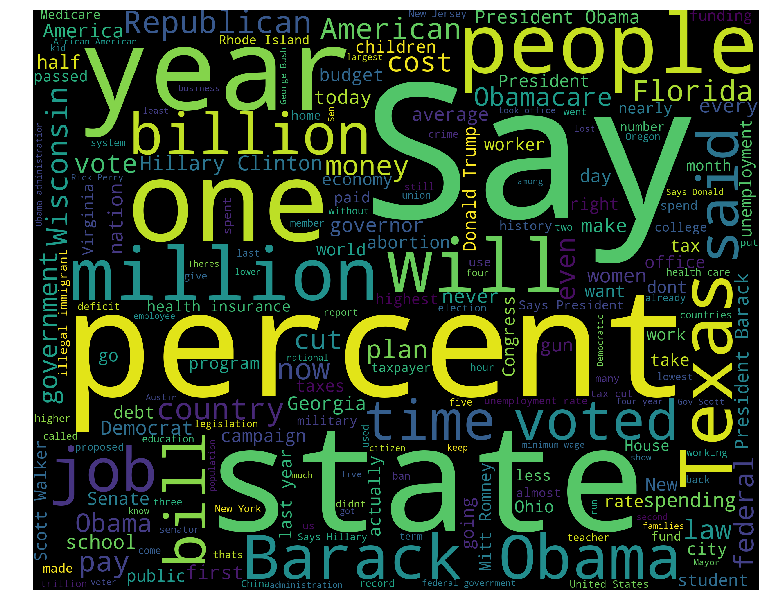

In [322]:
from wordcloud import WordCloud,STOPWORDS
def wordcloud_draw(data, color = 'black'):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and not word.startswith('#')
                                and word != 'RT'
                            ])
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(cleaned_word)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
    
positive_words=[] 
negative_words=[]
print("Highly Positive named entities")
for x in train_data['statement']: 
    ss = sid.polarity_scores(x)
    if ss["compound"] > 0.0:
        positive_words.append(x)
    else:
        negative_words.append(x)
        
wordcloud_draw(positive_words,'white')
print("Highly Negative Named Entities")
wordcloud_draw(negative_words)

# 2. Topic Modelling


#  1) Latent Semantic Analysis -
## Analyse Controversy Influence factor using Latent Semantic Analysis
* Compute possible similarities based on apparent semantic relatedness of texts (words)
* Using “Indexing by Latent Semantic Analysis” 
* Use LSA to compare documents based on their topics.

### Create the transformation model for corpus using tfidf

In [323]:
lsi = models.LsiModel(corpus, id2word=dictionary, num_topics=2)
print(lsi)

LsiModel(num_terms=170, num_topics=2, decay=1.0, chunksize=20000)


In [324]:
lsi.print_topics(10)

[(0,
  '0.077*"border" + 0.077*"budget" + 0.077*"cathol" + 0.077*"class" + 0.077*"bank" + 0.077*"campaign" + 0.077*"advantag" + 0.077*"amount" + 0.077*"educ" + 0.077*"citi"')]

In [325]:
doc1 = "Human politics russian banks"
vec_bow1 = dictionary.doc2bow(doc1.lower().split())
#print(vec_bow1)
vec_lsi1 = lsi[vec_bow1] # convert the query to LSI space
print(vec_lsi1[0][1]) #LSI index



0.07669649888473702


## Similarity score

In [326]:
index = similarities.MatrixSimilarity(lsi[corpus])
sims = index[vec_lsi1]
print(list(enumerate(sims)))

[(0, 1.0)]


In [327]:
# tagged_headlines = pd.DataFrame(
#    {'tags':[TextBlob(train_data['statement'][i]).pos_tags
#                             for i in range(train_data['statement'].shape[0])]})

# word_counts = []
# pos_counts = {}

# for headline in tagged_headlines['tags']:
#     word_counts.append(len(headline))
#     for tag in headline:
#         if tag[1] in pos_counts:
#             pos_counts[tag[1]] += 1
#         else:
#             pos_counts[tag[1]] = 1

In [328]:
voc="obama law advantag charg diseas control syria comment inform rate attorney inaccuraci polic poll compani author rais senat iran oil dollar marriag india leadershi shoot reform defens republican delay union bank church presid peac offici februari fiscal fight spend parent candid fund school chines number expect rule ban job oklahoma amount campaign egypt prison educ tax administr concern vote cost violenc kill korea germani statu media race voter american insur effect popul attack drug debt world invest chairman trial congress murder crisi economi israel health war shot russian govern offens lawmak support sex patient gun whether progress judg democrat class mexico strike forc countri cut parti stock polit aid cathol crimin financ sourc store famili secur washington benefit elect threat reason unemploy weapon sale border bill debat land usa money nation investig price restrict court enforc conserv afghanistan immigr legisl goal abus syrian justic lawsuit armi victim china crime primari power account hous citi strategi societi labor project worth russia polici deficit militari america market sector budget credit news"

voc_bow = dictionary.doc2bow(voc.lower().split())
vec_lsa_voc = lsi[voc_bow]

In [329]:
LSA1_score=[]
for doc in train_data['stemmed']:
    bow_vector_st = dictionary.doc2bow(doc.lower().split())
    vec_lsa_ex = lsi[bow_vector_st]
    sim = gensim.matutils.cossim(vec_lsa_voc, vec_lsa_ex)

### Computing LSA MatrixSimilarity index for all news statements in training dataset with the dictionary of Controversial words

In [330]:
LSA_score=[]
mydict={}

for data in train_data['stemmed']:
    vec_bow2 = dictionary.doc2bow(data.lower().split())
    vec_lsi2 = lsi[vec_bow2] # convert the query to LSI space
    mydict[data] = vec_lsi2
    if len(vec_lsi2) >= 1:
        sim = gensim.matutils.cossim(vec_lsa_voc, vec_lsa_ex)
        LSA_score.append(vec_lsi2[0][1])
    else:
        LSA_score.append(0)
       
       
sorted_mydict = OrderedDict(sorted(mydict.items(), key=lambda x: x[1], reverse=True))
count=0
for key,val in sorted_mydict.items():
    if val and (count > 3 and count < 10):
        print (key, "=>", val[0][1])
        print('\n')
    count+=1

    

number politician vote rais tax time properti tax back sale tax increas util nurs home cell phone park lot lotteri win gym tax architect corzin budget drive debt number take => 0.843661487732109


schoolchildren nation forc watch presid justifi plan govern run health care bank automobil compani increas tax creat job rack debt presid => 0.8436614877321088


veto spend lawmak cut tax small busi job creation nation hous market right balanc state budget cut state spend => 0.8436614877321084


fact presid oppos abort abort go abort barack obama presid tv interview megachurch pastor true job lose lose econom polici place effect economi job accomplish job stimulus barack obama presid interview => 0.8436614877321078


spend money health care capita countri world develop countri world spend time averag countri spend capita spend => 0.8436614877321073


say vote war unpaid vote tax cut unpaid vote prescript drug bill cost health care bill pay => 0.8436614877321053




## Enrich the dataset - Append the LSA_score as a new column to the training dataset 

In [332]:
train_data['LSA_controversy_score']= LSA_score

In [333]:
train_data.head()

id        label                                          statement  \
0   2635.json        false  Says the Annies List political group supports ...   
1  10540.json    half-true  When did the decline of coal start? It started...   
2    324.json  mostly-true  Hillary Clinton agrees with John McCain "by vo...   
3   1123.json        false  Health care reform legislation is likely to ma...   
4   9028.json    half-true  The economic turnaround started at the end of ...   

   text-length  label_id                                      filtered_text  \
0           82         0  say annies list political group support trimes...   
1          141         1  decline coal start start natural gas take star...   
2          105         2                           agree vote benefit doubt   
3           78         0  health care reform legislation likely mandate ...   
4           54         1                 economic turnaround start end term   

                                             stemmed  \
0  say anni list polit group support trimest abor...   
1  declin coal start start natur gas take start b...   
2                            agre vote benefit doubt   
3  health care reform legisl like mandat free sex...   
4                   econom turnaround start end term   

                                           tokenized sentiment_polarity  \
0  [say, anni, list, polit, group, support, trime...           positive   
1  [declin, coal, start, start, natur, ga, take, ...           positive   
2                        [agr, vote, benefit, doubt]           positive   
3  [health, care, reform, legisl, like, mandat, f...           positive   
4             [econom, turnaround, start, end, term]            neutral   

   variance_level  LSA_controversy_score  
0           0.077               0.153393  
1           0.098               0.153393  
2           0.099               0.153393  
3           0.394               0.306786  
4           0.000               0.000000

### The scores are not very accurate, as some sentences which are controversial have still been scored low

# 2) TfidfVectorizer
### Analyse Controversy Influence factor using Tfidf Cosine Similarity
* Compute Cosine Similarity between statements and controversy vocabulary

In [334]:
corpus_cos = []
import gensim
from nltk.tokenize import word_tokenize

for text in train_data['stemmed']:
    corpus_cos.append(text)

In [335]:
vocab_doc_str = "abuse administration afghanistan aid america american army attacks authorities ban banks benefits bill border budget campaign candidate catholic china chinese church concerns congress conservative control country court crime criminal crisis cuts debate debt defense deficit democrats disease dollar drug drugs economy education egypt election elections enforcement fighting finance fiscal force funding gas government gun health immigration inaccuracies india insurance investigation investigators iran israel job jobs judge justice killing korea labor land law lawmakers laws lawsuit leadership legislation marriage media mexico military money murder nation nations news obama offensive officials oil parties peace police policies policy politics poll power president prices primary prison progress race reform republican republicans restrictions rule rules ruling russia russian school security senate sex shooting society spending strategy strike support syria syrian tax taxes threat trial unemployment union usa victim violence vote voters war washington weapons world account advantage amount attorney chairman charge charges cities class comment companies cost credit delays effect expectations families family february germany goal housing information investment markets numbers oklahoma parents patients population price projects raise rate reason sales schools sector shot source sources status stock store whether worth"

In [336]:
vocab_doc_stem = "abus account administr advantag afghanistan aid america american amount armi attack attorney author ban bank benefit bill border budget campaign candid cathol chairman charg china chines church citi class comment compani concern congress conserv control cost countri court credit crime crimin crisi cut debat debt defens deficit delay democrat diseas dollar drug economi educ effect egypt elect enforc expect famili februari fight financ fiscal forc fund ga germani goal govern gun health hous immigr inaccuraci india inform insur invest investig iran israel job judg justic kill korea labor land law lawmak lawsuit leadership legisl market marriag media mexico militari money murder nation news number obama offens offici oil oklahoma parent parti patient peac polic polici polit poll popul power presid price primari prison progress project race rais rate reason reform republican restrict rule russia russian sale school sector secur senat sex shoot shot societi sourc spend statu stock store strategi strike support syria syrian tax threat trial unemploy union usa victim violenc vote voter war washington weapon whether world worth"

In [337]:
corpus_cos.append(vocab_doc_stem)

#### Vectorize using TfidfVectorizer

In [338]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()

In [339]:
X = vectorizer.fit_transform(corpus_cos)
X
print(X[10])

  (0, 5623)	0.3568944029308679
  (0, 5253)	0.19410748026675886
  (0, 2376)	0.24663050752172688
  (0, 4650)	0.32249306930821964
  (0, 3336)	0.2015064899417237
  (0, 3884)	0.32419232056419406
  (0, 3045)	0.7241648693960631


In [340]:
#vectorizer.vocabulary_

In [341]:
features = vectorizer.get_feature_names()
print(features[4133])

rainfal


In [342]:
X.shape

(10241, 5835)

In [343]:
X.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [344]:
from scipy import spatial

In [345]:
cos_doc1 = 1 - spatial.distance.cosine(X[123].toarray(), X[10240].toarray())
cos_doc1

0.02999212730860601

## Computing Cosine Similarity for all News statements
* cosine distance = 1 - cosine similarity

In [346]:
cosine_dict={}
controversy_score=[]
#controversy_label= []
for i in range(10240):
    cos_doc1 = 1- spatial.distance.cosine(X[i].toarray(), X[10240].toarray())
    cosine_dict[train_data['statement'][i]] = cos_doc1
    controversy_score.append(cos_doc1)
    
sorted_dict = OrderedDict(sorted(cosine_dict.items(), key=lambda x: x[1]))

for key,val in sorted_dict.items():
    if val:
        print (key, "=>", val)
        print('\n')


Odd fact for odd draft: No. 2 overall pick will earn more than the No. 1 pick due to no state tax in Florida. So 2 not so bad. => 0.0047778785042338345


If you look at our tax mix, the share of corporate revenues as a percentage of our overall revenue mix has declined by about half over the last 30 years. => 0.005093060674750571


Geithner's failure to pay self-employment taxes while working for the IMF is a mistake that is commonly made for people who are working internationally or for international institutions. => 0.005415818460642652


Floridas proposed amendment for medical marijuana would allow people who alleged minor ailments such as muscle spasms, neck pain, back pain and even menstrual cramps (to qualify) for government-sanctioned pot-smoking. => 0.005787629856628507


Live cats have holes drilled into their skulls, posts put into their heads and coils put into their eyes, and some have had their ears cut off or are intentionally deafened or starved at UW-Madison labs that d

The Texas leg of the Keystone pipeline has already created 4,800 jobs in just the year its been up and running. => 0.012375049774090763


While fighting a move to toughen penalties for workplace gender discrimination, state Sen. Glenn Grothman said he didnt believe women belonged in the workplace but belonged at home, cooking and cleaning and having babies. => 0.01240092611385779


Michigan and Massachusetts raised their bottle deposit and could no longer afford the program because the redemptions were so high there was no profit in there. => 0.012412609282846265


Two years ago, the longest serving leader of the California republic, Jerry Brown, boldly declared in China that California is a separate nation. => 0.012415816383751


We had an agreement that the president could have signed that would have kept 10,000 troops in Iraq. => 0.012420016384872001


Recent international reports show the United States near the bottom among industrialized nations for k-12 academic achievement. => 0

In 2011, the average annual compensation for a teacher in the Milwaukee Public Schools system will exceed $100,000. => 0.015016693815178783


An April study found that about 70 percent of ads in this election cycle have been negative [due to SuperPACs], up from only 9 percent through the same period in 2008. => 0.015018002298870625


Says 3,000 Americans died of gunfire between the time of the Ebola scare in Dallas and the midterm elections. => 0.015018689538550012


Says Rick Perry wrote a newspaper item saying he was open to amnesty for illegal immigrants in the United States. => 0.015031321282898968


Says his plan to raise car registration to $56 would still leave Virginia with a fee thats equal to or lower than most states. => 0.01503971378875657


90% of Americans want national background checks that close loopholes. => 0.01505009763701215


In the last two years, super PACs raised more than $180 million -- with roughly half of it coming from fewer than 200 super-rich people and 

Rhode Island has the the second-most heavily deployed National Guard in the United States. => 0.01787091142611341


Our median household income in 2013 was the highest in the nation. => 0.01787557445704624


As governor, Mitt Romney raised nursing home fees eight times. => 0.01788399442137678


Florida is considered the fourth-largest gambling state in the nation. => 0.017903198735571446


Foreign Trade Zones allow U.S. land to be inhabited by Chinese communists -- communists straight from China! They are to set up little towns and live here. => 0.017904685023852118


Weve outdrawn the Super Bowl for a little while now in the arenas and stadiums that weve followed them in for the Super Bowl. Weve gone in after [the NFL] and surpassed their ticket sales. => 0.01792562521255192


Welders make more money than philosophers. => 0.01792936609229656


The town of Cumberland has its highest bond rating in history. => 0.01793619435326499


Says Bernie Sanders has been largely a very reliable su

If public employees dont pay more for benefits starting April 1, 2011, the equivalent is 1,500 state employee layoffs by June 30, 2011 and 10,000 to 12,000 state and local government employee layoffs in the next two years. => 0.020987988211001563


Says Marco Rubios proposed college affordability overhaul would specifically benefit for-profit colleges. => 0.02100406744790284


The stimulus created zero jobs. => 0.021006733145936707


With a bill bringing $100 million in property tax relief, the typical Wisconsin homeowner will save approximately $680 over four years. => 0.021012470132157457


Today in Selma, Ala., the poverty rate is roughly nine times that of whites. => 0.021013930048521923


Says Hillary Clintons health care plan from the 1990s had a broader provision in favor of corporate right to back out of providing contraceptive coverage than the one created by the Hobby Lobby Supreme Court decision. => 0.021018452042764757


Every signer of the Declaration of Independence had n

Milwaukee County taxpayers paid $370,000 to settle a lawsuit over a decision by Sheriff David A. Clarke Jr. to use untrained corrections officers rather than deputies to patrol the lakefront. => 0.024508174788346104


Ukraine voluntarily gave up its nuclear weapons because the United States of America said it would ensure (its) territorial integrity from Russia. => 0.02451344114377696


The typical Wisconsin worker makes $5,000 less each year than our neighbors in Minnesota under Gov. Scott Walkers policies. => 0.02451744650664167


A large number of the uninsured earn $75,000 or more a year. => 0.024524893268644266


We now sell more products made in America to the rest of the world than ever before. => 0.024525509401103762


Georgia has "a dropout rate thats higher" than Alabama's. => 0.024532771076865467


Under federal law, Jared Loughner would not have been able to buy a gun had he been identified as mentally ill. => 0.024533719199629767


Radio Marti and TV Marti have spent more 

Says Stefani Carter repeatedly used her campaign contributors donations to rent margarita machines for our state house office. => 0.027910973410873563


Says 11 soccer players on the U.S. Mens National Team are immigrants. => 0.027916596988348363


We havent passed a budget in more than three years and not a single appropriations bill has been brought to the floor this year. => 0.027917456327757995


The decision to cancel the trademark of the Washington Redskins is not the Patent and Trademark Office. This is Barack Obama. => 0.02793469851040531


[L]ess than one-tenth of Atlantas transportation needs are covered in a referendum to levy a 1-cent sales tax. => 0.0279527661615806


It was Dan Sullivan who wrote a bill to cut Alaskans out of those decisions about where they can hunt and fish. => 0.02795559905450451


Mitt Romney opposed the gun lobby, even Ronald Reagan. => 0.027958181985938024


As governor, in the face of partisan attacks, (Charlie Crist) had the courage to save jobs a


Over the last 15 months, weve added more than 2 million jobs in the private sector. Thats far in excess of what it was in the comparable period after the last recession. => 0.03130193462657427


San Antonio is now the largest city in the United States ever to have an African American woman mayor. => 0.0313056279042101


The commercial property tax [in Providence] is second highest in the country behind Detroit. => 0.031308742443107884


Says a Canadian provincial prime minister came to Ohio for his medical treatment because of the delay in Canadian health care which would have endangered his life. => 0.03133680387694271


Says Donald Trump said the government is going to pay for everybody to have health care. => 0.03135536512578818


U.S. forces in Iraq and Afghanistan include a "few thousand that are still green card holders who are not even citizens of this country." => 0.03135591947246896


The United States is the oldest democracy in the world. => 0.031374712750207645


The defici



Says Scott Browns carrying some big oil baggage because he collected over $400,000 in campaign contributions. => 0.03563259275564479


Hitler abolished unions and thats what Wisconsin Gov. Scott Walker is doing today. => 0.03563573611085735


Says in the last 20 years, the French have not stood by the United States on foreign policy. => 0.035638246906253945


Says the Obama administration catches and releases nonviolent illegal immigrants. => 0.035639776806817736


Georgia spends fewer tourism advertising dollars than any other state in the South. => 0.03564694361192189


Says Lois Frankel took a 40 percent pay raise as mayor while West Palm Beach lost jobs. => 0.03565049333198078


Says this House processed and approved as many bills as previous Legislatures. => 0.03565429377124163


25% of human trafficking victims are located in Texas. => 0.035662008006035695


Repealing the health care law would save $95 billion in 2016. => 0.035666506619016713


The election bill allows persons 

The U.S. Postal Service doesnt run on your tax dollars. Its funded solely by stamps and postage. => 0.04017021690797229


There are more oil rigs in operation in the United States than the rest of the world combined. => 0.040176532263385356


Every single one of the 41 Republican senators who just blocked a raise in the minimum wage will receive a $2,800 cost-of-living adjustment on January 1, 2015. => 0.04017781794130826


Public support for abortion is actually going down a little bit, polls show. => 0.04017853441873753


If you take the population growth here in Virginia, we are net zero on job creation since (Bob McDonnell) became governor. => 0.040188576827129285


According to one study, the minimum wage today is worth $2 less than in 1968. => 0.04020337965715226


The average (public school) teacher in Wisconsins making $89,000 a year in salary and benefits. => 0.04021228940571764


President Obama has broken his pledge to the American people to be transparent throughout (health

Planned Parenthood is an organization that funnels millions of dollars in political contributions to pro-abortion candidates. => 0.04459466945854307


Says Texas ranks 44th nationally in education funding per pupil. => 0.04460404151676778


For every [coyote] they kill, the population will replace and usually multiply. => 0.04460831347951


Even high estimates for an early draft of the health care plan are less than the $1.8 trillion cost of the Bush tax cuts. => 0.04461051380291403


Says the Obama administration is handing out a pamphlet titled, What To Do When The Veteran In Your Classroom Attempts A Mass Shooting => 0.044614448530468365


Says Chuck Hagels nomination as defense secretary has been publicly celebrated by the Iranian government. => 0.044624232170816125


Says Lee Leffingwell raised property taxes 20 percent in three years. => 0.04463508904961233


Says Rick Scott raised property taxes. => 0.04463508904961233


Says the Austin City Council may give $4 million a year to

Toledo Mayor Mike Bell (once) lost his job as a firefighter because his city ran out of money. => 0.05023263000359646


We have a legal immigration system in America that accepts 1 million people a year, legally. No other country in the world even comes close to that. => 0.05023536182217603


Says the United States has the worlds greatest health care system. => 0.0502537670965546


On financial reform, there is "a million dollars being spent, per congressman, in lobbying expenses on this issue. (The) industry has four lobbyists per member of the House and Senate working on this." => 0.05028207212662095


The president of the United States ... agrees with me that marriage should be between a man and a woman. => 0.050297792978046596


Since 1988, Congress has raised its own salary 15 times to reflect rising costs. But raised the minimum wage only three times. => 0.05031752355368535


The potential Iran nuclear agreement would limit Iran to the number of centrifuges needed for a weapon bu

Today, Florida is in 50th place in spending on education. => 0.056363658048838694


On the day the House voted on the climate change bill, there was not even a copy of the bill in the well of the House, which is standard. It wasnt even written. => 0.05637917726020747


The Obama administration "was successful in rushing a massive spending bill through Congress in just two days after which it sat on the president's desk for three days, while he was away on vacation." => 0.056384159996987315


Americans, in the last 30 years, have more than doubled the amount of money we are spending per child (on education) and the results have gotten worse, not better. => 0.05639525167917403


Not a single unarmed white person has been shot by the police in New York in about 45 years. => 0.05639689184828389


Obama "has no experience or background at all in national security affairs." => 0.05646699473200634


An effort to repeal voting-reform legislation would be the first time in Ohio history where a 

Says Hillary Clintons top 10 donors are mainly banks, corporations and media, while Bernie Sanders top 10 donors are labor unions. => 0.06507825644839516


The House did vote against engagement in Kosovo, and Bill Clinton kept fighting anyway. And, then, ultimately, a vote did pass. => 0.06508142433178143


President Obama is actually increasing Bush-era defense spending by $21 billion in the new fiscal year. => 0.06508568469077225


Says President Barack Obamas homeland security budget had $16 million to fight climate change but didnt have a line item to fight violent extremism. => 0.06512056601668048


Says he never said he would keep education funding the same. => 0.0651454245704216


John McCain "voted against the Bush tax cuts, both times." => 0.06514642221145117


Because of President Barack Obamas failure to push job creation, the black unemployment rate in Ferguson, Mo., is three times higher than the white unemployment rate. => 0.06516632991899785


The White House budget plan

Since the salary for state lawmakers was raised to $79,500, that purchasing power has now been reduced to $53,000. => 0.0788989241889344


Senator Menendez said he would spend our money wisely. But our annual national deficit climbed from $250 billion a year to $1.6 trillion on his watch. => 0.07894777723253821


Says his promise of 250,000 new private sector jobs was a big goal. => 0.07900754699525325


Says Republican U.S. Senate candidate Tommy Thompson supports massive tax cuts for corporations that outsource Wisconsin jobs. => 0.07914079156637277


Were 48th in K-12 funding and 50th in higher education. => 0.07917353426398499


At the beginning of the last decade ... America had a budget surplus of over $200 billion. By the time I took office, we had a one-year deficit of over $1 trillion and projected deficits of $8 trillion over the next decade. => 0.07920449001013341


Says that before Rick Perry became governor, only 4 percent of our total labor force was a minimum wage job ..


The Treaty of Tripoli signed by President John Adams was his outreach to Muslims. => 0.01235107973435523


Amajority of the men and women on this stage have previously and publicly embraced amnesty. I am the only candidate on this stage who has never supportedamnesty. => 0.012465517855849595


It turns out that Texas has an $18 billion budget shortfall and cant afford its new science textbooks. => 0.012705998572039134


Says he vetoed $250,000 from the budget for a program to learn how to catch rainwater. => 0.012742962105028233


Last year, there were an additional 81,000 pages of government regulations. If you stack that up, it would be a three-story building. => 0.012761870065911562


Discretionary spending has increased over 20-some percent in two years if you dont include the stimulus. If you put in the stimulus, its over 80 percent. => 0.012842473383740005


The average faculty member at UW-Madison brings in close to a quarter million dollars a year in grant money. => 0.01287023



Current projections indicate that Medicare will go bankrupt by 2017, while Social Security will bottom out by 2037. => 0.041888646048287015


David Perdue did not support the 2014 farm bill that U.S. Sens. Isakson and Chambliss did. => 0.04191140815568839


He's promising four more years of an administration that will push for the privatization of Social Security... => 0.041965116062076424


In Afghanistan "the (military) leadership has proposed a new medal, an award for 'Courageous Restraint' ... for 'NOT FIRING BACK.' " => 0.04198042563148652


Every taxpayer owes about $130,000 to pay off the national debt. => 0.0421586554536969


Says Wisconsin Gov. Scott Walkers actions are directly responsible for killing at least 15,000 jobs. => 0.04216351647893535


Says President Barack Obama has lost more members of the House and more members of the Senate than any president ever has lost in modern times. => 0.04222204759387704


Says Lloyd Doggett voted for the health care, stimulus and ca

Since Corey Stewart became chairman in November 2006, unemployment is up 150% and average home price sales are down $150,000. => 0.12482327020131523


Martin Luther King was a Republican. => nan


Says Rick Santorum supported (Arlen) Specter over conservative candidates twice. => 0.10972779502834662


The Republican Party has the worst reputation in American polling of any political party in history. => 0.11235976723385088


In 2011 alone, 269 New Jerseyans were killed by gun violence. => 0.11525776443636415


Under President George W. Bush, the U.S. spent $1.3 trillion on tax cuts for the wealthy and trillions each on a war and on Medicare drug benefits. => 0.12464431354026506


Over 80 percent of the people want the shot to vote on whether to approve same-sex marriage, according to polls. => 0.1282609930192382


Says the 2014-15 state budget cut border security and funding to fight criminal gangs. => 0.1336518276277716


Charges on the Republican Party of Florida credit card were mad

## Enrich the dataset -  Append the  cosine_similarity_score as a new column to the training dataset 

In [347]:
train_data['cosine_similarity_tfidf']= controversy_score

In [348]:
train_data.head()

id        label                                          statement  \
0   2635.json        false  Says the Annies List political group supports ...   
1  10540.json    half-true  When did the decline of coal start? It started...   
2    324.json  mostly-true  Hillary Clinton agrees with John McCain "by vo...   
3   1123.json        false  Health care reform legislation is likely to ma...   
4   9028.json    half-true  The economic turnaround started at the end of ...   

   text-length  label_id                                      filtered_text  \
0           82         0  say annies list political group support trimes...   
1          141         1  decline coal start start natural gas take star...   
2          105         2                           agree vote benefit doubt   
3           78         0  health care reform legislation likely mandate ...   
4           54         1                 economic turnaround start end term   

                                             stemmed  \
0  say anni list polit group support trimest abor...   
1  declin coal start start natur gas take start b...   
2                            agre vote benefit doubt   
3  health care reform legisl like mandat free sex...   
4                   econom turnaround start end term   

                                           tokenized sentiment_polarity  \
0  [say, anni, list, polit, group, support, trime...           positive   
1  [declin, coal, start, start, natur, ga, take, ...           positive   
2                        [agr, vote, benefit, doubt]           positive   
3  [health, care, reform, legisl, like, mandat, f...           positive   
4             [econom, turnaround, start, end, term]            neutral   

   variance_level  LSA_controversy_score  cosine_similarity_tfidf  
0           0.077               0.153393                 0.032886  
1           0.098               0.153393                 0.019138  
2           0.099               0.153393                 0.042062  
3           0.394               0.306786                 0.069615  
4           0.000               0.000000                 0.000000

* cosine distance of 0; documents are similar;  cosine distance 1, documents are dissimilar
##### The scores are very inaccurate , since our dictionary consists of Controversy words combined into  one set of documents. It is not able to find frequency and important of each word.

# 3) LDA (Latent Dirichlet Allocation)
## Building LDA model using Bag of Words on the Data set
* Create a dictionary from ‘vocabulary’ containing the number of times a word appears in the training set.
* LDA returns a vector of topic probabilities for each document.


#### Get word frequency using nltk to get a word frequency (by count)  and  keep the top most used words to train the LDA model 

In [349]:
import nltk
from nltk import FreqDist
# first get a list of all words
all_words = [word for item in list(train_data['tokenized']) for word in item]
# use nltk fdist to get a frequency distribution of all words
fdist = FreqDist(all_words)
len(fdist) # number of unique words
#all_words

5785

In [350]:
# choose k and visually inspect the bottom 10 words of the top k
k = 1800
top_k_words = fdist.most_common(k)
top_k_words[-10:]

[('interst', 5),
 ('hop', 5),
 ('memori', 5),
 ('northeast', 5),
 ('affili', 5),
 ('granit', 5),
 ('cori', 5),
 ('attribut', 5),
 ('freshman', 5),
 ('payer', 5)]

In [351]:
# choose k and visually inspect the bottom 10 words of the top k
k =1900
top_k_words = fdist.most_common(k)
top_k_words[-10:]

[('legitim', 5),
 ('baseb', 5),
 ('scientif', 5),
 ('purpo', 5),
 ('stuff', 5),
 ('motorist', 5),
 ('knowledg', 5),
 ('gallon', 5),
 ('embrac', 5),
 ('mill', 5)]

In [352]:
# define a function only to keep words in the top k words
k=5
top_k_words,_ = zip(*fdist.most_common(k))
top_k_words = set(top_k_words)
def keep_top_k_words(text):
    return [word for word in text if word in top_k_words]

In [353]:
top_k_words

{'presid', 'say', 'state', 'tax', 'vote'}

In [354]:
# document length
train_data['doc_len'] = train_data['tokenized'].apply(lambda x: len(x))
doc_lengths = list(train_data['doc_len'])
train_data.drop(labels='doc_len', axis=1, inplace=True)

print("length of list:",len(doc_lengths),
      "\naverage document length", np.average(doc_lengths),
      "\nminimum document length", min(doc_lengths),
      "\nmaximum document length", max(doc_lengths))

length of list: 10240 
average document length 7.28291015625 
minimum document length 0 
maximum document length 250


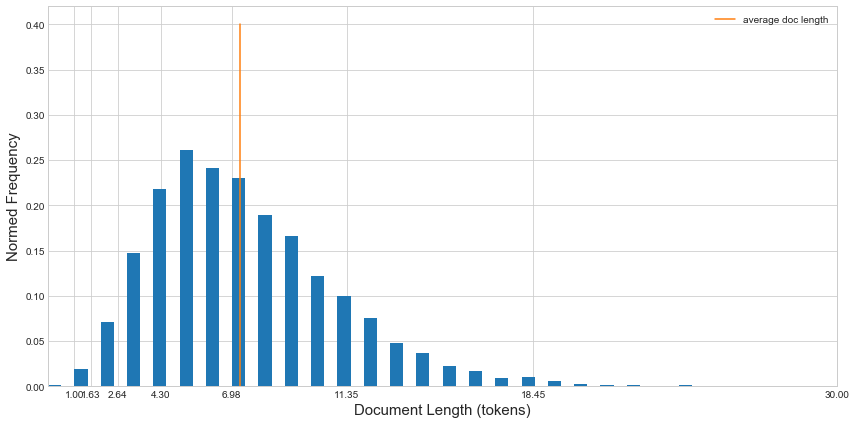

In [355]:
# plot a histogram of document length
num_bins = 500
fig, ax = plt.subplots(figsize=(12,6));
# the histogram of the data
n, bins, patches = ax.hist(doc_lengths, num_bins, normed=1)
ax.set_xlabel('Document Length (tokens)', fontsize=15)
ax.set_ylabel('Normed Frequency', fontsize=15)
ax.grid()
ax.set_xticks(np.logspace(start=np.log10(1),stop=np.log10(30),num=8, base=10.0))
plt.xlim(0,30)
ax.plot([np.average(doc_lengths) for i in np.linspace(0.0,0.4,9)], np.linspace(0.0,0.4,9), '-',
        label='average doc length')
ax.legend()
ax.grid()
fig.tight_layout()
plt.show()

###  It is useful to get the document length distribution to understand which model to choose. 
* For applying LDA it is advised to drop short articles as LDA does not work very well on short documents, so I will drop some of the shorter articles before training the model.



In [356]:
texts= list(texts)
#texts

In [357]:

dict_tokenized = gensim.corpora.Dictionary(texts)
count = 0
for k, v in dict_tokenized.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 abus
1 account
2 administr
3 advantag
4 afghanistan
5 aid
6 america
7 american
8 amount
9 armi
10 attack


### Gensim doc2bow

For each document we create a dictionary reporting how many
words and how many times those words appear. Save this to ‘bow_corpus’

In [358]:
dict_bow_corpus = [dict_tokenized.doc2bow(doc) for doc in texts]
#dict_bow_corpus[0]


## Training LDA model using gensim.models.LdaMulticore for statements in training dataset

In [359]:
lda_model = gensim.models.LdaMulticore(dict_bow_corpus, num_topics=10, id2word=dict_tokenized, passes=2, workers=2)

In [360]:
index = similarities.MatrixSimilarity(lda_model[dict_bow_corpus])
index

In [361]:
#voc="obama law advantag charg diseas control syria comment inform rate attorney inaccuraci polic poll compani author rais senat iran oil dollar marriag india leadershi shoot reform defens republican delay union bank church presid peac offici februari fiscal fight spend parent candid fund school chines number expect rule ban job oklahoma amount campaign egypt prison educ tax administr concern vote cost violenc kill korea germani statu media race voter american insur effect popul attack drug debt world invest chairman trial congress murder crisi economi israel health war shot russian govern offens lawmak support sex patient gun whether progress judg democrat class mexico strike forc countri cut parti stock polit aid cathol crimin financ sourc store famili secur washington benefit elect threat reason unemploy weapon sale border bill debat land usa money nation investig price restrict court enforc conserv afghanistan immigr legisl goal abus syrian justic lawsuit armi victim china crime primari power account hous citi strategi societi labor project worth russia polici deficit militari america market sector budget credit news"

In [362]:
voc_bow = dictionary.doc2bow(vocab_doc_stem.lower().split())
vec_lda_voc = lda_model[voc_bow]

In [363]:

#voc = "abuse administration afghanistan aid america american army attacks authorities authority banks benefits bill border budget campaign candidate candidates catholic china chinese church concerns congress conservative control country court crime criminal crisis cuts debate debt defense deficit democrats disease dollar drug drugs economy education egypt election elections enforcement fighting finance fiscal force funding gas government gun health immigration inaccuracies india insurance investigation investigators iran israel job jobs judge justice killing korea labor land law lawmakers laws lawsuit leadership legislation marriage media mexico military money murder nation nations news obama offensive officials oil parties peace police policies policy politics poll power president prices primary prison progress race reform republican republicans restrictions rule rules ruling russia russian school security senate sex shooting society spending strategy strike support syria syrian tax taxes threat trial unemployment union usa victim violence vote voters war washington weapons world account advantage amount attorney chairman charge charges cities class comment companies cost credit delays effect expectations families family february germany goal housing information investment markets numbers oklahoma parents patients population price projects raise rate reason sales schools sector shot source sources status stock store whether worth"


In [364]:
print(train_data['tokenized'][5])

['chicago', 'bear', 'start', 'quarterback', 'total', 'number', 'tenur', 'uw', 'faculti', 'fire']


In [247]:
from gensim import corpora, models
np.random.seed(2017)
texts = train_data['tokenized'].values
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]
ldamodel2 = models.ldamodel.LdaModel(corpus, id2word=dictionary, 
                                    num_topics=8, passes=5, minimum_probability=0)

In [119]:
hm = np.array([[y for (x,y) in ldamodel2[corpus[i]]] for i in range(len(corpus))])

In [120]:
from sklearn.manifold import TSNE

from bokeh.io import output_notebook
from bokeh.plotting import figure, show
from bokeh.models import HoverTool, CustomJS, ColumnDataSource, Slider
from bokeh.layouts import column
from bokeh.palettes import all_palettes
output_notebook()

Loading BokehJS ...

In [121]:

tsne = TSNE(random_state=2017, perplexity=30)
tsne_embedding = tsne.fit_transform(hm)
tsne_embedding = pd.DataFrame(tsne_embedding, columns=['x','y'])
tsne_embedding['hue'] = hm.argmax(axis=1)

#### For visualizing the scatter ratio of each word in the dictionary

In [123]:
source = ColumnDataSource(
        data=dict(
            x = tsne_embedding.x,
            y = tsne_embedding.y,
            colors = [all_palettes['Set1'][8][i] for i in tsne_embedding.hue],
            title = train_data.label,
            year = train_data['text-length'],
            alpha = [0.9] * tsne_embedding.shape[0],
            size = [7] * tsne_embedding.shape[0]
        )
    )
hover_tsne = HoverTool(names=["df"], tooltips="""
    <div style="margin: 10">
        <div style="margin: 0 auto; width:300px;">
            <span style="font-size: 12px; font-weight: bold;">Title:</span>
            <span style="font-size: 12px">@title</span>
            <span style="font-size: 12px; font-weight: bold;">Year:</span>
            <span style="font-size: 12px">@year</span>
        </div>
    </div>
    """)
tools_tsne = [hover_tsne, 'pan', 'wheel_zoom', 'reset']
plot_tsne = figure(plot_width=700, plot_height=700, tools=tools_tsne, title='Papers')
plot_tsne.circle('x', 'y', size='size', fill_color='colors', 
                 alpha='alpha', line_alpha=0, line_width=0.01, source=source, name="df")

callback = CustomJS(args=dict(source=source), code="""
    var data = source.data;
    var f = cb_obj.value
    x = data['x']
    y = data['y']
    colors = data['colors']
    alpha = data['alpha']
    title = data['title']
    year = data['year']
    size = data['size']
    for (i = 0; i < x.length; i++) {
        if (year[i] <= f) {
            alpha[i] = 0.9
            size[i] = 7
        } else {
            alpha[i] = 0.05
            size[i] = 4
        }
    }
    source.trigger('change');
""")

slider = Slider(start=train_data['text-length'].min(), end=train_data['text-length'].max(), value=100, step=1, title="length")
slider.js_on_change('value', callback)

layout = column(slider, plot_tsne)

In [124]:
show(layout)

### The topics appear well scatered, unlike the topics for LSA model. Hence this is a better model for finding Controversy similarity index

### For each topic, LDA displays the words occuring in that topic and its relative weight.





In [365]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.006*"border" + 0.006*"februari" + 0.006*"project" + 0.006*"insur" + 0.006*"charg" + 0.006*"weapon" + 0.006*"support" + 0.006*"price" + 0.006*"obama" + 0.006*"china"
Topic: 1 
Words: 0.007*"iran" + 0.007*"militari" + 0.007*"gun" + 0.007*"tax" + 0.006*"war" + 0.006*"famili" + 0.006*"sale" + 0.006*"control" + 0.006*"sex" + 0.006*"restrict"
Topic: 2 
Words: 0.006*"attorney" + 0.006*"mexico" + 0.006*"shot" + 0.006*"societi" + 0.006*"forc" + 0.006*"inform" + 0.006*"congress" + 0.006*"american" + 0.006*"oil" + 0.006*"korea"
Topic: 3 
Words: 0.006*"spend" + 0.006*"class" + 0.006*"effect" + 0.006*"attorney" + 0.006*"shot" + 0.006*"delay" + 0.006*"rate" + 0.006*"presid" + 0.006*"fight" + 0.006*"syria"
Topic: 4 
Words: 0.006*"offici" + 0.006*"ga" + 0.006*"armi" + 0.006*"syrian" + 0.006*"inaccuraci" + 0.006*"secur" + 0.006*"union" + 0.006*"peac" + 0.006*"market" + 0.006*"congress"
Topic: 5 
Words: 0.006*"rais" + 0.006*"labor" + 0.006*"korea" + 0.006*"benefit" + 0.006*"ga" + 0.00

## 4) Running LDA using TF-IDF
* Create tf-idf model object using models.TfidfModel on ‘bow_corpus’.
* Apply transformation to the entire corpus. 


In [366]:
tf_idf = gensim.models.TfidfModel(corpus)
print(tf_idf)
s = 0
for i in corpus:
    s += len(i)
print(s)

TfidfModel(num_docs=1, num_nnz=170)
170


In [367]:
corpus_tfidf = tf_idf[corpus]
print(corpus_tfidf)

In [368]:
corpus_tfidf

In [369]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=10, id2word=dict_tokenized, passes=2, workers=4)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.006*"poll" + 0.006*"power" + 0.006*"parent" + 0.006*"parti" + 0.006*"patient" + 0.006*"peac" + 0.006*"polic" + 0.006*"polici" + 0.006*"polit" + 0.006*"oil"
Topic: 1 Word: 0.006*"poll" + 0.006*"power" + 0.006*"parent" + 0.006*"parti" + 0.006*"patient" + 0.006*"peac" + 0.006*"polic" + 0.006*"polici" + 0.006*"polit" + 0.006*"oil"
Topic: 2 Word: 0.006*"poll" + 0.006*"power" + 0.006*"parent" + 0.006*"parti" + 0.006*"patient" + 0.006*"peac" + 0.006*"polic" + 0.006*"polici" + 0.006*"polit" + 0.006*"oil"
Topic: 3 Word: 0.006*"poll" + 0.006*"power" + 0.006*"parent" + 0.006*"parti" + 0.006*"patient" + 0.006*"peac" + 0.006*"polic" + 0.006*"polici" + 0.006*"polit" + 0.006*"oil"
Topic: 4 Word: 0.006*"poll" + 0.006*"power" + 0.006*"parent" + 0.006*"parti" + 0.006*"patient" + 0.006*"peac" + 0.006*"polic" + 0.006*"polici" + 0.006*"polit" + 0.006*"oil"
Topic: 5 Word: 0.006*"poll" + 0.006*"power" + 0.006*"parent" + 0.006*"parti" + 0.006*"patient" + 0.006*"peac" + 0.006*"polic" + 0.006*"

### Performance evaluation of LDA model for classifying sample document using Bag of Words

In [370]:
for index, score in sorted(lda_model[dict_bow_corpus[0]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))


Score: 0.9947368502616882	 
Topic: 0.006*"border" + 0.006*"februari" + 0.006*"project" + 0.006*"insur" + 0.006*"charg" + 0.006*"weapon" + 0.006*"support" + 0.006*"price" + 0.006*"obama" + 0.006*"china"


### Performance evaluation of LDA model on tfidf for classifying sample document

In [371]:
for index, score in sorted(lda_model_tfidf[dict_bow_corpus[0]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model_tfidf.print_topic(index, 10)))


Score: 0.13008205592632294	 
Topic: 0.006*"poll" + 0.006*"power" + 0.006*"parent" + 0.006*"parti" + 0.006*"patient" + 0.006*"peac" + 0.006*"polic" + 0.006*"polici" + 0.006*"polit" + 0.006*"oil"

Score: 0.12497655302286148	 
Topic: 0.006*"poll" + 0.006*"power" + 0.006*"parent" + 0.006*"parti" + 0.006*"patient" + 0.006*"peac" + 0.006*"polic" + 0.006*"polici" + 0.006*"polit" + 0.006*"oil"

Score: 0.1140405610203743	 
Topic: 0.006*"poll" + 0.006*"power" + 0.006*"parent" + 0.006*"parti" + 0.006*"patient" + 0.006*"peac" + 0.006*"polic" + 0.006*"polici" + 0.006*"polit" + 0.006*"oil"

Score: 0.11250561475753784	 
Topic: 0.006*"poll" + 0.006*"power" + 0.006*"parent" + 0.006*"parti" + 0.006*"patient" + 0.006*"peac" + 0.006*"polic" + 0.006*"polici" + 0.006*"polit" + 0.006*"oil"

Score: 0.10458607971668243	 
Topic: 0.006*"poll" + 0.006*"power" + 0.006*"parent" + 0.006*"parti" + 0.006*"patient" + 0.006*"peac" + 0.006*"polic" + 0.006*"polici" + 0.006*"polit" + 0.006*"oil"

Score: 0.1035443097352981

In [372]:
total_topics = 50
lda_model_tfidf = models.LdaModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=total_topics, 
                                  passes=1, random_state=47)
lda_model_bow = models.LdaModel(corpus=dict_bow_corpus, id2word=dictionary, num_topics=total_topics,
                                passes=1, random_state=47)

In [373]:
import pyLDAvis.gensim
data = pyLDAvis.gensim.prepare(lda_model_bow, dict_bow_corpus, dictionary)
data

PreparedData(topic_coordinates=                                  x                             y  topics  \
topic                                                                       
38      (-0.0032979333107952306+0j)   (-0.0014835150567815516+0j)       1   
49      (-3.090689667319519e-05+0j)  (-1.2396835244411554e-05+0j)       2   
11     (-3.0906896673195294e-05+0j)  (-1.2396835244411108e-05+0j)       3   
21      (-3.090689667319532e-05+0j)  (-1.2396835244410754e-05+0j)       4   
20     (-3.0906896673194996e-05+0j)   (-1.239683524441167e-05+0j)       5   
19      (2.8318840364974384e-05+0j)   (-0.0001459635689878392+0j)       6   
18     (-0.00013785188261756403+0j)    (0.0005962417323812219+0j)       7   
17     (-1.2342742332468746e-05+0j)  (-3.3319957543947844e-05+0j)       8   
16      (-0.0006664358239046218+0j)     (0.003090938579747655+0j)       9   
15       (-3.09068966731951e-05+0j)   (-1.239683524441127e-05+0j)      10   
14      (0.00010192794926689563+0j)   (0.0001

### * Performance of LDA without TF-idf is better than LDA with TF-idf

## Testing model on unseen document

In [375]:
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [376]:
unseen_document = 'How a Pentagon deal became an identity crisis for Google'
bow_vector = dictionary.doc2bow(preprocess(unseen_document))
tmp=sorted(lda_model[bow_vector], key=lambda tup: -1*tup[1])[0]
print(tmp)


(0, 0.549999)


## Calculate LDA similarity score for the News Statement from training dataset 

In [377]:
LDA_score=[]
for doc in train_data['stemmed']:
    bow_vector_st = dictionary.doc2bow(preprocess(doc))
    vec_lda_ex = lda_model[bow_vector_st]
    sim = gensim.matutils.cossim(vec_lda_voc, vec_lda_ex)
    LDA_score.append(sim)
    print(doc,'=>',sim)
    print ('\n')
    


say anni list polit group support trimest abort demand => 0.9899494015522432


declin coal start start natur gas take start begin presid administr => 0.9899493733293149


agre vote benefit doubt => 0.9899494041685395


health care reform legisl like mandat free sex chang surgeri => 0.9953500263127798


econom turnaround start end term => 0.3162277523623265


chicago bear start quarterback total number tenur uw faculti fire => 0.9647636077481818


live district repres => 0.3162277523623265


person stage work pass ethic reform => 0.9647636046379593


take lotteri fund port newport land new noaa marin oper center pacif => 0.9899493997083161


say gop primari oppon cast compromis vote cost electr cost => 0.9973336743783416


time histori share nation popular vote margin vote margin => 0.995350025643816


slip middl class poverti => 0.9647635734853326


governor slow rate growth govern cut => 0.9899493996274276


economi bleed govern shutdown => 0.9899493993969366


afford care act sens wa

say veto job packag bill => 0.3162277523623265


job solar industri coal mine => 0.3162277523623265


say gubernatori candid prioriti win primari sponsor bill mass euthan shelter dog cat gas chamber => 0.9899494026238086


economi worsen presid => 0.9899494011721574


romney fail action sanctuari citi => 0.9647636136230466


say job recess peak gov trail rest come unemploy => 0.964763654847909


say come elev temperatur => 0.3162277523623265


foreign land conduct war nation histori => 0.9899494034770667


gas price go take offic => 0.9647636310533024


sponsor bill creat form marriag trap woman abus relationship => 0.9647635023894527


say judg benefit cost everybodi state => 0.9953500238758398


lot casino countri go bankrupt => 0.96476352455697


small busi creat job => 0.3162277523623265


senior coverag medicar advantag share health care reform => 0.9953499988116632


school kid arrest make nation leader area => 0.9899494012874029


countri economi rank world => 0.9953500244492377

cbo congression budget offic say obamacar kill job => 0.9953500247837196


thompson vote cap damag legal system fairer => 0.9647635561559214


money reserv state combin => 0.9647636042923791


strateg petroleum reserv => 0.3162277523623265


immigr fertil => 0.9647635558103411


propos educ chang cut teacher pay => 0.9647635487979737


number uninsur peopl mandat pass => 0.9647636077481818


firearm homicid pass conceal gun permit law => 0.3162277523623265


woman seek abort decid abort see ultrasound => 0.3162277523623265


spend defens gdp time pearl harbor => 0.9647635775315259


get rid incom tax today revenu => 0.3162277523623265


say want ban common form birth control includ pill => 0.96476356578179


support obama plan bring remain suspect terrorist soil => 0.9899494006990004


donat sorri give school citi => 0.9899494030160848


top intellig offici toldeveri member congress includ presid attack way threat eman => 0.9982743356279072


suburb inund resid hous project => 0.964763

get person tax system complic cost year compli current tax code => 0.9647635738309129


say school give student school provid prayer room prayer rug let class time day pray allah => 0.9953499947500961


believ abolish social secur abolish health care => 0.9899494011256179


bulk peopl shoot weapon drug gang take end shoot weapon => 0.9982743656860049


case general motor administr write check ask condit chang => 0.9647634691633578


salari uri faculti new england land grant univers major research institut => 0.9647635221379061


say congressman support drill vote presid abil fight pollut combat climat chang => 0.9973336745286255


presid candid ask disclos donor suspicion foreign sourc money campaign refus => 0.9982743357080551


state state continu pay medic benefit employe famili => 0.9899494011721574


wonder shop billionair find billionair fund super pac => 0.9647635745220735


say cash feder fund intend help small busi recov day attack trump say properti affect => 0.98994939939693

ounc soda tax result loss famili sustain teamster union job countless job beverag industri => 0.9899494017483846


challeng administr suspend public offici => 0.9899494002501936


take tobacco cash oppos tax cigar help pay children health care => 0.9647636268055012


feder reserv polici lead rise corn price rise wheat price spike sugar price => 0.9973336893237553


repeal wisconsin smoke ban => 0.3162277523623265


want nurs home close poll => 0.9647636036012185


time fund critic need wait list person uniqu abil help need => 0.9647635578838234


get start polit young staffer colleg work congressman committe => 0.9647635460333295


top grant requir particip state adopt common core standard condit receiv feder fund => 0.9647635578838234


presid wipe program allow share fingerprint bar know => 0.9647634975513242


seek polit support minist believ god punish gay right call cathol church fals cult => 0.997333704726392


say feder tax filer pay feder incom tax => 0.3162277523623265


debt 

say work legislatur balanc spend revenu end term raini fund establish => 0.9899494040532942


infant report die follow attempt abort => 0.3162277523623265


say death woman kill spous domest partner => 0.9647635415407828


spend job time famili bring paycheck pay gas pump groceri store => 0.9953499943200479


sleep lose chang daylight save time pose health risk => 0.9647636268055012


say rais tax => 0.3162277523623265


run governor => 0.3162277523623265


say legisl district state craft breweri countless home brewer => 0.964763552008957


wisconsin crimin threshold drunken drive way line state surround offens feloni => 0.9647636538111684


invest child rais school fund budget => 0.9973336739704284


poverti level school district countri => 0.9899494017140427


say administr lose job includ job => 0.9647634691633578


meet presid get upset => 0.9647634975513242


gov mrs host light state hous christma tree => 0.3162277523623265


deploy nation guard => 0.9647636056747002


say turnaro

build run streetcar project creat job => 0.9647636365825838


state unemploy rate => 0.9899494023933177


residenti properti tax mayor => 0.3162277523623265


assault weapon handgun allow state capitol bullhorn trumpet helium balloon flag pole ban => 0.9647636583037108


teacher work salari increas => 0.3162277523623265


pay employe state basketbal coach => 0.3162277523623265


lobbyist run campaign => 0.9647635879997064


requir borrow money expand deficit => 0.9899494023589613


jeb bush term offic florida graduat rate dead remain => 0.9647635838527423


farm grow area economi => 0.9647635797057785


see increas alcohol use underag kid alcohol illeg kid => 0.3162277523623265


obamacar bureaucrat tri tell cat scan delay treatment => 0.9647635733845603


propos keyston xl oil pipelin bipartisan propos => 0.3162277523623265


support gay marriag => 0.9899494021284704


say give speech say troop => 0.3162277523623265


say advoc guest worker program illeg immigr => 0.9647635558103411



say nation afford citizenship bear => 0.9647636056747002


record job => 0.3162277523623265


say bring new job cost job => 0.9647635571926625


say plan parenthood provid visit prenat care state => 0.3162277523623265


say state govern worker pay taxpay support => 0.9899494020475815


imprison give jail sentenc young peopl smoke marijuana => 0.3162277523623265


peopl sign obamacar => 0.3162277523623265


number new illeg immigr famili cross border exceed entir total => 0.9973336748936006


economi begin nose dive take control congress => 0.9953500244492377


say cut medicar => 0.3162277523623265


declar war => 0.3162277523623265


famili earn qualifi healthi kid program => 0.9647635228290672


say like wait hour respons => 0.3162277523623265


say governor vote properti tax cut u senat rival vote => 0.9953500251182016


politician bureaucrat tri run school stand protect local control => 0.9899494049409164


say know solut mortgag crisi => 0.9647635800513588


school district worri l

say go univis promis offic rescind presid illeg execut action => 0.9647634975513242


presid secur fund time high => 0.9953499963269398


say state rep stop peopl scamm share child care subsidi program vote fund fraud investig => 0.9953500255960329


percent wealth => 0.3162277523623265


creat feder incom tax year pay => 0.3162277523623265


say park director receiv pay rais => 0.3162277523623265


say romney write edit book health care plan expand take book => 0.9647636268055012


say gov impli portion worker compens rebat employ direct form campaign cash => 0.9647635786690374


state agenc agenc relat health care => 0.9647636268055012


say rep miss veteran affair committe hear => 0.3162277523623265


nascar endors trump => 0.3162277523623265


visit danc ohio senat chamber => 0.9647635565015019


premium medicar prescript drug program fall begin => 0.9647636143142072


governor stand coal plant point say plant kill => 0.9647635470700711


central fall school system spend time clock

legal mail child => 0.3162277523623265


peopl come vote unoppos race vote mitt romney combin => 0.9953500245448039


compar infrastructur program stimulus interst program propos highway system go road bridg => 0.3162277523623265


congressman congress vote disast relief time => 0.9899494035923122


u navi sail ship world nuclear power plant accid => 0.9899494034770667


gay man elect georgia legislatur => 0.9647635006615499


rep tour countri join hip work bipartisan fashion goal immigr reform => 0.9973336743568725


websit obamacar work work => 0.3162277523623265


take refuge process => 0.3162277523623265


congressman secur grand total date mahon valley addit pend spend bill => 0.9899494035114157


stimulus money hire new state worker job appli stimulus fund taxpay way feder govern => 0.9953500051228865


sen enact campaign propos taxpay face financ new spend white hous term => 0.9953500248792858


vote doubl vehicl registr fee cost counti resid => 0.9899494054362397


lot peopl kn

countri refus peopl order leav includ larg number violent crimin => 0.9953500253571173


say vote measur requir woman sonogram receiv abort => 0.964763572794172


da state convict duti polic offic crimin homicid => 0.989949402162827


say feder govern borrow week => 0.9647635807425194


offer oper millag rate metro atlanta => 0.9647635838527423


cfo overse loss state pension fund => 0.9647635578838234


bank presid elimin job take salari bonus => 0.9899494033618214


say educ popul state countri => 0.9953499957057589


law repeal allow discrimin worker sue state court gravi train lawyer => 0.9647635734853326


number homicid commit firearm decreas number crime involv use firearm plummet declin => 0.9953500051228865


say oppos offshor drill gas tax holiday => 0.3162277523623265


say militari spend countri combin => 0.9953499945111803


rememb develop forc use land union contractor tap construct project => 0.9973336743998108


say manag partner take arbitr => 0.3162277523623265


say 

say u senat oppon support feder budget spend money budget => 0.998792806242315


peopl countri say chang email phone habit collect datum allow patriot act => 0.96476352455697


say presid debt increas presid go => 0.9953499930299031


secur communiti program immigr program program work gutt administr => 0.995349995753542


spend campaign governor => 0.9899494047447668


say presid nation secur advis conced robust uranium enrich capabl => 0.9953500249748521


local option allow communiti ban limit restrict locat pot shop amend pass expect seedi element pot industri right door neighborhood church busi child school => 0.997333674099243


decis fire gen presid fix problem inherit administr => 0.9899493733293149


say lie parent name => 0.9647635692375948


health care law impos tax increas histori middl class => 0.9899494002036546


number terrorist doubl => 0.9647636077481818


espionag act allow come court justifi disclos inform whistleblow except espionag act => 0.9899494022093668


med

segment beer market grow craft beer segment => 0.96476356578179


say hourpropos aggress minimum wage increas countri => 0.96476352455697


see kid => 0.3162277523623265


rural woman woman illiter => 0.3162277523623265


refus stand repeal obamacar => 0.3162277523623265


say price gas tax holiday bridg nowher pork barrel project => 0.9899494016209637


say medicar cut come => 0.3162277523623265


fenc work berlin wall good peopl friend => 0.3162277523623265


say requir state septic inspect cost septic tank owner year => 0.9647635731397524


say multnomah counti librari system nation => 0.9647636056747002


ssdi ssi disabl => 0.3162277523623265


peopl cast provision ballot presidenti elect vote count => 0.9899494003654392


centerpiec senat educ polici increas program slot => 0.9953500231113097


administr outsourc send money solar wind energi compani end make product => 0.9953499952279274


mandatori ultrasound abort => 0.3162277523623265


state depart send comedian make chai tour

schedul narcot job congress => 0.9647635688920142


beer product consumpt hand hand => 0.3162277523623265


see decreas violent crime => 0.9647635751124627


say privat invest streetcar => 0.9647635128072308


say rep vote provid congress taxpay fund health care life => 0.9973336741421813


israel capita incom rest world => 0.9899494041685395


feloni case nation commit defend grow father absent household => 0.9647636056747002


interview presid choos tv apolog => 0.9647634923676149


track traffic fatal declin => 0.3162277523623265


busi close open => 0.3162277523623265


record number peopl live poverti => 0.9647636077481818


serv board weather underground member relationship mr board continu => 0.3162277523623265


say break promis offer comprehens immigr bill => 0.9647635558103411


medium publish real photo tattoo face => 0.3162277523623265


support negoti => 0.9647636562302297


social secur project remain solvent whitehous cosponsor bill extend life program => 0.9899494035457

say runoff oppon run => 0.3162277523623265


say rep leav taxpay hook studi genet makeup ant => 0.3162277523623265


presid recent plan cut wast administr save money go spend => 0.997333672832565


estim save debt ceil deal pay cost extend era tax cut => 0.9899494048600124


secretari state allow illeg voter regist => 0.9647635807425194


budget vote time senat budget cut defens spend propos cut => 0.9982743356479442


rural school enrol child receiv feder educ fund => 0.9953499946067468


base nation job number person get job peopl stop look job => 0.9899494039723975


repeal => 0.3162277523623265


gain go => 0.3162277523623265


aid act repres thompson campaign send email critic sexual orient u senat candid => 0.9953500262172136


immigr report presid plan scale presid => 0.9953499938899997


administr allow crimin alien return communiti individu encount identifi immigr custom enforc detain process deport correct => 0.9973336743139343


forc resign anybodi fox say word => 0.96476357

sen econom plan give tax break oil compani provid tax relief middl class famili => 0.9953499961835904


say get nomine confirm presid time term => 0.9647634975513242


say promis cut deficit => 0.9647635752132343


state senat ram tax hike public input => 0.9647635731397524


want nation background check close loophol => 0.9647636056747002


artist includ cancel show protest stand ground => 0.3162277523623265


program immigr come bring order green card go creat job => 0.9647635558103411


say contract lobbyist freddi mac => 0.3162277523623265


privat social secur bad idea propos bad idea sen campaign go suggest cut cost live adjust rais retir age => 0.9953500257871654


deport illeg immigr => 0.9647635558103411


countri bankrupt => 0.9647635197188421


spend stagger money health care countri person => 0.9973336744427489


prevent care save money => 0.9647636042923791


say conni mack iv co sponsor bill social secur trust fund individu account senior citizen invest stock market => 0.

support => 0.9647636562302297


look propaganda lot terrorist site saysabout recruit fighter => 0.3162277523623265


say governor endors => 0.3162277523623265


general electr creat job countri pay tax make histor profit => 0.96476352455697


say u attorney offic say campaign idea go father illeg campaign contribut close case => 0.9953499961358072


iowa caucus stop matter way determin parti nomine => 0.964763548207573


say plan parenthood terrificand taxpay fund => 0.9647635578838234


sen miss percent vote miss miss vote => 0.9899494050905033


eat catfish resid state combin => 0.3162277523623265


say want let refuge amnesti illeg immigr => 0.9647635558103411


record => 0.3162277523623265


adjust cost live rank teacher salari benefit => 0.9899494018979795


sen reward wall street execut bonus => 0.3162277523623265


say act reform save taxpay => 0.9647636046379593


say feder health care law uphold suprem court improv save life prevent obtain health coverag exist condit => 0.9953

bill back sean duffi hous requir intern revenu servic conduct audit rape victim abort => 0.9647636517376873


obamacar put feder govern doctor => 0.9647635807425194


state hire compani evalu state mandat student exam go craigslist examin read student => 0.964763553736859


pinnacl overlook southwest virginia state capit => 0.3162277523623265


record scholarship help needi child attend privat school => 0.9647635166086169


shoot reflect disturb trend mass shoot commonplac virginia tech massacr incid peopl wound die => 0.9899494032000358


say tax revenu => 0.3162277523623265


say barack obama health care law job killer => 0.98994939920081


cost implement class size amend => 0.9899494050905033


secretari leav option tabl abandon dollar multin currenc => 0.9647635800513588


say cut fund local govern contribut increas violent crime midwest => 0.995350025261551


say rep spend tax dollar stimulus fail compani job => 0.9953499986205305


fcat test account instruct time provid => 0.9647

say rep => 0.3162277523623265


rep vote piec legisl help auto bodi shop point think conflict interest => 0.9899494047447668


say refus testifi congress attack => 0.9899494047447668


commerc secretari nomine appear endors world govern => 0.9899494056667306


obama say go pledg protect tax break corpor hide profit => 0.9647636320900428


say mental health expenditur => 0.9647636268055012


say vote allow peopl terror watch list buy gun => 0.964763572794172


say obama administr fulfil request fire manag assist grant => 0.9899494024398575


say feder debt doubl administr => 0.9899494028664976


administr rais revenu nation health care seri new tax includ light switch tax cost household year => 0.9973336742924651


offshor wind power expens solar energi => 0.9647635547736001


constitut author feder govern land state => 0.9953499958013253


say cost special legisl session pay condom pill time sexual health educ => 0.997333674099243


defend want burn flag call effort ban flag burn ridic

attend meet => 0.3162277523623265


illeg immigr cost state taxpay => 0.9899494046295215


say liber immigr reform group endors gop primari oppon => 0.995350026360563


welder money philosoph => 0.9647636042923791


call health care reform => 0.9899494017018452


say support plan allow foreign corpor ohio turnpik => 0.9647636562302297


break record fundrais u senat race => 0.9899494031313304


ryan deal divid govern budget agreement => 0.9899494010103728


peopl speak say stop loom tax hike => 0.3162277523623265


debat search googl remaind => 0.9647635499354748


say state budget deal texa hous senat leader fund nurs home public school univers provid financi aid colleg student => 0.9982743356279072


ask geograph limit drone strike program respond say limit => 0.9647635776322965


say time magazin call governor => 0.3162277523623265


support suprem court abort decis roe wade => 0.989949404087643


celebr presid recent colleg grad move parent => 0.9899494024055157


unemploy tick tim

say support pave develop sprawl => 0.9647636562302297


sen cast decid vote senat afford care act => 0.9899494052057489


state repres oppos tough mandatori sentenc convict domest violenc child abus => 0.9647634632884867


offer sanctuari illeg immigr => 0.9647635502810551


say burst self pronounc guidelin acceptingforeign donat clip say go foreign donat => 0.3162277523623265


activ develop project => 0.9647636365825838


person bankruptci caus medic problem => 0.3162277523623265


enorm progress human right fact recogn peopl world => 0.9899494014369977


say state medicaid waiver propos languish file cabinet center medicar medicaid servic => 0.3162277523623265


teenag fall counterpart math scienc => 0.3162277523623265


ill report raw milk total ill occur => 0.3162277523623265


percentag capita nonprofit state state union => 0.9647635513177962


gop platform seek limit abort silent except rape => 0.3162277523623265


say suprem court justic animmigr famili background => 0.99534999

sen vote immigr reform permit immigr peopl come work => 0.99733367465744


senat liber vote record senat => 0.9953500237324905


say school district school district leav state ignor act law => 0.9899493995243785


growth sector govern growth => 0.9899494022437159


rais minimum wage help work time averag worker => 0.3162277523623265


graduat class smoke marijuana illeg drug => 0.9899494022437159


taxpay pay fortun use campaign trail presid => 0.9899494011721574


note observ includ secretari labor plan anybodi reduc cost => 0.9899494031656794


public option fund public money fund privat insur premium => 0.9973336752585755


state includ appoint elect state school superintend => 0.989949399639624


come nobodi stop train => 0.3162277523623265


averag militari work dog save life serviceman woman span career => 0.9647634708912611


onlin chang address place estim voter cast provision ballot chang address vote regular ballot => 0.989949403280925


tourism account job state visitor spen

man woman guard forc contact food bank feed => 0.9899493997426729


say view abort restrict presid recent time => 0.9899494007920788


profit groupfe lie claimsthat kid fight starvat => 0.9647635769411358


lead propon amnesti challeng chang => 0.3162277523623265


imag white blondwoman show amaz divers fox news anchor => 0.9647636049835396


medicar propos rep wis allow insur compani deni coverag drop exist condit => 0.9899494008951272


statewid race margin overturn recount => 0.9647635678552727


order worth lobster caviar hotel => 0.9647635491435541


say say languag ghetto => 0.3162277523623265


come offic vaccin rate leav => 0.9647635838527423


central health hospit district spend taxpay dollar abort => 0.9953500259782979


decis remov chick fil emori univers base student feedback => 0.3162277523623265


woman miscarriag investig polic legisl support state senat candid => 0.9987928060991146


busi requir certifi ir penalti perjuri obamacar motiv factor cut staff => 0.3162277523

say corpor fail disclos differ financi disclosur => 0.9647636122407255


wash hand cover mouth cough make huge differ reduc transmiss flu => 0.3162277523623265


person bankruptci caus medic bill => 0.3162277523623265


presid come elect ward go elect increas vote => 0.9973336880205225


spend welfar prison educ drop arizona immigr law drive outundocu immigr => 0.9982743648644886


world chang career work compani averag worker stay job => 0.9899494052057489


give public employe state freedom choos want union => 0.9647635513177962


rais money state => 0.9647636042923791


vote driver licens illeg immigr => 0.9899494030504339


boostteacherpens fundput mandat local govern => 0.9647635807425194


say help man accus rap see laugh separ occas laugh girl rap => 0.3162277523623265


say gov say equal pay equal work woman => 0.3162277523623265


say program bring dropout school success citi state replic => 0.9899494030160848


tell want secur diplomat facil => 0.964763583507162


say spend h


estim leav year year tabl uncollect ir resourc => 0.3162277523623265


rev compar unit state marin corp roman legionnair respons death savior => 0.3162277523623265


say state sen forc school => 0.9899494035579703


state run lotteri fund classroom => 0.9647635745220735


social secur advoc way get peopl quit work think confin perman scarciti job countri => 0.9899494035923122


matter presid => 0.9647634975513242


singl legisl millenni elector => 0.964763552008957


vote parti line time => 0.9899494024742067


say presid say normal requir liber polit prison basic step freedom includ freedom press polit parti labor union => 0.9991085239175387


corpor tax rate world => 0.9899494009760159


finish controversyabout wherepresid bear => 0.3162277523623265


pot money redistrict issu includ defend redistrict lawsuit tax dollar spend => 0.9973336742924651


school shoot mass kill sandi hook elementari school state => 0.9973336734981076


go kill famili terrorist realiz call geneva convent g

pro choic record => 0.3162277523623265


test share fact widget => 0.3162277523623265


bill grant drug compani medic devic manufactur immun injuri death caus product => 0.9899493991664459


say co chair joint way mean committe secur key piec fund portland milwauki light rail project bridg => 0.9953500054095854


poster child complianc discov possibl infract resolv report ncaa minor violat => 0.3162277523623265


propos econom stimulus plan perspect start day bear spend spend => 0.9899494035923122


say abl attract independ win elect => 0.9647635172997782


say lawyer appoint investig govern leak help donat campaign vet vice presidenti prospect => 0.9953500049317541


feder govern west continu acquir land => 0.9899494027855941


famili pay averag premium uncompens care => 0.9647635228290672


congressman hand govern check feder program vote => 0.9899494061277125


cutoff aid women health care servic includ plan parenthood clinic woman lose health care medicaid birth rate shoot cost tax

document case lie => 0.3162277523623265


say work privat sector elect presid => 0.9953499952279274


offer plan help fix social secur support secretari labor previous administr => 0.9973336743998108


say gov action respons kill job => 0.9647635470700711


gwinnett medic center oper negat illeg immigr => 0.9647635558103411


pay unexpect expens save credit card sell borrow money => 0.9899494024398575


hous appropri chair partial earmark ban appli earmark => 0.3162277523623265


say hop step occur privat veteran administr => 0.9647634691633578


tax plan busi pay money pay money pay employe => 0.9899494008951272


recent survey climat scientist say agre idea chang climat caus co => 0.3162277523623265


place hand heart turn flag slouch => 0.3162277523623265


increas depart budget => 0.9647636278422418


senat support amend gutt legal temporari worker program => 0.9899494017018452


want outlaw abort case rape incest => 0.3162277523623265


mayor support drop fault qualifi citi employ



say limit budget growth rate popul growth rate inflat state fund budget => 0.9987928061754882


energi plan singl answer proposit new domest oil drill => 0.3162277523623265


feder health care law enact parent abl purchas inexpens child coverag child law consum protect elimin choic => 0.989949405551485


say gov budget plan previous state budget => 0.9899494028542994


congressadjourn time congression histori elect => 0.9899494015987973


dollar medicaid expans go come countri like => 0.9899494027855941


challeng lobbyist donat support abort sex marriag => 0.9899494040532942


congressman vote bill defund ir need toimplement health care legisl => 0.9953500257393824


contrast presid act presidenti presid oval offic jacket rever presid => 0.9953499934121683


sequest propos congress propos => 0.9647635633627267


peopl die gunviol u center diseas control prevent ban research way prevent => 0.9647635713110775


presid educ solut includ effort nation curriculum => 0.9953499958013253





spend student great recess pupil spend level nation => 0.995350025309334


fact child abort countri => 0.96476352455697


famili pay nation flood insur program time receiv claim reimburs => 0.9953500251659846


say presid say get terror problem solv => 0.9647634975513242


percentag household gun => 0.3162277523623265


world health organ report show peopl die tb => 0.9899494023589613


mortgag borrow underwat home vacant => 0.3162277523623265


budget keep tax spend cut pay obamacar cut benefit => 0.99534999876388


agricultur contribut economi make state industri => 0.9647635797057785


gov plan go effect averag senior pay year tax social secur => 0.9899494020941212


say vote health care stimulus cap trade bill => 0.9899494002036546


state voter id compar restrict elect => 0.9953500174212833


time right work legisl => 0.9647635464796711


presid refus grant permit offshor drill reason gasolin price soar => 0.9953500233980086


bear => 0.3162277523623265


merger georgia state uni

ill economist hous => 0.3162277523623265


al qaida oper say want use loophol purchas gun watch list attack kill => 0.9899494039380486


estim individu escap high tax state take adjust gross incom => 0.3162277523623265


aclu file suit militari cross shape headston remov => 0.9647634708912611


overwhelm major support passag dream act provid path citizenship undocu youth will work colleg degre serv arm forc => 0.989949402819943


say gov get lucki thing call frack => 0.3162277523623265


receiv taxpay special interest use discret champion need => 0.3162277523623265


associ press call attack context true => 0.9647636046379593


major oil produc nation world self impos ban export crude oil nation => 0.9953500053618023


say millionair game system pay incom tax => 0.3162277523623265


say grow => 0.3162277523623265


state budget grow gov action => 0.9647636375184883


babi syndrom abort => 0.3162277523623265


say respons creat job stimulus bill => 0.3162277523623265


say destroy gun p

candid governor dabbl birther conspiraci theori => 0.9647636392463894


say gain new privat sector job => 0.9647635970351933


administr spend roadsid sign tout econom stimulus => 0.989949402520761


link jail lobbyist rep => 0.3162277523623265


wall street megabank receiv bailout taxpay fund advantag avail communiti bank => 0.995349998477181


say spend tax dollar upgrad governor mansion => 0.9899494033961703


cut violent crime institut crackdown illeg immigr => 0.9899494039380486


say ohio consum council offic employ lawyer fund wast duplic => 0.9647635578838234


spend tax food cloth hous combin => 0.9647635775315259


think hire illeg life => 0.3162277523623265


say send build wind farm => 0.3162277523623265


say portland hold administr expens => 0.9647634691633578


vote end student => 0.9647635561559214


school child earn grade studi islam new nationwid outreach program announc presid => 0.9899494005615879


amajor man woman stage embrac amnesti candid stage supportedamnest

say portfolio manag texa general land offic earn state emerg reserv account experi gain => 0.9899494059781258


say food stamp recipi use atm cash buy marijuana => 0.3162277523623265


state wisconsin think wash hand time peanut butter sandwich => 0.3162277523623265


social secur medicar medicaid creat stand sidelin => 0.964763583507162


gun violenc lead death young man outstrip caus death combin => 0.964763468126616


econom polici typic famili see incom fall => 0.9899494007111755


intern head california communist parti => 0.9647635530456982


board violent crime jurisdict recogn right carri area prevent => 0.9647635751124627


use surcharg cigarett tax help pay new downtown sport arena feasibl state law => 0.3162277523623265


say employ allow pay peopl disabl minimum wage => 0.3162277523623265


name corrupt congress citizen respons ethic => 0.9647635688920142


mayor provid bond rate downgrad bbb step junk bond status => 0.9899493992816912


say verifi fair cost person match => 

domest attack => 0.9647636046379593


white hous refus intern help deal oil spill => 0.3162277523623265


say person injuri trial lawyer provid fund texa democrat parti => 0.9973336735195767


say deni father photographedwith => 0.3162277523623265


governor power veto referendum sex marriag constitut amend => 0.9899494057476348


import work creat retain job => 0.3162277523623265


team run debt spend pay creat job => 0.9899494013217522


offic send feder money => 0.9647636042923791


peopl live conceal handgun licens => 0.3162277523623265


say presid recent fundrais trip cost => 0.9899494041341979


say budget save reduc pay benefit feder employe total worker => 0.9899493991664459


say aggi governor => 0.3162277523623265


gov collect bargain limit help balanc citi budget => 0.9899494020475815


minor tattoo parent consent abort parent consent => 0.9899494003654392


advoc group teach mother work home => 0.3162277523623265


say new jersey public school student advanc placement sco

say middl class tax increas histori => 0.9647635568470823


rais money hous member socialist group => 0.9647636139686271


support common core educ standard => 0.9899494016674886


fail econom polici presid feder reserv make gas price america economi run fume => 0.9982743354075004


say vote rais medicar cost current senior => 0.9899494054362397


say presid univers texa rais student graduat rate => 0.9899494017483846


break hip replac => 0.3162277523623265


child teacher spend practic teach => 0.9647635499354748


clear think con man hewent trust nuclear code => 0.3162277523623265


foreign intellig surveil court transpar => 0.9647635734853326


say governor elect choic transit team leader kill releas damag report walker record lead elect => 0.995349994033349


romney refus pardon decor soldier return charg crime involv bb gun => 0.9899494013561089


decid waterboard tortur court martial soldier waterboard insurg revolut => 0.9647635734853326


know teamster want drill vote drill sl

develop director => 0.3162277523623265


nation discrimin woman discrimin gay subjug religi belief => 0.9647636056747002


say gop recal challeng delinqu pay properti tax => 0.3162277523623265


medicar spend subsidi insur compani => 0.9953500050751034


say state leader cut fund school basic prioriti money state project tax break increas whop => 0.9973336744427489


bear poor like stay poor time histori => 0.3162277523623265


say support sale tax => 0.9899494057819762


deliv budget cut tax => 0.9647636278422418


say campaign attack militari servic => 0.9953500243058881


citi pembrok pine vote plan build detent center southwest ranch => 0.989949401782734


scientif conclus gay genet => 0.3162277523623265


roadsid bomb respons casualti new resist vehicl reduc casualti => 0.3162277523623265


major lead th congress spend money congress combin => 0.9973336736698607


say gov return feder fund help state cover cost overse insur rate new health care law => 0.9982743358282771


claim ac

hospit columbia hca health care compani execut say turn poor man leav die door => 0.9899493995121822


list voter tri purg black => 0.9647635807425194


fox news air tribut pictur => 0.9647636216217975


peopl live abject poverti woman => 0.3162277523623265


support militari strike => 0.995350024927069


say mayor refus allow nation guard citi restor civil order guardsman carri gun => 0.9899494035114157


k fund educ => 0.9899494003997886


here peopl talk coach schiano rutger graduat rate divis footbal program => 0.9647635838527423


white know poor => 0.3162277523623265


resourc take execut fund expans health care needi child veto => 0.989949400549391


say unemploy rate nation averag poverti rate exceed nation averag local poverti rise => 0.9982743659064117


film televis product generat econom impact economi => 0.9647635963440327


nobodi addict marijuana => 0.3162277523623265


presid elect immigr polici similar polici sit senat hous suspend immigr countri harbor terror suspend 


capita spend state nation => 0.9899494013217522


trial attorney acorn => 0.9899494049409164


run incumb presid know money rais none => 0.9899494014026483


presid rate presid end => 0.9953499944156141


park capit budget => 0.9647636278422418


say want felon commit heinous crime intent perman disfigur child walk jail vote => 0.9899494041685395


job lose vote health care bill => 0.9899494002036546


crime bill low crime low murder rate listen background check law low death peopl gun violenc => 0.9982743350869088


cut state spend real term time => 0.9647635499354748


poll lose conserv voter hear => 0.9953500060785491


fund health human servic budget grow rate part budget think context import => 0.9982743362290166


death domest violenc => 0.9647634632884867


twitter googl facebook buri fbi crimin investig dishonest medium => 0.9899494029695448


say plan formul chair citi increas fee split project counti citi => 0.9953500060785491


state addit cost implement common core standar

health care plan mandat health care coverag univers govern run program => 0.9953500059351998


homicid thank chief fernandez => 0.3162277523623265


percentof murder link illeg alien => 0.9647635771859455


cut embassi secur budget ask => 0.989949404087643


refuge migrant come europ look woman child => 0.3162277523623265


ponzi schemer give campaign cash control appoint key state judg => 0.995349996422506


senat vote bill rais electr rate time => 0.9953500248315027


attack rail target peopl die injuri => 0.9647636046379593


say say woman punish exercis right choos => 0.3162277523623265


senat chairman senat bank committe place amend stimulus bill allow bank bail taxpay money includ aig hand huge bonus => 0.9987928062614084


say legisl debat airport pat procedur initi feder chang secur procedur => 0.9953500252137678


say aid tie muslim brotherhood => 0.3162277523623265


tour war vet => 0.3162277523623265


year home => 0.3162277523623265


say say encourag nuclear weapon => 0.9

sponsor amend expand earli vote peopl irregular work schedul vote => 0.9899494029351886


term presid add debt prior presid combin => 0.9953499930299031


obama plan tax increas earn year => 0.9647636596860316


kid come colleg find job job consist colleg degre => 0.3162277523623265


rais tax rule rais tax => 0.9647635793601982


payday loan industri exist state => 0.3162277523623265


here simpl undeni fact overwhelm major violent crimin => 0.9647636486274658


say rep nh vote rais pay time => 0.9647635561559214


say ticket sell cancel ticket sale want => 0.9647635214467448


outlin plan help reviv falter economi form basi bipartisan stimulus packag pass congress => 0.9899494037075577


state legislatur attempt outlaw stem cell research pass bill microchip brain talk seced union => 0.9647635461340908


thecbo cost health care reform rise increas price originallyproject => 0.997333675516205


health care plan cover => 0.9647636361361673


say nation heath care reform govern takeov he

congress pass huge pork fill spend bill allow read page stuff earmark cost => 0.9953499979037833


census intrus count modern histori => 0.3162277523623265


say vote minimum wage senat => 0.9899494052057489


soldier donat tea parti face punish uniform code militari justic => 0.9953500235891412


renew energi project foreign oil step step foreign entangl defend oil suppli => 0.9647636313988825


disagre administr issu global warm => 0.9647634691633578


say neutral enemi => 0.3162277523623265


say way fix social secur senior pay => 0.964763583507162


wisconsin depart correct consid implement mandatori physic fit test secur staff => 0.964763583507162


doctor accept new medicaid patient reimburs rate low => 0.9899494022437159


administr violent crime region => 0.9899494018292881


poor peopl percentag popul => 0.9647635565015019


regim respons casualti plot terrorist attack nation capit => 0.989949404087643


say tax pay resid nation averag => 0.9647636056747002


say chang posit e

say control texa legislatur manag slash budget volunt fire depart state legisl session reduc abil fight recent wildfir => 0.9973336741207122


former congressman vote rais pay => 0.964763572794172


say plan call tax cut => 0.3162277523623265


louisiana film incent program big shoot upcom film titl mess => 0.964763621967378


say want abort illeg case rape incest protect life mother => 0.3162277523623265


estim lose hospit industri revenu passag immigr law => 0.9647635558103411


seattl time call prolif sponsor earmark defend bridg => 0.3162277523623265


go slowdown delay flight result sequest => 0.9647635733845603


number export agricultur product jump number => 0.9899494035457721


mccain econom advis architect deregul help mess wall street => 0.3162277523623265


member u senat number wi famili benefit gop estat tax break => 0.9973336738416136


rate institution peopl development disabl put citizen confin citizen institut => 0.9647635838527423


spillov violenc real escal => 0.9

voter adult compris counti popul => 0.9899493985902188


say citi size nation => 0.9899494035114157


say stimulus bill send tax credit solar compani build plant => 0.9899494054018982


prevent terror suspect board airplan fbi power block buy dynamit ak => 0.9647635547736001


generat => 0.3162277523623265


repeal statewid fair pay law sure woman treat job => 0.3162277523623265


propos law woman miscarri felon => 0.3162277523623265


enter polit ballot time differ polit offic => 0.9899494045951799


gas tax southeast tax gasolin transport nation => 0.9647636056747002


propos total bill law entir career date => 0.3162277523623265


state spend money medicaid state new jersey => 0.989949398359728


cantor campaign spend steakhous spend entir campaign => 0.99733367442128


averag inch averag huge gulag => 0.3162277523623265


cut properti tax => 0.3162277523623265


independ payment advisori board creat health care reform law ration care deni certain medicar treatment => 0.989949403315

lie respons presid say health reform insur illeg immigr => 0.9982743358082401


pope franci use modest compact car creflo dollar drive expens sport car => 0.9647635800513588


tax increas come play result debt ceil deal => 0.9647635499354748


judici nomine wait time receiv confirm vote predecessor => 0.964763572794172


say presid say turn economi offic hell term presid => 0.9953499949412287


presid weaken respect => 0.9647634975513242


fact amnesti => 0.3162277523623265


averag famili see incom rise declin => 0.9647635228290672


abl buy automat weapon peopl buy automat weapon => 0.989949402312436


governor unpopular governor unpopular governor countri chang => 0.96476352455697


governor rank state job creation => 0.3162277523623265


peopl pay tax food hous cloth combin => 0.3162277523623265


plan rais tax rate => 0.9647635838527423


lot free slave come feder govern come grow movement peopl peopl faith => 0.9647635807425194


say public employe union tell member budget repair

suspend system develop charg => 0.9647636348546833


job presid claim creat start woman go man => 0.9647634975513242


look dictionari definit happi time founder happi want => 0.3162277523623265


amend medic marijuana win percentag vote governor includ landslid => 0.9647635561559214


health care contribut spend increas state budget => 0.995350026360563


rule rais money borrow year => 0.9899494025894522


senat vote legisl gut clean air protect increas oil depend => 0.9953500250704184


romneycar model obamacar => 0.3162277523623265


provid econom develop partnership cicillin chair loan taxpay fund campaign worker worker pay loan => 0.989949398359728


doctor go medic school accept obamacar => 0.9647634999703885


structur surplus budget real base assumpt congress reinstat estat tax => 0.9899494062429579


chang danni goeb hide debt => 0.9647635499354748


pay state residenti facil hous child state custodi => 0.3162277523623265


pupil cost blackston valley prep mayor academi outwei

say break promis releas tax return => 0.3162277523623265


cut tax work famili => 0.9647635228290672


record number abort year year year => 0.9647636077481818


drone technolog allow individu record home drone small bird upload internet => 0.3162277523623265


say word speak moon => 0.3162277523623265


edit word say go find guy get steel spine => 0.3162277523623265


strategi simpl say campaign woman stay young peopl stay peopl color stay lot smart intellig man stay => 0.9899493990512004


record number oil rig oper work oil gas rig rest world combin => 0.9899494006302797


cut tax middl class famili small busi => 0.9899493999388069


gun epidem lead death young man caus => 0.3162277523623265


mortgag fraud => 0.3162277523623265


invit rev white hous person crisi => 0.9647635966896132


say govern rais millag rate => 0.9899493996274276


premium doubl tripl => 0.3162277523623265


see hate crime skyrocket wake immigr debat => 0.9953500244970207


real job real world event coordin h



rememb properti tax go governor => 0.3162277523623265


say lobbi plan rep turn medicar program => 0.3162277523623265


nato provid troop angri go => 0.3162277523623265


say believ equal pay => 0.3162277523623265


say unemploy insur trust fund broke debt feder govern => 0.9982743657661528


larg scale voter fraud happen => 0.9647635807425194


st pete beach experi fair exampl happen amend pass => 0.3162277523623265


hous vote bill forc employ hire lgbt employe => 0.9899494041685395


gross domest product state local feder money => 0.9647636042923791


presid say go visit actor world => 0.9899494044799343


say state leader style budget manag => 0.9647636223129581


vast major money get small donor countri campaign financ barack obama presid interview cnbc true control senat pass budget deficit feder budget job accomplish john boehner speaker hous repres ohio video address json half true median incom drop economi incom job mitt romney former governor republican speech json true say

condemn left wing attack gen petraeus cast import vote day => 0.9899494015522432


america trust news sourc popular => 0.9953500255004667


nation metropolitan area poverti rate time citi suburb => 0.9953500264561292


doctor accept new medicaid patient => 0.9647635807425194


presid head state leader fatah parti territori => 0.9899494059781258


charg secret servic rent use secret servic resid rent equal mortgag payment => 0.964763628979822


say appoint board creat abil come doctor determin treatment option => 0.3162277523623265


say public school spend rise pupil spend tripl adjust inflat => 0.9953499954668431


liber person hous repres => 0.3162277523623265


say go budget => 0.9647636278422418


saysth state depart respond document request get singl solitari scrap paper => 0.3162277523623265


leader say tax cut work => 0.3162277523623265


confer phds univers => 0.3162277523623265


administr rais discretionari spend presid budget run debt => 0.9982743350267979


student attempt

profit autom traffic enforc camera go privat corpor citi state => 0.9899494011256179


unemploy rate financi crisi => 0.9973336753659212


estim spend construct generat new job => 0.9647635775315259


corpor incom tax world => 0.9647635547736001


tax cut help creat job => 0.3162277523623265


say tri pass law allow pharmacist block women access birth control => 0.9647635713110775


time state unemploy rate exceed averag burk commerc secretari => 0.9899494023933177


broke money => 0.9647636042923791


light say sure happen peopl die => 0.3162277523623265


say direct shipment wine make underag drink simpl mous click => 0.3162277523623265


barack obama number feder limousin bureaucrat increas => 0.9899493990855647


obama send taxpay dollar fund likud group elect => 0.9973336741421813


attorney wind put state legislatur jail => 0.9647634916764537


support legal marijuana => 0.9647636562302297


elect give salari counti => 0.9647635172997782


foreclosur rate nation => 0.989949402819

watch news horror sympathi famili rememb kill gunfir unnecessari tragedi => 0.9953499961835904


work help elect => 0.9647635172997782


say flip flop support presid => 0.9899494042837851


say philando castil stop polic time fatal incid => 0.964763548207573


state privat ohio turnpik => 0.3162277523623265


tax polici center find romney rais tax averag middl class famili pay tax cut millionair billionair => 0.9953499954668431


privat prison chase escap inmat perimet public prison mean escap prison communiti => 0.9953499946067468


cost shut govern open => 0.9899493985902188


say say era small govern govern proactiv aggress => 0.9899494015522432


say ride jet belong serial pollut histori environment violat fin pollut water => 0.3162277523623265


sign singl tax cut histori tax cut direct properti tax cut => 0.3162277523623265


revenu gdp rang => 0.3162277523623265


sort servic romney health care plan provid state web site co pay abort => 0.9647636268055012


say sen call presid w

say recycl recycl plastic bag => 0.3162277523623265


say support restrict veteran amend right => 0.9899494049752577


say u senat candid sign pledg protect tax break compani ship job => 0.9953500257393824


biographi say rotc offic nation => 0.9647636056747002


say presid modern histori outspent => 0.9647634975513242


ir prove get burden proof => 0.3162277523623265


student array standard high stake test eat year => 0.3162277523623265


austin murder rate whop => 0.9899494056667306


law nsa record monitor phone call get specif fisa warrant => 0.3162277523623265


set deadlin withdraw want precipit withdraw condit ground consequ defeat rnc radio ad => 0.3162277523623265


yost spend time money take run prosecutor offic get => 0.9899494014369977


bill sign cut anybodi salari pension destroy health care => 0.9647636268055012


see incom inequ time => 0.3162277523623265


step plan creat job => 0.3162277523623265


rep vote fund => 0.9899494029351886


unit state senat vote govern op

say person trump suggest good justic sister court appeal judg appoint hardcor pro abort liber judg => 0.997333673734268


today peopl jail countri earth => 0.96476352455697


muslim brotherhood state want declar war => 0.3162277523623265


financi reform spend congressman lobbi expens issu industri lobbyist member hous senat work => 0.9973336747433166


violat law point opposit militari recruit => 0.9647634708912611


depend social secur senior depend social secur incom => 0.9899494021284704


identifi deficit reduct => 0.9647635585749842


say medicaid fraud rate fact check find => 0.9647635838527423


presenc gorilla call question concept evolut => 0.3162277523623265


say spend salari employe particip union activ collect bargain => 0.9899494034770667


world popul world know prison popul => 0.9982743355076853


incid bullet cross border => 0.9647636563310804


oil drill => 0.3162277523623265


presid say => 0.9647634975513242


promis presid say unemploy stimulus pass => 0.989949404

say gov back abolish state retir system convert plan reduc pension current retir public employe => 0.3162277523623265


mani conspir come muslim brotherhood includ => 0.3162277523623265


gang increas presid elect => 0.989949399409133


evid success begin current legisl term state unemploy go adjust => 0.9899494010103728


outsourc campaign fund bunch hedg fund billionair => 0.9953500248792858


educ agenc urg white student wear white wristband remind white privileg => 0.9647635654362097


nuclear nonprolifer treati enrich limit weapon state => 0.9647636583037108


surfac temperatur earth stabil => 0.3162277523623265


sen vote time debt => 0.9899494047447668


concert perform pay interest nation debt perform => 0.9899494014369977


congress cut fund slash fund veteran benefit => 0.9973336742924651


say world health care system => 0.9899494023589613


senat candid request earmark ga congressman ga gop member combin => 0.9899494004341455


siemen unabl fill skill trade posit metro => 0


say equival cost freeway bike infrastructur => 0.9647635731397524


debt ceil surpass nation default suggest => 0.9899494014369977


talk job creation job creat state => 0.3162277523623265


take fifth amend deposit columbia hca hospit chain found mean truth answer question ask incrimin => 0.3162277523623265


scientist engin squar mile world => 0.9647635547736001


defens depart receiv percent stimulus packag fund => 0.9647635578838234


governor propos tax giveaway corpor => 0.3162277523623265


bike lane sidewalk prove reduc crash street => 0.3162277523623265


illeg immigr elig earn incom tax credit pay dime => 0.9899494042494433


look defens spend rest world combin => 0.9899494040532942


navi bring charg navi offic shoot chattanooga shooter discharg firearm feder properti => 0.989949401159982


say governor job creation => 0.3162277523623265


year record come => 0.3162277523623265


say taxpay fund build lobbyist loung => 0.9647635745220735


say dollar play repres return help

say say labor union deserv nation holiday damag economi replac celebr => 0.997333675194168


want cut medicar => 0.3162277523623265


say want turn medicar system => 0.3162277523623265


famili health insur polici hidden tax subsid health care cost uninsur => 0.9987928059081808


let blame presid get congress sit hand spend lot money leav debt pass grandchild => 0.9982743352271676


say opportun vote honor victim vote => 0.9953500255004667


campaign presid receiv contribut wall street hedg fund => 0.995349996040241


say flip flop withdraw troop => 0.3162277523623265


feder law adopt watch prohibit govern negoti price prescript drug senior citizen => 0.9953500063174647


king undercov credit default swap bring destruct economi => 0.9899494016331394


file lawsuit reach agreement state agenc result voter regist lawsuit entir previous report period => 0.9953500257871654


foreign trade zone allow land inhabit communist communist set littl town live => 0.9647635221379061


non defens di

expans fund pay money want => 0.9899494023589613


presid want sign u n intern crimin court => 0.9953500250226353


obamacar invent liber academ theorist => 0.3162277523623265


sheriff support stand groundlaw => 0.9647636562302297


famili work earn month obama spend month illeg immigr child => 0.9973336739489593


oppos gun lobbi => 0.3162277523623265


receiv news time social secur pay benefit take suppos happen => 0.9953500048839709


statist evid wait period handgun purchas reduc violenc => 0.964763468126616


u depart homeland secur warn save databas foolproof mean verifi citizenship voter roll => 0.9899493999731639


say say good write => 0.3162277523623265


money public school fund privat school => 0.9973336731975401


recent depart labor studi guess wall street fee cost worker valu plan span career => 0.9899494007798817


modern nuclear weapon => 0.9647636583037108


describ plan amnesti ad amnesti => 0.3162277523623265


time histori time histori woman run spot => 0.31622775

obamacar cut futur medicar fund order fund new question govern mandat go scuttl popular success medicar advantag => 0.9973336738416136


counti nation pivot victori => 0.9647636056747002


say elect clerk green bay refus allow earli vote uw green bay campus afraid help show outrag partisan bias => 0.9899494010569121


health care bill restrict use flexibl spend account fsa order help pay health care reform => 0.9987928057840737


energi independ immedi futur => 0.3162277523623265


say inflammatori sentenc newslett => 0.3162277523623265


rais minimum wage hour destroy job => 0.3162277523623265


offer bill say ban candid pay regist lobbyist => 0.9647636292245626


plan parenthood facil licens mammogram plan parenthood woman need => 0.3162277523623265


administr bailout general motor dealership forc close => 0.9899494006768333


say current trend continu worker high school diploma => 0.9647634999703885


say tenur exist overhaul teacher => 0.3162277523623265


say presid amend delay r

prescript opioid number accident prevent death => 0.9647636077481818


know spend studi dna bear => 0.9647635775315259


look man woman serv texa suprem court prior judici experi => 0.9647635734853326


add job privat sector excess compar period recess => 0.9647636022188975


incid threat presid presid modern time => 0.9953499954190601


take money fossil fuel compani tri land emin domain frack gas pipelin => 0.9953500245925871


take pick famili dog cram health care reform countri throat fraction time => 0.9973336742065886


mayor lawsuit kill line item veto => 0.9899494031313304


barack obama preach brother keeper brother aunt live real poverti => 0.9647636596860316


health insur => 0.9899494034305265


administr exampl boost export support job => 0.9899494022093668


say comment indic pursu => 0.9647636042923791


shut amtrak northeast corridor estim add new lane accommod increas traffic => 0.3162277523623265


presid propos spend freez reduc govern spend propos littl half percent

amend support vote support show chang posit nuclear deal => 0.9953500066519466


call doc fix fiscal cliff deal cut payment treat ill impact minor includ end stage renal diseas diabet => 0.9647634902941314


vote ban convent light bulb favor danger fluoresc light bulb => 0.9647635561559214


say admit come gun tell work gun control radar => 0.9647635713110775


congress approv respons disast relief => 0.9647635688920142


presid decid execut action immigr say numer occas constitut power => 0.9953499970436869


say support agreement allow slaveri law return runaway slave owner => 0.9647636562302297


public financ campaign => 0.9899494023589613


mega rich pay tax middl class fall incom tax bracket hit heavi payrol tax boot => 0.9647635734853326


gov estim state budget deficit manufactur bogus figur => 0.9899494031656794


career politician => 0.3162277523623265


child bear carri share nation debt => 0.9899494014369977


ham chees sandwich slice bread respons usda ham chees sandwich s

## Data Enrichment -  Enrich the dataset by appending LDA_score as a new column to the training dataset

In [378]:
train_data['LDA_controversy_score']= LDA_score

In [379]:
train_data.head()

id        label                                          statement  \
0   2635.json        false  Says the Annies List political group supports ...   
1  10540.json    half-true  When did the decline of coal start? It started...   
2    324.json  mostly-true  Hillary Clinton agrees with John McCain "by vo...   
3   1123.json        false  Health care reform legislation is likely to ma...   
4   9028.json    half-true  The economic turnaround started at the end of ...   

   text-length  label_id                                      filtered_text  \
0           82         0  say annies list political group support trimes...   
1          141         1  decline coal start start natural gas take star...   
2          105         2                           agree vote benefit doubt   
3           78         0  health care reform legislation likely mandate ...   
4           54         1                 economic turnaround start end term   

                                             stemmed  \
0  say anni list polit group support trimest abor...   
1  declin coal start start natur gas take start b...   
2                            agre vote benefit doubt   
3  health care reform legisl like mandat free sex...   
4                   econom turnaround start end term   

                                           tokenized sentiment_polarity  \
0  [say, anni, list, polit, group, support, trime...           positive   
1  [declin, coal, start, start, natur, ga, take, ...           positive   
2                        [agr, vote, benefit, doubt]           positive   
3  [health, care, reform, legisl, like, mandat, f...           positive   
4             [econom, turnaround, start, end, term]            neutral   

   variance_level  LSA_controversy_score  cosine_similarity_tfidf  \
0           0.077               0.153393                 0.032886   
1           0.098               0.153393                 0.019138   
2           0.099               0.153393                 0.042062   
3           0.394               0.306786                 0.069615   
4           0.000               0.000000                 0.000000   

   LDA_controversy_score  
0               0.989949  
1               0.989949  
2               0.989949  
3               0.995350  
4               0.316228

## Visualizing the LDA model topics using pyLDAvis

In [380]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [381]:
pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)

PreparedData(topic_coordinates=                  x             y  topics  cluster       Freq
topic                                                        
0     -1.189714e-05 -1.266102e-06       1        1  99.473694
7     -3.299850e-04  2.680020e-04       2        1   0.058480
1      4.029817e-04  1.473951e-04       3        1   0.058480
2     -9.570531e-05 -3.144284e-04       4        1   0.058480
6      1.301392e-05 -9.490943e-05       5        1   0.058480
9      6.644798e-07 -3.473969e-05       6        1   0.058480
8      2.898524e-05  9.345406e-06       7        1   0.058480
3      1.157872e-06 -5.298142e-06       8        1   0.058480
4     -6.384156e-06  4.457064e-07       9        1   0.058480
5     -2.831546e-06  2.545365e-05      10        1   0.058480, topic_info=     Category      Freq         Term     Total  loglift  logprob
term                                                            
17    Default  1.000000       border  1.000000  30.0000  30.0000
60    Default  1.000000     februari  1.000000  29.0000  29.0000
124   Default  1.000000      project  1.000000  28.0000  28.0000
77    Default  1.000000        insur  1.000000  27.0000  27.0000
23    Default  1.000000        charg  1.000000  26.0000  26.0000
166   Default  1.000000       weapon  1.000000  25.0000  25.0000
151   Default  1.000000      support  1.000000  24.0000  24.0000
120   Default  1.000000        price  1.000000  23.0000  23.0000
104   Default  1.000000        obama  1.000000  22.0000  22.0000
24    Default  1.000000        china  1.000000  21.0000  21.0000
160   Default  1.000000       victim  1.000000  20.0000  20.0000
147   Default  1.000000        stock  1.000000  19.0000  19.0000
69    Default  1.000000       govern  1.000000  18.0000  18.0000
33    Default  1.000000      conserv  1.000000  17.0000  17.0000
112   Default  1.000000         peac  1.000000  16.0000  16.0000
97    Default  1.000000       mexico  1.000000  15.0000  15.0000
20    Default  1.000000       candid  1.000000  14.0000  14.0000
157   Default  1.000000     unemploy  1.000000  13.0000  13.0000
29    Default  1.000000      comment  1.000000  12.0000  12.0000
87    Default  1.000000        labor  1.000000  11.0000  11.0000
103   Default  1.000000       number  1.000000  10.0000  10.0000
40    Default  1.000000       crimin  1.000000   9.0000   9.0000
18    Default  1.000000       budget  1.000000   8.0000   8.0000
16    Default  1.000000         bill  1.000000   7.0000   7.0000
27    Default  1.000000         citi  1.000000   6.0000   6.0000
141   Default  1.000000        shoot  1.000000   5.0000   5.0000
51    Default  1.000000         drug  1.000000   4.0000   4.0000
165   Default  1.000000   washington  1.000000   3.0000   3.0000
106   Default  1.000000       offici  1.000000   2.0000   2.0000
71    Default  1.000000       health  1.000000   1.0000   1.0000
...       ...       ...          ...       ...      ...      ...
100   Topic10  0.000584       murder  0.988805   0.0104  -5.1367
167   Topic10  0.000585      whether  0.990251   0.0100  -5.1356
32    Topic10  0.000583     congress  0.987718   0.0100  -5.1382
78    Topic10  0.000584       invest  0.989006   0.0098  -5.1371
156   Topic10  0.000586        trial  0.992616   0.0097  -5.1335
125   Topic10  0.000585         race  0.990548   0.0096  -5.1357
79    Topic10  0.000587     investig  0.994856   0.0087  -5.1322
48    Topic10  0.000586     democrat  0.992688   0.0091  -5.1341
15    Topic10  0.000588      benefit  0.998638   0.0065  -5.1307
126   Topic10  0.000589         rais  1.004931   0.0021  -5.1288
65    Topic10  0.000586         fund  0.995218   0.0072  -5.1334
62    Topic10  0.000587       financ  1.001837   0.0027  -5.1312
61    Topic10  0.000586        fight  0.997013   0.0056  -5.1332
130   Topic10  0.000586   republican  0.995053   0.0070  -5.1338
136   Topic10  0.000586       school  0.993788   0.0078  -5.1342
149   Topic10  0.000587     strategi  1.004345   0.0000  -5.1314
127   Topic10  0.000587     

### Shows the top 10 topics in LDA model for every news statements, and top terms in each topic

In [382]:
lda_model.show_topics(num_topics=5, num_words=20)

[(5,
  '0.006*"rais" + 0.006*"labor" + 0.006*"korea" + 0.006*"benefit" + 0.006*"ga" + 0.006*"number" + 0.006*"financ" + 0.006*"market" + 0.006*"strategi" + 0.006*"crisi" + 0.006*"rate" + 0.006*"investig" + 0.006*"judg" + 0.006*"economi" + 0.006*"victim" + 0.006*"abus" + 0.006*"mexico" + 0.006*"inform" + 0.006*"fight" + 0.006*"concern"'),
 (0,
  '0.006*"border" + 0.006*"februari" + 0.006*"project" + 0.006*"insur" + 0.006*"charg" + 0.006*"weapon" + 0.006*"support" + 0.006*"price" + 0.006*"obama" + 0.006*"china" + 0.006*"victim" + 0.006*"govern" + 0.006*"conserv" + 0.006*"stock" + 0.006*"peac" + 0.006*"mexico" + 0.006*"comment" + 0.006*"candid" + 0.006*"number" + 0.006*"labor"'),
 (7,
  '0.007*"store" + 0.007*"administr" + 0.007*"school" + 0.007*"russia" + 0.007*"violenc" + 0.006*"countri" + 0.006*"societi" + 0.006*"spend" + 0.006*"germani" + 0.006*"effect" + 0.006*"korea" + 0.006*"govern" + 0.006*"fiscal" + 0.006*"kill" + 0.006*"statu" + 0.006*"syria" + 0.006*"court" + 0.006*"author" + 0

In [383]:
lda_model.show_topic(topicid=3, topn=5)

[('spend', 0.0062280963),
 ('class', 0.006222401),
 ('effect', 0.00618242),
 ('attorney', 0.006156305),
 ('shot', 0.0061204215)]

In [384]:
text_corpus = train_data.statement.values.tolist()
text_corpus = [re.sub('\S*@\S*\s?', '', doc) for doc in text_corpus] #removing email addresses
text_corpus = [re.sub('\s+', ' ', doc) for doc in text_corpus] #removing newline characters
text_corpus = [re.sub("\'", "", doc) for doc in text_corpus] #removing single quote characters

In [385]:
def doc_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

words = list(doc_to_words(text_corpus))

In [386]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
 
def remove_stopwords(text):
    return [[word for word in gensim.utils.simple_preprocess(str(doc)) if word not in stop_words] for doc in text_corpus]
 
words = remove_stopwords(words)
 
print(words[1])

['decline', 'coal', 'start', 'started', 'natural', 'gas', 'took', 'started', 'begin', 'president', 'george', 'bushs', 'administration']


In [387]:
data_lemmatized = lemmatization(words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

0 documents lemmatised
500 documents lemmatised
1000 documents lemmatised
1500 documents lemmatised
2000 documents lemmatised
2500 documents lemmatised
3000 documents lemmatised
3500 documents lemmatised
4000 documents lemmatised
4500 documents lemmatised
5000 documents lemmatised
5500 documents lemmatised
6000 documents lemmatised
6500 documents lemmatised
7000 documents lemmatised
7500 documents lemmatised
8000 documents lemmatised
8500 documents lemmatised
9000 documents lemmatised
9500 documents lemmatised
10000 documents lemmatised


In [388]:
id2word = corpora.Dictionary(data_lemmatized)
corpus = [id2word.doc2bow(text) for text in data_lemmatized]

In [389]:

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           per_word_topics=True)

## Enriching the dataset with Dominant_Topic , Percentage_Contribution and Topic_Keywords 
### LDA topic modelling uncovered the dominant topics and subjects in the corpus of news articles. So I have extracted the volume and percentage contribution of each topic to get an idea of how important a topic is and added it as an enrichment to the dataset.

In [390]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=text_corpus):
    # Array of top 10 topics
    top10array = []
 
    for row in range(ldamodel.num_topics):
        wp = ldamodel.show_topic(row)
        topic_keywords = ", ".join([word for word, prop in wp])
        top10array.append((row+1, topic_keywords))
 
    top10dict = dict(top10array)
 
    sent_topics_df = pd.DataFrame(pd.DataFrame([sorted(topic[0], key=lambda x: (x[1]), reverse=True) for topic in ldamodel[corpus]])[0])
    sent_topics_df.columns=["Data"]
    sent_topics_df['Dominant_Topic'] = sent_topics_df.Data.apply(lambda x: x[0]+1)
    sent_topics_df['Perc_Contribution'] = sent_topics_df.Data.apply(lambda x: round(x[1],4))
    sent_topics_df['Topic_Keywords'] = sent_topics_df.Dominant_Topic.apply(lambda x: top10dict[x])
 
    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents.rename("Text")], axis=1)
    sent_topics_df = sent_topics_df[['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords', 'Text']]
    return(sent_topics_df)
 
df_topic_sents_keywords = format_topics_sentences()

In [391]:
train_data['Topic_Keywords'] = df_topic_sents_keywords['Topic_Keywords']

train_data['Topic_Perc_Contrib'] = df_topic_sents_keywords['Perc_Contribution']
train_data['Dominant_Topic'] = df_topic_sents_keywords['Dominant_Topic']
train_data.head()


id        label                                          statement  \
0   2635.json        false  Says the Annies List political group supports ...   
1  10540.json    half-true  When did the decline of coal start? It started...   
2    324.json  mostly-true  Hillary Clinton agrees with John McCain "by vo...   
3   1123.json        false  Health care reform legislation is likely to ma...   
4   9028.json    half-true  The economic turnaround started at the end of ...   

   text-length  label_id                                      filtered_text  \
0           82         0  say annies list political group support trimes...   
1          141         1  decline coal start start natural gas take star...   
2          105         2                           agree vote benefit doubt   
3           78         0  health care reform legislation likely mandate ...   
4           54         1                 economic turnaround start end term   

                                             stemmed  \
0  say anni list polit group support trimest abor...   
1  declin coal start start natur gas take start b...   
2                            agre vote benefit doubt   
3  health care reform legisl like mandat free sex...   
4                   econom turnaround start end term   

                                           tokenized sentiment_polarity  \
0  [say, anni, list, polit, group, support, trime...           positive   
1  [declin, coal, start, start, natur, ga, take, ...           positive   
2                        [agr, vote, benefit, doubt]           positive   
3  [health, care, reform, legisl, like, mandat, f...           positive   
4             [econom, turnaround, start, end, term]            neutral   

   variance_level  LSA_controversy_score  cosine_similarity_tfidf  \
0           0.077               0.153393                 0.032886   
1           0.098               0.153393                 0.019138   
2           0.099               0.153393                 0.042062   
3           0.394               0.306786                 0.069615   
4           0.000               0.000000                 0.000000   

   LDA_controversy_score                                     Topic_Keywords  \
0               0.989949  state, wage, say, woman, minimum, dollar, year...   
1               0.989949  oil, gas, company, home, point, fee, interest,...   
2               0.989949  say, romney, mitt, s, bill, do, know, trump, n...   
3               0.995350  health, care, insurance, tax, plan, state, say...   
4               0.316228  state, say, vote, election, board, would, sex,...   

   Topic_Perc_Contrib  Dominant_Topic  
0              0.6852              12  
1              0.6936              10  
2              0.4015               1  
3              0.4462               8  
4              0.5570               5

In [392]:
sent_topics_sorteddf_mallet = pd.DataFrame()
 
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')
 
for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)
 
# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)
 
# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]
 
# Show
sent_topics_sorteddf_mallet.head()

Topic_Num  Topic_Perc_Contrib  \
0          1              0.9500   
1          2              0.9525   
2          3              0.9441   
3          4              0.9500   
4          5              0.9472   

                                            Keywords  \
0  say, romney, mitt, s, bill, do, know, trump, n...   
1  court, face, say, supreme, foreign, veteran, i...   
2  say, republican, party, even, democrat, vote, ...   
3  percent, rate, state, student, high, school, c...   
4  state, say, vote, election, board, would, sex,...   

                                                Text  
0  Says Trump shirts are made in Bangladesh, Trum...  
1  Bill Richardson is the only major Democratic c...  
2  The original compromise for the Confederate ba...  
3  Federal Reserve policies have led to a 69 perc...  
4  Says Allen West helped thwart a terrorist plot...

## In order to properly compare LDA with LSA, I projected it with t-SNE.  LDA plot looked better than LSA in separating out the topic categories. For this reason, I selected LDA as the more appropriate algorithm.

# 5) Doc2Vec 
* Doc2vec is an NLP tool for representing documents as a vector and is a generalization of the word2vec method.
* A word vector is generated for each word, and a document vector is generated for each document. 

In [393]:
vocab_doc_stem_list = ["abus account administr advantag afghanistan aid america american amount armi attack attorney author ban bank benefit bill border budget campaign candid cathol chairman charg china chines church citi class comment compani concern congress conserv control cost countri court credit crime crimin crisi cut debat debt defens deficit delay democrat diseas dollar drug economi educ effect egypt elect enforc expect famili februari fight financ fiscal forc fund ga germani goal govern gun health hous immigr inaccuraci india inform insur invest investig iran israel job judg justic kill korea labor land law lawmak lawsuit leadership legisl market marriag media mexico militari money murder nation news number obama offens offici oil oklahoma parent parti patient peac polic polici polit poll popul power presid price primari prison progress project race rais rate reason reform republican restrict rule russia russian sale school sector secur senat sex shoot shot societi sourc spend statu stock store strategi strike support syria syrian tax threat trial unemploy union usa victim violenc vote voter war washington weapon whether world worth"]

In [394]:
vocab_doc_stem_list

['abus account administr advantag afghanistan aid america american amount armi attack attorney author ban bank benefit bill border budget campaign candid cathol chairman charg china chines church citi class comment compani concern congress conserv control cost countri court credit crime crimin crisi cut debat debt defens deficit delay democrat diseas dollar drug economi educ effect egypt elect enforc expect famili februari fight financ fiscal forc fund ga germani goal govern gun health hous immigr inaccuraci india inform insur invest investig iran israel job judg justic kill korea labor land law lawmak lawsuit leadership legisl market marriag media mexico militari money murder nation news number obama offens offici oil oklahoma parent parti patient peac polic polici polit poll popul power presid price primari prison progress project race rais rate reason reform republican restrict rule russia russian sale school sector secur senat sex shoot shot societi sourc spend statu stock store st

In [395]:
 df = pd.DataFrame(data=vocab_doc_stem_list, columns = ["vocab"])

In [396]:
df['tag'] = 'tag'

In [397]:

df['clean_vocab'] = df['vocab'].apply(cleanText)


In [398]:
df

vocab  tag  \
0  abus account administr advantag afghanistan ai...  tag   

                                         clean_vocab  
0  abus account administr advantag afghanistan ai...

#### Reset id column

In [399]:
train_data['id']= train_data.index
train_data

id        label                                          statement  \
0          0        false  Says the Annies List political group supports ...   
1          1    half-true  When did the decline of coal start? It started...   
2          2  mostly-true  Hillary Clinton agrees with John McCain "by vo...   
3          3        false  Health care reform legislation is likely to ma...   
4          4    half-true  The economic turnaround started at the end of ...   
5          5         true  The Chicago Bears have had more starting quart...   
6          6  barely-true  Jim Dunnam has not lived in the district he re...   
7          7    half-true  I'm the only person on this stage who has work...   
8          8    half-true  However, it took $19.5 million in Oregon Lotte...   
9          9  mostly-true  Says GOP primary opponents Glenn Grothman and ...   
10        10  mostly-true  For the first time in history, the share of th...   
11        11    half-true  Since 2000, nearly 12 million Americans have s...   
12        12        false  When Mitt Romney was governor of Massachusetts...   
13        13  mostly-true  The economy bled $24 billion due to the govern...   
14        14  barely-true  Most of the (Affordable Care Act) has already ...   
15        15    half-true  In this last election in November, ... 63 perc...   
16        16         true  McCain opposed a requirement that the governme...   
17        17  barely-true  U.S. Rep. Ron Kind, D-Wis., and his fellow Dem...   
18        18    half-true  Water rates in Manila, Philippines, were raise...   
19        19  mostly-true  Almost 100,000 people left Puerto Rico last year.   
20        20        false  Women and men both are making less when you ad...   
21        21  mostly-true  The United States has the highest corporate ta...   
22        22  mostly-true  We just had the best year for the auto industr...   
23        23    half-true  Says Scott Walker favors cutting up to 350,000...   
24        24  barely-true  Says Mitt Romney wants to get rid of Planned P...   
25        25        false              I dont know who (Jonathan Gruber) is.   
26        26  mostly-true  Hate crimes against American Muslims and mosqu...   
27        27    half-true  Rick Perry has never lost an election and rema...   
28        28        false  ISIS supporter tweeted at 10:34 a.m. Shooting ...   
29        29  mostly-true  Youth unemployment in minority communities is ...   
...      ...          ...                                                ...   
10210  10210         true  Since the Affordable Care Act passed, 90 perce...   
10211  10211         true  Debt has almost doubled in Austin under Gov. P...   
10212  10212    half-true  Lets say (Republicans) take away half of our d...   
10213  10213  barely-true  Theres a tremendous other number of public off...   
10214  10214        false  Under last years health care reform, a bunch o...   
10215  10215  barely-true  The Obama administration spent $205,075 in sti...   
10216  10216        false  There has been no net global warming for over ...   
10217  10217    half-true  Thanks to the Obama administrations negotiatio...   
10218  10218        false  This race will be the Democrats top target thi...   
10219  10219    half-true  Georgia Public Service Commission member Stan ...   
10220  10220  mostly-true  Says he and Mitt Romney agreed on tying minimu...   
10221  10221        false  As a result of Obamacare, California seniors f...   
10222  10222         true  For the first time since the Korean War, total...   
10223  10223  mostly-true  Says Rick Perry turned down our invitation to ...   
10224  10224  barely-true  In 2012, the state put together a list of over...   
10225  10225    half-true  The Republican Party lost 1.1 million register...   
10226  10226  mostly-true  The proudest accomplishment (of my tenure) was...   
10227  10227   pants-fire  Recently though, the media has reported on tho...   
10228  102

### Set-up Doc2Vec Training & Evaluation Models
* Firstly, the doc2vec model with — Distributed Bag of Words (DBOW) is instantiated . 
* For word2vec , the two algorithms used are “continuous bag of words” (CBOW) and “skip-gram”; while in the doc2vec architecture, the corresponding algorithms are “distributed memory” (DM) and “distributed bag of words” (DBOW).
* Create tagged documents suitable for doc2vec

In [400]:
vocab_doc2vec=['abus','account','administr','advantag','afghanistan','aid','america','american','amount','armi','attack','attorney','author','ban','bank','benefit','bill','border','budget','campaign','candid','cathol','chairman','charg','china','chines','church','citi','class','comment','compani','concern','congress','conserv','control','cost','countri','court','credit','crime','crimin','crisi','cut','debat','debt','defens','deficit','delay','democrat','diseas','dollar','drug','economi','educ','effect','egypt','elect','enforc','expect','famili','februari','fight','financ','fiscal','forc','fund','ga','germani','goal','govern','gun','health','hous','immigr','inaccuraci','india','inform','insur','invest','investig','iran','israel','job','judg','justic','kill','korea','labor','land','law','lawmak','lawsuit','leadership','legisl','market','marriag','media','mexico','militari','money','murder','nation','news','number','obama','offens','offici','oil','oklahoma','parent','parti','patient','peac','polic','polici','polit','poll','popul','power','presid','price','primari','prison','progress','project','race','rais','rate','reason','reform','republican','restrict','rule','russia','russian','sale','school','sector','secur','senat','sex','shoot','shot','societi','sourc','spend','statu','stock','store','strategi','strike','support','syria','syrian','tax','threat','trial','unemploy','union','usa','victim','violenc','vote','voter','war','washington','weapon','whether','world','worth']

In [401]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
tagged_doc_2vec = [TaggedDocument(words=_d, tags=[str(i)]) for i, _d in enumerate(vocab_doc2vec)]

In [402]:
train, test = train_test_split(train_data, test_size=0.3, random_state=42)
from gensim.models.doc2vec import TaggedDocument
import nltk
from nltk.corpus import stopwords
stop = list(set(stopwords.words('english') + list(string.punctuation)))
stopwordsList = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "aren't", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "can't", "cannot", "could", "couldn't", "did", "didn't", "do", "does", "doesn't", "doing", "don't", "down", "during", "each", "few", "for", "from", "further", "had", "hadn't", "has", "hasn't", "have", "haven't", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "isn't", "it", "it's", "its", "itself", "let's", "me", "more", "most", "mustn't", "my", "myself", "no", "nor", "not", "of", "off", "on", "once", "only", "or", "other", "ought", "our", "ours  ourselves", "out", "over", "own", "same", "shan't", "she", "she'd", "she'll", "she's", "should", "shouldn't", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "wasn't", "we", "we'd", "we'll", "we're", "we've", "were", "weren't", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "won't", "would", "wouldn't", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves"] 
# from http://www.ranks.nl/stopwords
stop.extend(stopwordsList)
#print(stop)



def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if word not in stop:
                if len(word) < 2:
                    continue
                tokens.append(word.lower())
                
    return tokens


vocab_doc2vec = df.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['clean_vocab']), tags=[r.tag]), axis=1)



train_tagged = train.apply(
     lambda r: TaggedDocument(words=tokenize_text(r['statement']), tags=[r.id]), axis=1)


test_tagged = test.apply(
     lambda r: TaggedDocument(words=tokenize_text(r['stemmed']), tags=[r.id]), axis=1)

In [403]:
vocab_doc2vec = vocab_doc2vec.append(train_tagged)

In [404]:
vocab_doc2vec.values[:4]

array([TaggedDocument(words=['abus', 'account', 'administr', 'advantag', 'afghanistan', 'aid', 'america', 'american', 'amount', 'armi', 'attack', 'attorney', 'author', 'ban', 'bank', 'benefit', 'bill', 'border', 'budget', 'campaign', 'candid', 'cathol', 'chairman', 'charg', 'china', 'chines', 'church', 'citi', 'class', 'comment', 'compani', 'concern', 'congress', 'conserv', 'control', 'cost', 'countri', 'court', 'credit', 'crime', 'crimin', 'crisi', 'cut', 'debat', 'debt', 'defens', 'deficit', 'delay', 'democrat', 'diseas', 'dollar', 'drug', 'economi', 'educ', 'effect', 'egypt', 'elect', 'enforc', 'epect', 'famili', 'februari', 'fight', 'financ', 'fiscal', 'forc', 'fund', 'ga', 'germani', 'goal', 'govern', 'gun', 'health', 'hous', 'immigr', 'inaccuraci', 'india', 'inform', 'insur', 'invest', 'investig', 'iran', 'israel', 'job', 'judg', 'justic', 'kill', 'korea', 'labor', 'land', 'law', 'lawmak', 'lawsuit', 'leadership', 'legisl', 'market', 'marriag', 'media', 'meico', 'militari', 'mone

In [405]:
from gensim.models import Doc2Vec
from tqdm import tqdm
tqdm.pandas(desc='progress-bar')
import multiprocessing
cores = multiprocessing.cpu_count()

## Instantiate a Doc2Vec Model
* The paragraph vectors are obtained by training a neural network on the task of predicting a probability distribution of words in a paragraph given a randomly-sampled word from the paragraph.

In [406]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=1, sample = 0, workers=cores)
model_dbow.build_vocab([x for x in tqdm(vocab_doc2vec.values)])

100%|██████████| 7169/7169 [00:00<00:00, 1675804.79it/s]


#### The model is initialized and trained for 30 epochs

In [407]:
from sklearn import utils
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(vocab_doc2vec.values)]), total_examples=len(vocab_doc2vec.values), epochs=10)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 7169/7169 [00:00<00:00, 2338177.71it/s]


In [409]:
Doc2vec_score=[]
for id in train_data['id']:
    score = model_dbow.docvecs.similarity('tag',id)  
    if(score<0):
        score=-score
    print(train_data['statement'][id],'=>', score,'\n')
    Doc2vec_score.append(score)
    

Says the Annies List political group supports third-trimester abortions on demand. => 0.06411892 

When did the decline of coal start? It started when natural gas took off that started to begin in (President George W.) Bushs administration. => 0.43001375 

Hillary Clinton agrees with John McCain "by voting to give George Bush the benefit of the doubt on Iran." => 0.37772724 

Health care reform legislation is likely to mandate free sex change surgeries. => 0.048968405 

The economic turnaround started at the end of my term. => 0.4855107 

The Chicago Bears have had more starting quarterbacks in the last 10 years than the total number of tenured (UW) faculty fired during the last two decades. => 0.5133873 

Jim Dunnam has not lived in the district he represents for years now. => 0.5348956 

I'm the only person on this stage who has worked actively just last year passing, along with Russ Feingold, some of the toughest ethics reform since Watergate. => 0.42427555 

However, it took $19.5 

Says Alex Sink failed Florida homeowners by using predatory lending practices. => 0.52908087 

Over 40 percent of small and mid-size banks that loan money to small businesses have been wiped out since Dodd-Frank has passed. => 0.42066804 

You cant check out a library book without a photo ID. => 0.41668358 

Says that Starbucks took Christmas off of their brand new cups. => 0.046886414 

Atmospheric conditions could push a footballs pressure down approximately one-and-a-half pounds per square inch. => 0.5528856 

Hillary Clinton supports unlimited abortion on demand up until the moment of birth, including partial-birth abortion, with taxpayer funding. => 0.026850527 

Under legislation that has cleared the Georgia House, some children who are legal refugees could obtain state scholarships to attend private schools. => 0.053011727 

We went from losing 3 million jobs in the last six months of the Bush Administration, adding almost 600,000 private sector jobs in the first six months of t

More people die from medical misadventures than firearm accidents nationally and in Florida. => 0.1673498 

When we took office, let me remind you, there was virtually no international pressure on Iran. => 0.43026167 

The minimum wage is mostly an entry-level wage for young people. => 0.085065715 

Says six studies verify that the math adds up for Mitt Romneys tax plan. => 0.4844291 

In the United States, weve had 12 years in a row of wages declining. => 0.53074867 

Charlie Crist has six different positions on ObamaCare. => 0.044249836 

In the last few months alone, we have apprehended extremists within our borders who were sent here from the border region of Afghanistan and Pakistan to commit new acts of terror. => 0.4276869 

As governor, I've stood up to ... the big oil companies. => 0.4039861 

This year, were off to our best private-sector jobs growth since 1999. => 0.4628639 

Says abortion doctors are flying into this state, performing abortions and flying out. => 0.01695190

Texas had the highest level of turnout than ever before in the primary. => 0.48890898 

Says the difference between her and Barack Obama is "about 35 years of experience." => 0.4448856 

22 veterans take their own lives each day. => 0.42014933 

The United States is the only major country on earth that doesnt guarantee health care to all people as a right, not a privilege. => 0.4553124 

Said former U.S. Ambassador to Kenya Scott Gration was forced to resign two years ago because of his personal use of emails. => 0.037333783 

Says Florida is a model for successful pretrial release programs. => 0.010356908 

If you have ever visited Nashville or Washington D.C. you will see MANY names and initials carved into ... desks. => 0.48442674 

Redistribution has never been a characteristic of America. => 0.49019724 

Tampa is the strip club capital of the world. => 0.018013092 

Said they reached a power-sharing agreement with Republican Lt. Gov. Casey Cagle => 0.4812186 

Says between 6 and 2

Crimea became part of Ukraine only in 1954. Crimea was historically part of Russia, and (Nikita) Khrushchev gave it to Ukraine in a gesture that mystified some people. => 0.4819811 

Says he has a fiduciary responsibility to his business, his family and his employees to pay no more tax than legally required. => 0.5211463 

The federal government could save $500 million annually by circulating $1 coins instead of $1 bills. => 0.068187766 

During the (housing) crisis, Catherine Cortez Masto gave a sweetheart contract worth millions to a D.C. law firm that then donated thousands to her political campaigns. => 0.355082 

Rick Scott "was forced to resign as the head of a company that pled guilty to massive amounts of systematic fraud, including 14 felonies, leading to a historic $1.7 billion fine." => 0.0060908175 

Says the federal government restricts how much salt we can put on our food. => 0.49502242 

During the lead-up to the American Revolutionary War, some guy in Boston got his hea


As president, Barack Obama has never visited Israel. => 0.34930652 

Were the worst state in the country at moving people from welfare to work. => 0.015103737 

Says the private sector in Texas created 1 million jobs over the past decade. => 0.43846977 

Pentagon confirms they may court martial soldiers who hold Christian faith. => 0.022009872 

Cobb is one of the largest school systems (in the nation) that is debt free. => 0.3756399 

Weve got more revenue than we ever have. => 0.4979431 

Between 2010 and 2014, there was no net in-migration from Mexico. => 0.5067202 

The Social Security disability fund is going belly up in 2016. => 0.05835207 

A shocking 20 veterans are committing suicide each and every day, especially our older veterans. => 0.49951747 

Today, the five largest financial institutions are 38 percent bigger than they were back in 2008, when they were too big to fail. => 0.512952 

The House did vote against engagement in Kosovo, and Bill Clinton kept fighting anyway

The Obama administration offered no magic number of people that needed to sign up for health care on the marketplaces. => 0.054154895 

Only after news broke that our veterans are dying because of inadequate health care did Harry Reid and Senate Democrats take action. => 0.0031335219 

Says Rick Perry wanted to secede from the union. => 0.44917214 

It is a fact that the economy does better when we have a Democrat in the White House. => 0.37389484 

As Governor: Romney did not keep public safety funding in line with inflation. => 0.3565093 

We have reduced funding for education the least. Theyve suffered the least cuts. => 0.45267937 

Says the federal government threatened to impose a no-fly zone in Texas if state legislators bar airport security officials from performing pat-downs. => 0.027807092 

Says the Texas State Board of Education is considering eliminating references to Christmas and the Constitution in textbooks. => 0.013914224 

Gov. Rick Perry broke his promise that he wo

State Department officials actually directed contracts for the Haitian recovery after the earthquake to friends of the Clintons. => 0.5679984 

The federal government is making the decision, whether we like it or not, to send 425 refugees to our state from Syria. => 0.3827633 

Beer drinking is not allowed in any Illinois state parks. => 0.16980968 

Says U.S. Senate rival Tommy Thompson ran Medicare into the ground and nine years closer to bankruptcy. => 0.012646419 

On new dollar coins, In God We Trust is gone! => 0.42649177 

Freshman Rep. Bob Gibbs is spending his one year anniversary on vacation only working 6 days in all of January. => 0.50133497 

Early voting remains at 96 hours. => 0.012983548 

Says Obama flip-flopped on banning handguns. => 0.44720343 

I remain one of the poorer members of the United States Senate. => 0.52392536 

[T]he Georgia Dome has returned $10 billion in economic impact to the state of Georgia. => 0.50033724 

What happens is people like Warren Buffe

Kesha Rogers is not a Democrat. => 0.0043249093 

Says House Republicans spent $50 million on 33 votes to repeal Obamacare. => 0.48552942 

Democrats are poised now to cause this largest tax increase in U.S. history. => 0.0250638 

Says under Mayor Cory Booker, Newark has seen violent crime up five years in a row, murder up five years in a row. => 0.36340085 

Seventy of Ohios 88 counties now have more than 25 percent of their residents eligible for emergency food. => 0.13939914 

Americanschools are more segregated than they were in the 1960s. => 0.029054437 

I was filibustered. => 0.554558 

It was President Obama's "inaction that caused over three weeks to go by before he even approved the governor's plan to protect our marsh." => 0.013179662 

The Chinese last year probably stole $360 billion inintellectual property from the United States. => 0.5129261 

Almost nine out of every 10 pennies that would be spent turning a 200-mile stretch of Interstate 70 into a toll road would be fr

Oregon and the federal government now have more than one million acres of burnt land and millions of trees are being left to rot. => 0.47056735 

This (Independent Payment Advisory Board) board can ration care and deny certain Medicare treatments so Washington can fund more wasteful spending. => 0.3474606 

The cheerleaders for the Dallas Cowboys have entertained more troops in the world than Bob Hope. => 0.45878574 

Scary fact about our national debt. In 1791 it was $75 million. Today, it rises by that amount in about an hour. => 0.04709089 

Says he earned the highest possible credit ratings as state treasurer. => 0.40127048 

Fifteen years ago, you couldnt even get a pizza delivered in that neighborhood. => 0.50968933 

Romneycare is a top-down, government-run health care system. => 0.5283255 

The Capitol rotunda was actually made to invite the people in and to accommodate protests. => 0.5388688 

I said two years ago that the Fannie and Freddie thing was a very serious problem an

While Exxon Mobil has 40 pages on its media response strategy, its plan for resource protection is only five pages long and its plan for oil removal is just nine pages long. => 0.08338826 

By voting to approve [Question 1], we can . . . save 900 jobs at Twin River. => 0.4899214 

There hasnt been a Republican in the legislature or the City Council in Providence in over 30 years. => 0.3799764 

Ive never voted for a Democrat when there was a Republican on the ballot. => 0.40216792 

Says U.S. Senate rival Tommy Thompson wants to give a new $265,000 tax cut to millionaires like himself while raising taxes on the middle class. => 0.43144432 

The (economic stimulus) legislation could open billions of taxpayer dollars to left-wing groups like the Association of Community Organizations for Reform Now (ACORN). => 0.45456833 

Exposure to the electromagnetic fields from power lines has been associated with childhood leukemia and other diseases. => 0.48537764 

At the 50 Milwaukee schools ser

After the shootings of Dallas policemen, nearly 500 people applied in just 12 days. => 0.49772197 

I have a very conservative voting record. => 0.512955 

Women in Oregon are paid 79 cents for every dollar paid to men. If the wage gap was eliminated, a working woman in Oregon would have enough money for 2,877 gallons of gas, 72 more weeks of food for her family or nearly 12 more months of rent. => 0.4653667 

Ive gotten to see the commercials that they did on you. And Ive gotten to see some of the most vicious commercials Ive ever seen of Michelle Obama talking about you, Hillary. => 0.05592244 

For every dollar a county gets in taxes from new development, it costs us 40 to 50 percent more to provide services. => 0.38978416 

More 25- to 34-year-olds are moving to Austin than any other city in America. => 0.02620489 

For anybody whos trying to cross the street and has seen those signs that say you have to stop when pedestrians are in the crosswalk, that was a bill that I passed. => 

Before we even passed health care, 4 millions kids got health insurance that didnt have it before, through the Childrens Health Insurance Program. => 0.46240783 

The top man at Yale Law School came out ... with just a raging report about former HP CEO Carly Fiorina,saying she isone of the worst executives in his memory in history running the company. => 0.4462444 

The American slave trade caused 5 million deaths or more. => 0.084305316 

Last week, the Supreme Court reversed a century of law that I believe will open the floodgates for special interests including foreign corporations to spend without limit in our elections. => 0.37755093 

Says Texas colleges and universities may opt to allow guns on campuses. => 0.52148575 

The vast majority of minimum wage workers get a raise within a year. => 0.52312577 

I'm predicting (the Saints) will go not only undefeated, but all the way through the Super Bowl -- something that's never been done before. => 0.0461144 

We have one of the most

After the Texas cutoff of aid to womens health care services including Planned Parenthood clinics, over 150,000 women lost the only health care they had. Our Medicaid birth rate shot up. It cost taxpayers over $130 million in one year alone in extra Medicaid birth costs. => 0.33002678 

There are legitimate and widespread anomalies, and widespread questions about the conduct of (the Wisconsin Supreme Court) election, most visibly in Waukesha County, but also in counties around the state. => 0.0033844127 

As the Democrats finally maxed out their government spending credit card Monday, Kurt Schrader continued to stand with his party leaders in failing to offer any viable long-term solution. => 0.41270915 

Could I just point out that ... I seem to get the first question all the time? => 0.5468367 

Says Marilinda Garcia supports $150 billion in new taxes. => 0.009411374 

Virginia is headed towards another surplus this year, unlike most states. => 0.525758 

Kasichs budget increases sta

Under Ted Cruzs tax plan, businesses will now have to pay 16 percent on the money they make. They will also have to pay 16 percent on the money they pay their employees. => 0.43737206 

The most recent survey of climate scientists said about 57 percent dont agree with the idea that 95 percent of the change in the climate is caused by CO2. => 0.5104274 

While others place their hands over their hearts, Obama turns his back to the flag and slouches. => 0.0483476 

Steve Poizner "increased his department's budget nearly 14 percent." => 0.46727708 

As a senator, Barack Obama supported "an amendment that basically gutted the legal temporary worker program." => 0.44718465 

Ken Buck wants to outlaw abortion, even in cases of rape or incest. => 0.48292047 

While Mayor Kenney personally doesnt support DROP, he cant fault highly qualified city employees for appropriately utilizing a benefit thats available to them. => 0.44245422 

Republicans control the U.S. Senate with 54 seats, but those 

Says that under President Obama, theres been a substantial increase in federal government jobs. => 0.031268835 

We have the second highest corporate tax rate among our trading partners. => 0.47890934 

Says $1,100 of the tuition paid by every Oregon university student annually goes just to pay the costs of PERS. => 0.484431 

More than 32,000 Americans lose their lives to gun violence each year. => 0.3829956 

On transportation financing => 0.027011769 

A bill to cap carbon emissions could cost Ohio 100,000 jobs. => 0.37695852 

I am the only candidate for lieutenant governor to oppose in-state tuition for illegal immigrants. => 0.4803735 

When the Constitution was written, (only) 20 to 25 percent of the people in the country could vote. => 0.41953006 

Obama has proposed 442 tax hikes since taking office. => 0.4465862 

Says Obama flip-flopped on a gas-tax "holiday." => 0.017964251 

The Ukraine Orange Revolution in 2004 was the first color revolution. => 0.5287463 

McCollum admit

The higher the education level, the more likely they are to vote Democratic. => 0.028693665 

Says U.S. greenhouse gas emissions are at 20-year lows. => 0.11663683 

According to independent experts, Donald Trumps tax plan would blow up the debt by over $5 trillion and would in some instances disadvantage middle-class families compared to the wealthy. => 0.41803822 

Says he and President Barack Obama have the same position on gay marriage. => 0.05578144 

Democrats do not have a plan for extending the Bush tax cuts. => 0.47049832 

Then-Gov. Carl Sanders put 56 percent of the state budget into education, a figure that has not been achieved since. => 0.07486637 

Says President Barack Obama has lost more members of the House and more members of the Senate than any president ever has lost in modern times. => 0.36228642 

President Barack Obama supports immigration amnesty. => 0.09298701 

Says the federal government is the largest energy user in the country. => 0.4414874 

Tax dodging c

I was speaking out on pension reform almost 17 years ago. => 0.43504158 

Three of our cities are among the top five worst cities in the U.S. for asthma. => 0.516245 

The labor participation rate is at an all-time low. => 0.055994373 

Mike Huckabee "supported taxpayer-funded scholarships for illegal aliens." => 0.53785795 

For every 33 pregnant women that walk into a Planned Parenthood clinic, 32 receive an abortion. => 0.39682388 

Virginia spends $400,000 on abstinence programs while losing $2.5 million in federal funds due to Gov. Bob McDonnells political agenda. => 0.15924658 

Nearly 6 in 10 uninsured Americanscan get health insurance for what may be the equivalent of your cell phone bill. => 0.043524284 

Cranstons 2014-2015 budget funds 100 percent of the local police and fire pension and other retiree benefit costs. => 0.44387266 

Says the 2014-15 state budget cut border security and funding to fight criminal gangs. => 0.3273878 

Says Democratic Party created the Ku Klux K

The average family not in the top 10 percent makes less money today than they were making a generation ago. => 0.35314956 

She led the fight to stop health insurance rate hikes and saved Rhode Island families over $150 million. => 0.296764 

Why is January 8th an important date in American history? This day in 1835 is the only day in our history when we have not been in debt. => 0.4059519 

The Obama administration manipulated deportation data to make it appear that the Border Patrol was deporting more illegal immigrants than the Bush administration. => 0.48955834 

Idaho Republican Rep. Mike Simpson is a liberal who voted with Nancy Pelosi to fund sex study programs of San Francisco prostitutes and to regulate the sale of firearms. => 0.3963987 

Says Arizona congressional candidate Christine Jones called Hillary Clinton a capable and respected leader, and an effective secretary of state. ...Hillary Clinton effective? Christine Jones thinks so. => 0.11252912 

Virtually no Republican


Of hospitals in Rick Scotts Columbia/HCA health care company, "A top executive said they even turned away a poor man and left him to die outside their door." => 0.026320314 

The list of voters that North Carolina Republicans tried to purge was two-thirds black and Democratic. => 0.42031324 

Fox News airs Stuart Scott R.I.P. tribute with picture of Stephen A. Smith. => 0.45954612 

Seventy percent of the people living in abject poverty are women. => 0.51693493 

On support for a military strike on Syria => 0.07955286 

Says after Hurricane Sandy, New York Mayor Michael Bloomberg refused to allow the National Guard into the city to restore civil order because Guardsmen carry guns! => 0.05816495 

Were 48th in K-12 funding and 50th in higher education. => 0.47544837 

Heres something that people never talk about with coach Schiano: Rutgers had the best graduation rate of any Division I football program in America. => 0.42387262 

When youre white ... you dont know what its like to be p

Studies show that if we opened one reserve in Alaska now, in five years, gas prices could be at $2 a gallon. => 0.472619 

Oil companies can obtain an acre of public land for less than the price of a Big Mac. => 0.0692803 

When he was asked a few years ago whether he could see himself lifting the cap on the payroll tax, (McCain) said, 'I could.' But today he's attacking me for holding the very same position. => 0.41347378 

Says that while his plan would narrow the time for early voting, it still will be one of the most aggressive early voting time frames in America. => 0.51216865 

The director of the FBI said that we cannot properly vet people coming from the Middle East. => 0.012865662 

Says his father-in-law, former Gov. Linwood Holton, integrated Virginia public schools. => 0.019144045 

Says Barack Obama has added $16 trillion to the national debt. => 0.02563886 

Instead of fighting ISIS, (the Saudis) have focused more on a campaign to oust Iran-backed Houthi rebels in Yemen. 

Democrats have said that "even one hearing (on the stimulus bill) would be one too many, and that we have a single day to approve these five complex propositions that will affect the lives of millions." => 0.14652324 

Do you know which state has the worst ratio of white voter turnout to African-American voter turnout? Massachusetts. Do you know what has the best, where African-American turnout actually exceeds white turnout? Mississippi. => 0.45944032 

The National Science Foundation awarded $700,000 to fund a climate change musical. => 0.48242405 

Obamas Environmental Protection Agency sent emails for Hispanic Heritage Month with a photo of Che Guevara. => 0.010500631 

Morgan Griffith fought for a plan that would have taken money away from our schools and given it to Northern Virginia schools instead. => 0.43974906 

Says that as Wisconsin governor he never raised taxes. => 0.44352952 

In the past decade in New York State more than 30 current and former state officeholders have b

Today, the deficit is below the average deficits over the past 40 years. => 0.3965581 

Says approximately 70 percent of jobs created in the United States in November 2007-2008 were in Texas. => 0.5455009 

Next year, you will be mandated by federal law to get rid of your existing light bulbs. => 0.44292626 

Were not allowed to read it (the Trans-Pacific Partnership) before representatives vote on it. => 0.36930588 

Our average private sector employee pays 23 percent for their health care. Our average city worker in Ohio pays 9 percent. => 0.32161987 

Says Republicans have declared that theyre going to convert the Medicare program into a voucher program. => 0.48623908 

A recent report from the presidents deficit commission was completely empty on controlling health care costs. => 0.048420735 

New financial regulation "actually guarantees future bailouts of Wall Street banks." => 0.11837331 

Bill Nelsons vote for the Affordable Care Act cuts $500 billion from Medicare to pay for n


The Obama-GOP compromise raises taxes, it raises the death tax. => 0.5092459 

Husbands rarely beat up their wives. Single women get beaten up more. => 0.003957539 

Says Jeb Bush once held $1 million in family planning grants hostage until the programs receiving the money agreed not to discuss birth control at all. => 0.37052193 

The R.I. Turnpike and Bridge Authority was supposed to exist only until the bonds used to build the Newport Bridge were paid off through tolls. Once the bonds were paid, the Newport Bridge was to be transferred to the State of Rhode Island and become toll-free. => 0.53155714 

Over the last two years since President Obama has taken office, the federal government has added 200,000 new federal jobs. => 0.4013927 

On unemployment rates: We have counties in Southwest Virginia that are well into double digits and some that are pushing 20 percent. => 0.4710141 

Says Hillary Clinton took money from kings of Saudi Arabia and Morocco and Oman and Yemen. => 0.47793

We have been confronted with an unexpected storm that has hit the metropolitan area. => 0.5277845 

Among manufacturers with fewer than 50 employees, the average cost in terms of regulations is $34,000 per employee. => 0.4780469 

The health care bill will "create 4 million jobs, 400,000 jobs almost immediately." => 0.00460587 

U.S. Rep. Scott Rigell wants gun owners in a federal registration system. => 0.45083925 

Says pension contributions under Gov. Chris Christie would represent 75 percent of the total contribution made between the years 1995 and 2010. Thats right, in 15 years, total state contribution was only $2.1 billion. => 0.043387692 

The water quality in the ocean is perfect. Its been tested up and down every ocean shore in New Jersey. => 0.5330969 

I balanced the budget for four straight years, paid off $405 billion in debt. => 0.44788617 

Sherrod Brown was just voted two years in a row the most liberal senator in the United States of America and is more liberal than S

John McCain "is one of the few senators of either party who oppose this bill (to expand education aid for veterans) because he thinks it's too generous." => 0.4083037 

Chris Christie has led New Jersey to a record-breaking 9 credit downgrades. => 0.45989951 

In Texas, sexting is a felony sex offense for teenagers that can mean up to 10 years in prison. => 0.4707663 

I fought 38 Studios from the beginning. => 0.4872104 

Says Wisconsin Gov. Scott Walker turned a $1 billion surplus into a $2.2 billion budget deficit. => 0.1314451 

In Muslim countries, under the Sharia, there is a death penalty for blaspheming Mohammad. => 0.4914259 

After Reagan took office, "we didn't raise taxes and we didn't cut entitlements. What we did was we cut taxes." => 0.4284874 

No one was taken into custody for feeding the homeless. => 0.53368187 

Newt Gingrich co-sponsored a bill with Nancy Pelosi that would have given $60 million a year to a U.N. program supporting Chinas brutal one-child policy. => 

Sen. Obama has declared, and repeatedly reaffirmed his intention to meet the president of Iran without any preconditions. => 0.0023761096 

We see a quarter-billion dollars in a pension fund that needs to be funded at $1.2 billion. => 0.066098824 

I'm proud to have had a 100 percent pro-life voting record. => 0.018054647 

Americans are 20 times as likely to die from gun violence as citizens of other civilized countries. => 0.06647989 

Says a Canadian provincial prime minister came to Ohio for his medical treatment because of the delay in Canadian health care which would have endangered his life. => 0.44399652 

There is more oil produced at home than we buy from the rest of the world the first time thats happened in nearly 20 years. => 0.36426756 

To vote in Mexico every eligible Mexican citizen has to have a tamper-proof photo-ID card with a thumbprint and an embossed hologram. => 0.019102434 

Theres a mosque inside of the Pentagon. => 0.53101724 

I would love to see us have in 

Nearly one in four people in their prime working years are not working. => 0.5086941 

Under former President George W. Bushs administration while the population in that period grew by 10 percent, the number of jobs in the nation grew by 1 percent. => 0.34146482 

A little less than 50 percent of the people in this country depend on some form of federal payment, some form of government benefit to help provide for them. => 0.35230088 

Says Hillary Clinton couldnt bring herself to say we need to separate commercial banking and speculative banking, namely reinstating Glass-Steagall. => 0.54809546 

A loophole still exists which allows members of Congress and high-powered executive branch appointees to exploit 'insider' knowledge of the financial industry in order to turn personal profit. => 0.0146420235 

Why do we have automatic citizenship upon birth? Were the only country in the world that has it. => 0.36032197 

There are approximately 20,000 annual gun purchases in Rhode Island. => 

Bruce Rauner is of record that he will fully support the Trump candidacy. Its documented. Its available. => 0.49574524 

State pension fund staffers lost billions. Then Sink gave them bonuses. => 0.049274836 

The Austin school district calendar lists 64 different dates for either a state-mandated test or make-up test. => 0.5199432 

Most of the newspapers that endorsed Alex Sink also endorsed Barack Obama. => 0.49162352 

Were worse than a Third World country in terms of water quality and the way we treat our sewage. => 0.45579806 

John McCain "is proposing tax cuts that would give the average Fortune 500 CEO an additional $700,000 in tax cuts." => 0.025698591 

Says President Barack Obama wants to raise the lowest (income) tax rate from 10 to 15 percent. => 0.3818068 

Says Scott Walker eliminated his own office of economic development in the middle of this recession. => 0.41833037 

Says Schaufler was the only Democrat who voted to stop the states health care reform plan. => 0.3127


In the stimulus, "$15 million dollars went to 'build a bigger, better airport' for the town of Ouzinkie, Alaska, population 165." => 0.53161615 

You would receive a citation for taking a dildo to class at the University of Texas. => 0.44489124 

For African-Americans between the ages of 17 and 20, the real unemployment rate is 51 percent. => 0.47537267 

Weve seen more manufacturing jobs created since Ive been president than anytime since the 1990s. Thats a fact. => 0.45369825 

President Obama has broken his pledge to the American people to be transparent throughout (health care reform negotiations). => 0.34834898 

The Obama administration will give Pennsylvania $160 million to pay for health insurance plans that cover any legal abortion. => 0.40387478 

Abortion is the second-most conducted surgical procedure in this country. => 0.49052283 

In New Orleans, nearly100 percent of our kids are in charter schools. => 0.5129608 

The steel industry is producing as much steel in the Uni

Trade deals threaten Indias role as the pharmacy of the developing world for new HIV medicines. => 0.46815977 

By the word religion in the First Amendment, the founders meant Christianity. => 0.5586421 

NFL players are living, on average, longer than the average male. => 0.009215465 

Republican candidate for governor Nathan Deal explicitly voted to fund abortions ... => 0.3851229 

I won the majority of the Republican vote in both New Hampshire and South Carolina. => 0.3771965 

Says Ralph Hall is the oldest member in Congress ever. => 0.44340757 

Fifteen out of the 20 most polluted cities in the world are in India and China. => 0.41482094 

Says an investigative report concluded Ken Cuccinelli should have been prosecuted for disclosure violations, but Virginias law was too weak. => 0.42381236 

The Recovery Act saved 60,000 jobs among law enforcement officials, firefighters in the state of Florida, plus another 20,000 educators. => 0.47031176 

Under President Barack Obama, more A

Public sentiment in favor of collective bargaining and in favor of the unions has actually gone up as these governors, I think, have overreached and gone too far and tried to destroy the labor movement. => 0.4817131 

Another great endorsement! Barrow Journal explains the difference between me and Jody Hice. => 0.06555713 

Charlie Crist was the only prominent Republican in the country to campaign with Barack Obama before the stimulus passed, on behalf of the stimulus. => 0.33434415 

On resigning from the Texas Railroad Commission. => 0.5106672 

If you like your health care plan, you can keep your health care plan. => 0.0111623565 

Says The idea of one casino per tribe is a false one. => 0.04744914 

The 2013 immigration bill expanded President Obamas ability to bring Syrian refugees to this country without mandating any meaningful background checks. => 0.07056946 

Suzanne Bonamici was the only no vote on a 2009 bill cracking down on drunk drivers. => 0.4502816 

Regarding her Stat

Online voter registration is a more secure way of doing voter registration. => 0.4219339 

Says Alex Sink even supported a tax on homeowners insurance policies. => 0.5193468 

Whats clear is (Romney) likes firing people. => 0.49971256 

Today, it is more difficult to enlist in the U.S. military than it is to enroll in college. => 0.527825 

Democrat Stephen Webber voted to allow sex offenders to be within 500 feet of childcare centers and playgrounds, and even voted to allow sex offenders to be coaches. => 0.48773772 

According to the nonpartisan Congressional Budget Office, the IRS would need to hire over 16,000 people ... to audit the American people and impose the new taxes and mandates of the health care bill. => 0.3747662 

Tim Kaine reduced higher education funding by 25 percent when he was governor, driving up tuition... => 0.44282442 

Today, you have six financial institutions, the largest six, that have assets that are the equivalent of 60 percent of the GDP of the United St

## Data Enrichment - Enrich the dataset by appending the column  Doc2vec_score to the training dataset

In [410]:
train_data['Doc2vec_score'] = Doc2vec_score

In [411]:
train_data.head()

id        label                                          statement  \
0   0        false  Says the Annies List political group supports ...   
1   1    half-true  When did the decline of coal start? It started...   
2   2  mostly-true  Hillary Clinton agrees with John McCain "by vo...   
3   3        false  Health care reform legislation is likely to ma...   
4   4    half-true  The economic turnaround started at the end of ...   

   text-length  label_id                                      filtered_text  \
0           82         0  say annies list political group support trimes...   
1          141         1  decline coal start start natural gas take star...   
2          105         2                           agree vote benefit doubt   
3           78         0  health care reform legislation likely mandate ...   
4           54         1                 economic turnaround start end term   

                                             stemmed  \
0  say anni list polit group support trimest abor...   
1  declin coal start start natur gas take start b...   
2                            agre vote benefit doubt   
3  health care reform legisl like mandat free sex...   
4                   econom turnaround start end term   

                                           tokenized sentiment_polarity  \
0  [say, anni, list, polit, group, support, trime...           positive   
1  [declin, coal, start, start, natur, ga, take, ...           positive   
2                        [agr, vote, benefit, doubt]           positive   
3  [health, care, reform, legisl, like, mandat, f...           positive   
4             [econom, turnaround, start, end, term]            neutral   

   variance_level  LSA_controversy_score  cosine_similarity_tfidf  \
0           0.077               0.153393                 0.032886   
1           0.098               0.153393                 0.019138   
2           0.099               0.153393                 0.042062   
3           0.394               0.306786                 0.069615   
4           0.000               0.000000                 0.000000   

   LDA_controversy_score                                     Topic_Keywords  \
0               0.989949  state, wage, say, woman, minimum, dollar, year...   
1               0.989949  oil, gas, company, home, point, fee, interest,...   
2               0.989949  say, romney, mitt, s, bill, do, know, trump, n...   
3               0.995350  health, care, insurance, tax, plan, state, say...   
4               0.316228  state, say, vote, election, board, would, sex,...   

   Topic_Perc_Contrib  Dominant_Topic  Doc2vec_score  
0              0.6852              12       0.064119  
1              0.6936              10       0.430014  
2              0.4015               1       0.377727  
3              0.4462               8       0.048968  
4              0.5570               5       0.485511

In [412]:
model_dbow.most_similar('vote')

[('folks', 0.2178073674440384),
 ('loughner', 0.20278868079185486),
 ('cousin', 0.20169834792613983),
 ('toilets', 0.20032085478305817),
 ('bull', 0.19993335008621216),
 ('3c', 0.19880597293376923),
 ('atvs', 0.1947813183069229),
 ('loughlin', 0.18969184160232544),
 ('11,000-square-foot', 0.18791484832763672),
 ('lending', 0.1816253364086151)]

In [413]:
new_sentence = "I opened a new mailbox".split(" ")  
model_dbow.docvecs.most_similar(positive=[model_dbow.infer_vector(new_sentence)],topn=5)

[(7550, 0.7103250026702881),
 ('tag', 0.5658016204833984),
 (970, 0.18498583137989044),
 (10041, 0.17720310389995575),
 (8256, 0.17681580781936646)]

In [414]:
model_dbow.infer_vector(['drugs', 'you', 'can', 'prevent', 'forest', 'fires'])

array([ 0.0411416 , -0.07751379,  0.21486226, -0.01602955,  0.27607474,
        0.30657703,  0.41754806, -0.07420731, -0.12719586,  0.1760545 ,
       -0.07003351,  0.04057778, -0.170868  ,  0.12334394, -0.08545406,
       -0.3540433 , -0.22384232, -0.14838193, -0.1310667 ,  0.12570873,
       -0.13245922, -0.11421163, -0.02700432, -0.36960644, -0.13557006,
       -0.13569267, -0.32840395,  0.14482436,  0.06532445, -0.2230204 ,
       -0.02096664, -0.2962503 ,  0.13776869,  0.08737929, -0.0093359 ,
        0.16392443, -0.06173389, -0.21020159, -0.22431947, -0.19949639,
       -0.42073286, -0.0112069 , -0.20225917,  0.11761364, -0.01040972,
        0.06211463,  0.24189013, -0.09212635, -0.20860155, -0.0275418 ,
        0.06571634,  0.01056289, -0.27457103,  0.06401362,  0.21742544,
       -0.18745716, -0.31996793,  0.18446414,  0.233623  ,  0.14510012,
       -0.28788418,  0.05004025, -0.33819422, -0.33484602, -0.18523604,
        0.09660919, -0.1447044 , -0.0601821 , -0.13306041,  0.03

In [415]:
from gensim.models.doc2vec import Doc2Vec
max_epochs = 100
vec_size = 20
alpha = 0.025

model = Doc2Vec(size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                dm =1)
  
model.build_vocab(tagged_doc_2vec)

for epoch in range(max_epochs):
    #print('iteration {0}'.format(epoch))
    model.train(tagged_doc_2vec,
                total_examples=model.corpus_count,
                epochs=model.iter)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha
    
model.save("doc2vec_model")
print("Model Saved")

Model Saved


### ******** Evaluate the Doc2vec Model **

In [416]:
from sklearn import utils
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(vocab_doc2vec.values)]), total_examples=len(vocab_doc2vec.values), epochs=10)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 7169/7169 [00:00<00:00, 1639350.42it/s]


In [ ]:

def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors


In [207]:
y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)

#************#

## The Doc2Vec model gave a good accuracy and similarity score.
### Through manual visual analysis, I compared with other document similarity scores like LDA, LSA and tfidf and could analyse that Doc2vec score is more accurate for finding Controversy levels.
#### Hence it can be used for our final Controversy prediction model

## Create labels for all controversy score columns to classify Controversy level as -
## 1.   *weakly-controversial*
## 2.   *somewhat-controversial*
## 3.   *strongly-controversial*
## 4.   *non-controversial*

 ### * Define threshold for each label

In [417]:
doc2vec_label=[]
for score in train_data['Doc2vec_score']:
    if 0.2<score<0.4:
        doc2vec_label.append(1) # weakly-controversial
    elif 0.4<score<0.7:
        doc2vec_label.append(2)
    elif score>0.7:             # somewhat-controversial
        doc2vec_label.append(3) # strongly-controversial
    else:
        doc2vec_label.append(0) # non-controversial

In [418]:
train_data['doc2vec_label'] = doc2vec_label

In [419]:
## Considering columns - sentiment_label,statement,label_id,controversy_label

In [420]:
controversy_label=[]
for score in train_data['LDA_controversy_score']:
    if 0.2<score<0.4:
        controversy_label.append(1)   # weakly-controversial
    elif 0.4<score<0.7:
        controversy_label.append(2)    # somewhat-controversial
    elif score>0.7:                     
        controversy_label.append(3)    # strongly-controversial
    else:
        controversy_label.append(0)   # non-controversial

In [421]:
train_data['controversy_label'] = controversy_label

In [422]:
train_data['sentiment_label'] = train_data['sentiment_polarity'].factorize()[0]

In [423]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

In [424]:
X_subset=train_data[['sentiment_label','label_id','stemmed']]

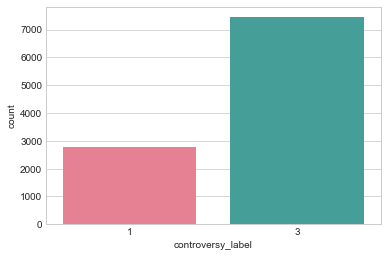

In [425]:

sb.countplot(x='controversy_label', data=train_data, palette='husl')


### Plotting controversy bar chart
* 1 - Weakly- controversial
* 3 - Strongly-controversial

## chi2 on vectorized dataset ( including unigrams and bigrams)
* Term Frequency, Inverse Document Frequency, is used to calculate a tf-idf vector for each of the news statements:
* sublinear_df is set to True to use a logarithmic form for frequency.
* min_df is the minimum numbers of documents a word must be present in to be kept.
* norm is set to l2, to ensure all our feature vectors have a euclidian norm of 1.
* ngram_range is set to (1, 2) to indicate that we want to consider both unigrams and bigrams.
* stop_words is set to "english" to remove all common pronouns ("a", "the", ...) to reduce the number of noisy features.

In [426]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf_vect.fit_transform(train_data.stemmed).toarray()
labels = train_data.label_id
features.shape

(10240, 2960)

Now, each of 10240 statements is represented by 4127 features, representing the tf-idf score for different unigrams and bigrams.

In [427]:
train_data['label'].unique()

array(['false', 'half-true', 'mostly-true', 'true', 'barely-true',
       'pants-fire'], dtype=object)

### Using sklearn.feature_selection.chi2 to find the terms that are the most correlated with each:

In [428]:
from sklearn.feature_selection import chi2
import numpy as np
N = 2
for label, label_id in sorted(label_to_id.items()):
    features_chi2 = chi2(features, labels == label_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf_vect.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(label))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'barely-true':
  . Most correlated unigrams:
. uranium
. bid
  . Most correlated bigrams:
. decid vote
. feder reserv
# 'false':
  . Most correlated unigrams:
. scheme
. debunk
  . Most correlated bigrams:
. kidnap capit
. vice presid
# 'half-true':
  . Most correlated unigrams:
. neutral
. dropout
  . Most correlated bigrams:
. congress pass
. fund educ
# 'mostly-true':
  . Most correlated unigrams:
. owe
. visa
  . Most correlated bigrams:
. turn medicar
. rate world
# 'pants-fire':
  . Most correlated unigrams:
. transact
. socialist
  . Most correlated bigrams:
. voter fraud
. stimulus creat
# 'true':
  . Most correlated unigrams:
. compens
. sever
  . Most correlated bigrams:
. entir economi
. elect state


## A final comparison of Controversy scores
I have used three different approaches for document similarity: This will be used to find the similarity between words in the news statements and the words in the corpus.

* 1. Transform the documents into tf-idf vectors, then compute the cosine similarity between them.
* 2. Applying LDA on the corpus of vocabulary, then using the LDA model to create the vector for each document and compute similarity between the vectors and computing controversy score. 
* 3. Applying LDA on tfidf vectors.
* 4. Applying LSA on the dictionary corpus and then adding the news statements to the LSA model which vectorizes each statement and computes similarity.
* 5. Applying Doc2vec to compare the news statements and compute similarity.


### Based on my visual analysis and comparison with other scores for each news statement, I am getting more accurate score for controversy (document similarity) using Doc2vec . 
LDA TF-IDF model did not perform better, since it calculates score based on frequency of terms appearing in my vocab document.

In [431]:
train_data.keys()

Index(['id', 'label', 'statement', 'text-length', 'label_id', 'filtered_text',
       'stemmed', 'tokenized', 'sentiment_polarity', 'variance_level',
       'LSA_controversy_score', 'cosine_similarity_tfidf',
       'LDA_controversy_score', 'Topic_Keywords', 'Topic_Perc_Contrib',
       'Dominant_Topic', 'Doc2vec_score', 'doc2vec_label', 'controversy_label',
       'sentiment_label'],
      dtype='object')

In [432]:
train_data[['statement','sentiment_polarity', 'cosine_similarity_tfidf','LSA_controversy_score', 'LDA_controversy_score','Doc2vec_score']][:10]

statement sentiment_polarity  \
0  Says the Annies List political group supports ...           positive   
1  When did the decline of coal start? It started...           positive   
2  Hillary Clinton agrees with John McCain "by vo...           positive   
3  Health care reform legislation is likely to ma...           positive   
4  The economic turnaround started at the end of ...            neutral   
5  The Chicago Bears have had more starting quart...           negative   
6  Jim Dunnam has not lived in the district he re...            neutral   
7  I'm the only person on this stage who has work...           positive   
8  However, it took $19.5 million in Oregon Lotte...            neutral   
9  Says GOP primary opponents Glenn Grothman and ...            neutral   

   cosine_similarity_tfidf  LSA_controversy_score  LDA_controversy_score  \
0                 0.032886               0.153393               0.989949   
1                 0.019138               0.153393               0.989949   
2                 0.042062               0.153393               0.989949   
3                 0.069615               0.306786               0.995350   
4                 0.000000               0.000000               0.316228   
5                 0.013375               0.076696               0.964764   
6                 0.000000               0.000000               0.316228   
7                 0.023118               0.076696               0.964764   
8                 0.028944               0.153393               0.989949   
9                 0.056934               0.306786               0.997334   

   Doc2vec_score  
0       0.064119  
1       0.430014  
2       0.377727  
3       0.048968  
4       0.485511  
5       0.513387  
6       0.534896  
7       0.424276  
8       0.143283  
9       0.449415

In [433]:
train_data[['statement','Doc2vec_score','LDA_controversy_score']][:5]

statement  Doc2vec_score  \
0  Says the Annies List political group supports ...       0.064119   
1  When did the decline of coal start? It started...       0.430014   
2  Hillary Clinton agrees with John McCain "by vo...       0.377727   
3  Health care reform legislation is likely to ma...       0.048968   
4  The economic turnaround started at the end of ...       0.485511   

   LDA_controversy_score  
0               0.989949  
1               0.989949  
2               0.989949  
3               0.995350  
4               0.316228

# 3. Ranking

## Rank the articles based on the Controversy scores of each statement.

In [434]:
#train_data['Statement_Controversy_Rank'] = train_data.groupby('id')['LDA_controversy_score'].rank(ascending=False)
train_data['Statement_Controversy_Rank'] = train_data['LDA_controversy_score'].rank(ascending=False)
train_data[['LDA_controversy_score','Statement_Controversy_Rank']][:5]

LDA_controversy_score  Statement_Controversy_Rank
0               0.989949                      3289.5
1               0.989949                      4039.5
2               0.989949                      2216.5
3               0.995350                       746.5
4               0.316228                      8844.0

In [435]:
train_data.sort_values("Statement_Controversy_Rank", inplace = True) 
train_data.head()

id        label                                          statement  \
707    707    half-true  We spend more money on health care per capita ...   
1280  1280  mostly-true  Hospitals, doctors, MRIs, surgeries and so for...   
3986  3986         true  Says the Republican Party platform says pull b...   
7550  7550        false  The vast majority of the money I got was from ...   
6119  6119         true  Georgia has the most restrictive ballot access...   

      text-length  label_id  \
707           286         1   
1280         3192         2   
3986          241         3   
7550         2099         0   
6119         1592         3   

                                          filtered_text  \
707   spend money health care capita country world d...   
1280  hospital doctor mri surgery expensive country ...   
3986  say republican party platform say pull rule ca...   
7550  vast majority money get small donor country ca...   
6119  restrictive ballot access law country election...   

                                                stemmed  \
707   spend money health care capita countri world d...   
1280  hospit doctor mri surgeri expens countri count...   
3986  say republican parti platform say pull rule ca...   
7550  vast major money get small donor countri campa...   
6119  restrict ballot access law countri elect mari ...   

                                              tokenized sentiment_polarity  \
707   [spend, money, health, care, capita, countri, ...           positive   
1280  [hospit, doctor, mri, surgeri, expen, countri,...           positive   
3986  [say, republican, parti, platform, say, pull, ...           positive   
7550  [vast, major, money, get, small, donor, countr...           positive   
6119  [restrict, ballot, access, law, countri, elect...           negative   

      variance_level             ...              cosine_similarity_tfidf  \
707            0.107             ...                             0.083691   
1280           0.008             ...                             0.146066   
3986           0.201             ...                             0.131169   
7550           0.022             ...                             0.098242   
6119           0.036             ...                             0.115292   

      LDA_controversy_score  \
707                     1.0   
1280                    1.0   
3986                    1.0   
7550                    1.0   
6119                    1.0   

                                         Topic_Keywords Topic_Perc_Contrib  \
707   health, care, insurance, tax, plan, state, say...             0.9548   
1280  say, state, nuclear, rhode, island, iran, deal...             0.1823   
3986  say, republican, party, even, democrat, vote, ...             0.3109   
7550  job, scott, say, wisconsin, gov, state, new, c...             0.3738   
6119  obama, barack, president, say, would, obamacar...             0.2012   

      Dominant_Topic  Doc2vec_score  doc2vec_label  controversy_label  \
707                8       0.367817              1                  3   
1280               6       0.038368              0                  3   
3986               3       0.403680              2                  3   
7550               7       0.420217              2                  3   
6119              17       0.029871              0                  3   

      sentiment_label  Statement_Controversy_Rank  
707                 0                         1.0  
1280                0                         2.0  
3986                0                         3.0  
7550                0                         4.0  
6119                2                         5.0  

[5 rows x 21 columns]

# Applying Multi-class Classification Models for predicting Controversy level
* Multinomial Naive Bayes
* Linear SVC
* Support Vector Machine
* Random Forest Classifier


In [436]:
X_train, X_test, y_train, y_test = train_test_split(train_data['stemmed'], train_data['controversy_label'], random_state = 0)

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)


clf = MultinomialNB().fit(X_train_tfidf, y_train)
y_pred = clf.predict(count_vect.transform(X_test))

In [437]:
print(clf.predict(count_vect.transform(["Says when armed civilians stop mass shootings with guns, an average of 2.5 people die; otherwise, an average of 18 people die"])))

[3]


In [438]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7765625


In [439]:
from sklearn.svm import LinearSVC
model_SVC = LinearSVC()
#X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, train_data.index, test_size=0.33, random_state=0)
model_SVC.fit(X_train_tfidf, y_train)
y_pred_SVC = model_SVC.predict(count_vect.transform(X_test))

In [440]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_SVC))

Accuracy: 0.957421875


In [441]:
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(y_test, y_pred))
print('\n')
print(classification_report(y_test, y_pred))

[[ 173  562]
 [  10 1815]]


              precision    recall  f1-score   support

           1       0.95      0.24      0.38       735
           3       0.76      0.99      0.86      1825

   micro avg       0.78      0.78      0.78      2560
   macro avg       0.85      0.61      0.62      2560
weighted avg       0.82      0.78      0.72      2560



In [442]:
from sklearn import svm


clf = svm.SVC(kernel='linear') 

clf.fit(X_train_tfidf, y_train)

y_pred = clf.predict(count_vect.transform(X_test))


from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.953515625


In [443]:
from sklearn.ensemble import RandomForestClassifier
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=7)
clf=RandomForestClassifier(n_estimators=100)

clf.fit(X_train_tfidf,y_train)

y_pred=clf.predict(count_vect.transform(X_test))

from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9609375


In [444]:
label_id_df = train_data[['label', 'label_id']].drop_duplicates().sort_values('label_id')
category_to_id = dict(label_id_df.values)

In [445]:
X_train, X_test, y_train, y_test = train_test_split(train_data['stemmed'], train_data['label'], test_size=0.3, random_state = 42)

In [446]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

my_tags = ['false', 'half-true', 'mostly-true', 'true', 'barely-true',
       'pants-fire']

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(train_data['stemmed'], train_data['label'])


from sklearn.metrics import classification_report
y_pred = nb.predict(test_data['stemmed'])

print('accuracy %s' % accuracy_score(y_pred, test_data['label']))
print(classification_report(test_data['label'], y_pred,target_names=my_tags))

accuracy 0.21862667719021311
              precision    recall  f1-score   support

       false       0.29      0.10      0.15       212
   half-true       0.20      0.24      0.22       249
 mostly-true       0.22      0.46      0.30       265
        true       0.23      0.26      0.25       241
 barely-true       0.50      0.01      0.02        92
  pants-fire       0.12      0.04      0.06       208

   micro avg       0.22      0.22      0.22      1267
   macro avg       0.26      0.19      0.17      1267
weighted avg       0.23      0.22      0.19      1267



# Training multi-label classifiers for predicting labels
## Models suitable for multinomial variant: 
* Logistic Regression
* (Multinomial) Naive Bayes
* Linear Support Vector Machine
* Random Forest

In [447]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
X_train, X_test, y_train, y_test = train_test_split(train_data['stemmed'], train_data['label'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [448]:
print(clf.predict(count_vect.transform(["Says when armed civilians stop mass shootings with guns, an average of 2.5 people die; otherwise, an average of 18 people die"])))

['true']


In [449]:
train_data['polarity_id'] = train_data['sentiment_polarity'].factorize()[0]
train_data['polarity_id'].unique()

array([0, 1, 2])

## Training models using Multinomial naive Bayes, Logistic Regression, RandomForestClassifier and Support Vector Machine to predict labels-

* Logistic Regression: A linear classifier, mostly similar to traditional linear regression, but that fits the output of the logistic function.
* (Multinomial) Naive Bayes: A Bayesian model that assumes total independence between features.  This model works  well with the Bag of Words model, and has notably been used for spam detection.
* Random Forest: Random Forest is the ensembling of a large number of decision trees, each trained on a random subset of the input features. They work well when complex feature-relations are involved and are relatively robust to overfitting.

In [450]:
test_data.shape

(1267, 16)

In [451]:
X = train_data.stemmed
y = train_data.label_id
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
cvec = CountVectorizer(stop_words='english').fit(X_train)
df_train = pd.DataFrame(cvec.transform(X_train).todense(),columns=cvec.get_feature_names())


In [452]:
df_test = pd.DataFrame(cvec.transform(X_test).todense(),columns=cvec.get_feature_names())
print (df_train.shape)
print (y_train.shape)
print (df_test.shape)
print (y_test.shape)

(6860, 4837)
(6860,)
(3380, 4837)
(3380,)


## LogisticRegression with CountVectorizer

In [453]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(df_train,y_train)
lr.score(df_test,y_test)

0.21568047337278107

In [454]:
X = train_data.sentiment_polarity
y = train_data.label_id
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
cvec = CountVectorizer(stop_words='english').fit(X_train)
polarity_train = pd.DataFrame(cvec.transform(X_train).todense(),columns=cvec.get_feature_names())
polarity_test = pd.DataFrame(cvec.transform(X_test).todense(),columns=cvec.get_feature_names())



In [455]:
lr = LogisticRegression()
lr.fit(df_train,y_train)
lr.score(df_test,y_test)

0.19822485207100593

In [456]:
train = pd.concat([df_train,polarity_train], axis = 1)
test = pd.concat([df_test,polarity_test],axis = 1)
print(train.shape)
print(test.shape)
print(y_train.shape)
print(y_test.shape)

(6860, 4840)
(3380, 4840)
(6860,)
(3380,)


In [457]:
lr = LogisticRegression()
lr.fit(train,y_train)
lr.score(test,y_test)

0.1940828402366864

#### So we did not get a good score with CountVectorizer

In [458]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(solver='lbfgs',random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])



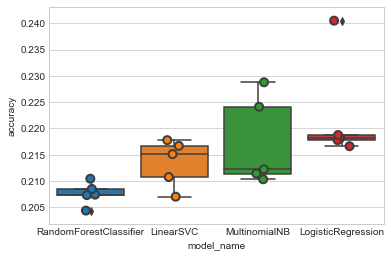

In [459]:
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()



### Multinomial Naive Bayes and Logistic Regression perform better than the other two classifiers.
accuracy=  #correct predictions by #total data points
       

In [460]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.213475
LogisticRegression        0.222358
MultinomialNB             0.217380
RandomForestClassifier    0.207618
Name: accuracy, dtype: float64

### Using LinearSVC model to  print confusion matrix, and see the discrepancies between predicted and actual labels.

In [461]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, train_data.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


In [462]:
print('accuracy %s' % accuracy_score(y_pred, y_test))

accuracy 0.20917159763313609


### I applied the chi-squared test to find the terms that are the most correlated with each of the labels:

In [463]:
model.fit(features, labels)
N = 2
for label, label_id in sorted(label_to_id.items()):
    indices = np.argsort(model.coef_[label_id])
    feature_names = np.array(tfidf_vect.get_feature_names())[indices]
    unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
    bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
    print("# '{}':".format(label))
    print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
    print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

# 'barely-true':
  . Top unigrams:
       . bid
       . mention
  . Top bigrams:
       . feder reserv
       . pay woman
# 'false':
  . Top unigrams:
       . debunk
       . destroy
  . Top bigrams:
       . trade plan
       . court nomine
# 'half-true':
  . Top unigrams:
       . mammogram
       . film
  . Top bigrams:
       . congress pass
       . money spend
# 'mostly-true':
  . Top unigrams:
       . gunfir
       . transfer
  . Top bigrams:
       . employ mandat
       . pay nation
# 'pants-fire':
  . Top unigrams:
       . transact
       . blue
  . Top bigrams:
       . stimulus creat
       . school spend
# 'true':
  . Top unigrams:
       . compens
       . sever
  . Top bigrams:
       . flop abort
       . obama say


### The classification report for each class:

In [464]:
from sklearn import metrics
print(confusion_matrix(y_test, y_pred))
print('\n')
print(metrics.classification_report(y_test, y_pred, target_names=train_data['label'].unique()))

[[166 121 131 105  90  47]
 [160 166 150  86 105  39]
 [112 140 162 113  78  32]
 [125 108 137  89  76  19]
 [108 139  98  90  86  32]
 [ 57  48  42  38  47  38]]


              precision    recall  f1-score   support

   half-true       0.23      0.25      0.24       660
 mostly-true       0.23      0.24      0.23       706
        true       0.23      0.25      0.24       637
       false       0.17      0.16      0.17       554
  pants-fire       0.18      0.16      0.17       553
 barely-true       0.18      0.14      0.16       270

   micro avg       0.21      0.21      0.21      3380
   macro avg       0.20      0.20      0.20      3380
weighted avg       0.21      0.21      0.21      3380



### Applying CountVectorizer to fit the training statements and apply Multinomial Naive Bayes to see if there is any marginal increase in accuracy

In [468]:
bow_transformer = CountVectorizer(analyzer=text_process).fit(train_data['stemmed'])

In [469]:
review_5 = train_data['statement'][4]
review_5

'The economic turnaround started at the end of my term.'

In [470]:
bow_5 = bow_transformer.transform([review_5])
print(bow_5)

  (0, 1668)	1
  (0, 5187)	1
  (0, 5386)	1


In [471]:
X = bow_transformer.transform(train_data['stemmed'])

In [472]:
X_test = bow_transformer.transform(test_data['stemmed'])

In [473]:
print('Shape of Sparse Matrix: ', X.shape)
print('Amount of Non-Zero occurrences: ', X.nnz)
# Percentage of non-zero values
density = (100.0 * X.nnz / (X.shape[0] * X.shape[1]))
print('Density: {}'.format((density)))

Shape of Sparse Matrix:  (10240, 5836)
Amount of Non-Zero occurrences:  71115
Density: 0.11899972958790267


In [474]:
from sklearn.model_selection import train_test_split


In [475]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X, train_data['label'])

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [476]:
preds = nb.predict(X_test)

In [477]:
y_test = test_data['label']

In [478]:
print('accuracy %s' % accuracy_score(preds, y_test))

accuracy 0.22336227308603


In [479]:
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(y_test, preds))
print('\n')
print(classification_report(y_test, preds))

[[41 60 57 36  3 15]
 [33 56 81 48  7 24]
 [37 44 97 62  5 20]
 [30 37 74 63  1 36]
 [15 30 20 13  2 12]
 [22 43 61 53  5 24]]


              precision    recall  f1-score   support

 barely-true       0.23      0.19      0.21       212
       false       0.21      0.22      0.22       249
   half-true       0.25      0.37      0.30       265
 mostly-true       0.23      0.26      0.24       241
  pants-fire       0.09      0.02      0.03        92
        true       0.18      0.12      0.14       208

   micro avg       0.22      0.22      0.22      1267
   macro avg       0.20      0.20      0.19      1267
weighted avg       0.21      0.22      0.21      1267



### The model accuracy is not great, so it has to be improved by boosting or ensemble methods, and adding more features to train the model and using pipeline


# To improve the model accuracy applied-
* # Bagging 
* # Boosting  
* # Ensemble methods for Doc2vec model 

## Logistic Regression:
Genreally Logistic Regression is used for Binary classifications (Sigmoid function gives probability of the two classes betweetn 0 and 1. For Multiclass predictions it works on different method like first predicting for two classes and then for other. 
Pros & Cons:
In Multiclass Classifications its accuracy might be low when compared to other algorithms which is also seen below. But being a simple algorithm it is compuationally faster and faster to tune by hyper parameters

In [480]:
df_train_statements=train_data[['stemmed','label']]
model= Doc2Vec.load("doc2vec_model")
texts=[]
for x in df_train_statements['stemmed']:
    texts.append(model.infer_vector(x))

In [481]:
def replace_label(x):
    if (x == 'true' or x=='mostly-true' or x=='half-true'):
        return 1
    else:
        return 0
replace_label('true')

1

In [482]:
X=pd.DataFrame(texts)
y=df_train_statements['label'].map(lambda x:replace_label(x))
X_train,X_test,y_train,y_test=train_test_split(X, y,test_size = .3, random_state = 1)

In [483]:
from sklearn.linear_model import LogisticRegression
logReg = LogisticRegression(C=100)
logReg.fit(X_train, y_train)
log_pred = logReg.predict(X_test)
import pickle
s = pickle.dumps(logReg)

In [484]:
from sklearn import metrics
print(metrics.classification_report(y_test,log_pred))

              precision    recall  f1-score   support

           0       0.42      0.01      0.02      1375
           1       0.55      0.99      0.71      1697

   micro avg       0.55      0.55      0.55      3072
   macro avg       0.49      0.50      0.37      3072
weighted avg       0.50      0.55      0.40      3072



In [485]:
from sklearn.metrics import accuracy_score, f1_score

print('Testing accuracy %s' % accuracy_score(y_test, log_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, log_pred, average='weighted')))

Testing accuracy 0.5504557291666666
Testing F1 score: 0.4018448896822939


## Support Vector Machine with Doc2vec model

In [486]:
from sklearn.svm import SVC

In [487]:
modelSVC = LinearSVC()
modelSVC.fit(X_train, y_train)
svc_pred = modelSVC.predict(X_test)
s = pickle.dumps(modelSVC)

In [488]:
classifier_conf = SVC(kernel='linear', probability=True)
classifier_conf.fit(X_train, y_train)



SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [489]:
from sklearn.metrics import accuracy_score, f1_score

print('Testing accuracy %s' % accuracy_score(y_test, svc_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, svc_pred, average='weighted')))

Testing accuracy 0.5514322916666666
Testing F1 score: 0.40010276874316303


In [490]:
df_train_statements.label.unique()

array(['half-true', 'mostly-true', 'true', 'false', 'pants-fire',
       'barely-true'], dtype=object)

## KNeighborsClassifier:
K Nearest Neighbors classifies Data by finding the nearest data points to it measured by a distance function and then it assigns to the class which is most common amongst its K nearest neighbors

Pros & Cons:
Since it works on similaity measures it can Easily handle multi-class cases, hence this model is selected.

Since there is No generalization in this Algorithm so the Accuracy of model totally depends on the Accuracy, In our case since we have a good Training set we acheived a good accuracy of 51%

In [491]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=10)

In [492]:
knn_scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
print('The accuracy of the knn classifier with 10 fold cross-validation is ' + str(knn_scores.mean()))

The accuracy of the knn classifier with 10 fold cross-validation is 0.5025081374147623


In [493]:
print(knn_scores)

[0.49303621 0.52089136 0.52367688 0.47140865 0.49511855 0.51536313
 0.52234637 0.5        0.49441341 0.48882682]


In [494]:
knn_cv_mean = np.mean(knn_scores)
knn_cv_variance = np.var(knn_scores)

print('Knn Mean score : ', knn_cv_mean)
print('Knn Score variance : ', knn_cv_variance)

Knn Mean score :  0.5025081374147623
Knn Score variance :  0.00027153605890058413


## Random Forest: (Ensemble - bagging)
Since I was unable to acheive good accuracies by normal Models I opted to use Ensembles, A Bootstrap method. Especially in Random forest, it is a Bagging Model and it works by changing the algorithm for the way that the sub-trees are learned so that the resulting predictions from all of the subtrees have less correlation and overall accuracy is high

Pros & Cons:
Advantage of this method is we can acheive higher accuracies, but It can also lead to overfitting of the Model which needs to be taken care. Also, Random Forest can handle Missing values, although we repleaced missing values in our case, This Model can be used even with missing values

In [495]:
forest = RandomForestClassifier()
forest_scores = cross_val_score(forest, X_train, y_train, cv=10, scoring='accuracy')
print('The accuracy of the Random forest classifier with 10 fold cross-validation is ' + str(forest_scores.mean()))

The accuracy of the Random forest classifier with 10 fold cross-validation is 0.5160427732423237


In [496]:
print(forest_scores)

[0.53342618 0.53342618 0.48607242 0.52440725 0.50348675 0.52653631
 0.51815642 0.5027933  0.51256983 0.51955307]


In [497]:

forest_cv_mean = np.mean(forest_scores)
forest_cv_variance = np.var(forest_scores)

print('forest Mean score : ', forest_cv_mean)
print('forest Score variance : ', forest_cv_variance)

forest Mean score :  0.5160427732423237
forest Score variance :  0.00020447200813592022



### Gradient Boost: (Ensemble - Boosting)
It is a similar ensemble algorithm like Random forest, But it works in a iterative manner by selecting and creating one tree after another. In random forest all Decision trees are simultaneously perfomed. But here, We select featues of next iteration tree based on the Error rate and Feature importance obtained in one step

Pros & Cons:
Both Bias and Variance can be adjusted by doing hyper paramter tuning in this Ensemble method. So it gives us more flexibilty for tuning the Model and create Bias variance Tradeoff

In [498]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier()

In [499]:
start_gb = time.time()

gb_scores = cross_val_score(gb, X, y, cv=10, scoring='accuracy')
print('The accuracy of the Random forest classifier with 10 fold cross-validation is ' + str(gb_scores.mean()))

end_gb =time.time()
gb_time = (end_gb-start_gb)/60
print('The time taken for the classifier for 10 fold cross validation is ' + str(gb_time))

The accuracy of the Random forest classifier with 10 fold cross-validation is 0.550882452636614
The time taken for the classifier for 10 fold cross validation is 0.3253441492716471


### The accuracy increased to 55% with GradientBoosting

## Feature Importance:
Univariate feature selection:
This method works by selecting the best features based on univariate statistical tests. It performs chi2 test for different categorical Values to get the Feature weights as done below.

In [500]:
feature_names = train_data.columns # e.g. ['A', 'B', 'C', 'D', 'E']
#plt.xticks(range(heart_train.shape[1]), feature_names)

In [501]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

1. feature 4 (0.055953)
2. feature 16 (0.055037)
3. feature 6 (0.052049)
4. feature 9 (0.051929)
5. feature 18 (0.051144)
6. feature 3 (0.050599)
7. feature 17 (0.050112)
8. feature 10 (0.049907)
9. feature 2 (0.049797)
10. feature 11 (0.049761)
11. feature 8 (0.049710)
12. feature 13 (0.049620)
13. feature 7 (0.048924)
14. feature 0 (0.048822)
15. feature 5 (0.048581)
16. feature 15 (0.048543)
17. feature 12 (0.048450)
18. feature 14 (0.048390)
19. feature 19 (0.047523)
20. feature 1 (0.045149)


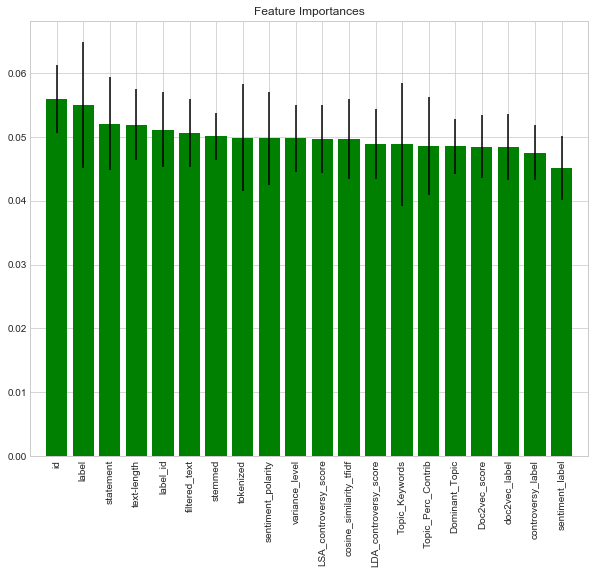

In [502]:
rcf = RandomForestClassifier()      
rcf = rcf.fit(X,y)
importances = rcf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rcf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest

plt.figure(1, figsize=(10, 8))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], color="g", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), feature_names, rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

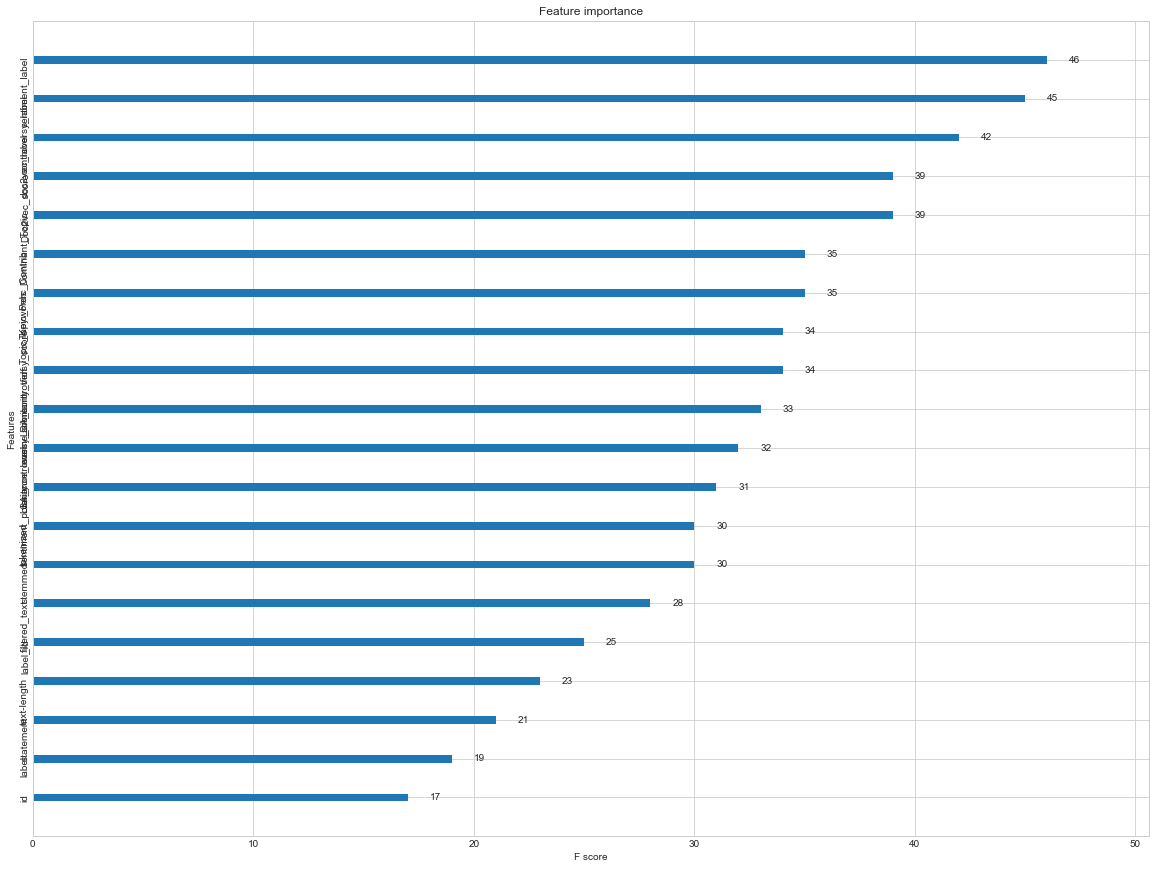

In [505]:

# plot feature importance using built-in function
from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot

# fit model no training data
model = XGBClassifier()
model.fit(X, y)


plot_importance(model)
pyplot.rcParams['figure.figsize'] = [20, 15]
pyplot.yticks(range(X.shape[1]), feature_names, rotation=90)
pyplot.show()

In [506]:
from sklearn.naive_bayes import GaussianNB
from sklearn import model_selection
seed = 7

LR: 0.560937 (0.013895)
KNN: 0.510352 (0.014773)
DTree: 0.497949 (0.009351)
NB: 0.550098 (0.012978)
SVM: 0.561719 (0.014411)


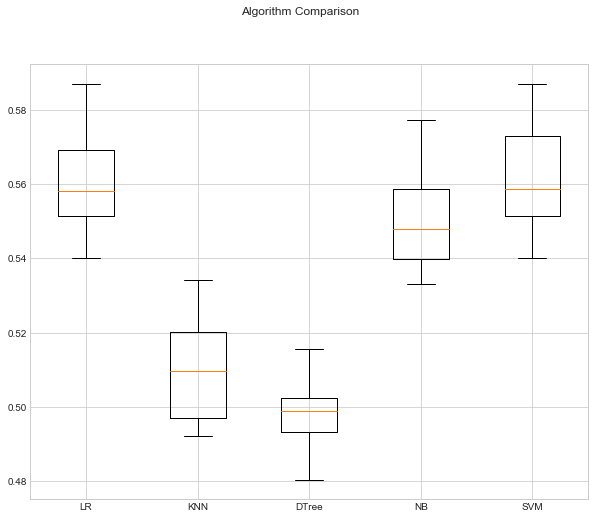

In [507]:
models = []
models.append(('LR', LogisticRegression(solver='lbfgs')))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DTree', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
	kfold = model_selection.KFold(n_splits=10, random_state=seed)
	cv_results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
# boxplot algorithm comparison
fig = plt.figure(1, figsize=(10, 8))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

## Got better accuracy using Logistic Regression and Support Vector Machine

### Hence, these models can be used to predict Controversy factor in news statements

## Controversy Factor Calculator

In [508]:
def controversy_factor_calculator(news):
    data_pred=[]
    data_pred.append(model.infer_vector(news))
    lrg_pa = pickle.loads(s)
    pred_conf=lrg_pa.predict_proba(data_pred)
    return pred_conf[0][1]

In [509]:
class ControversyPredictor:
    def __init__(self,news):
        self.news=news
    def predict(self):
        return controversy_checker(self.news)

In [510]:
df_train_statements['stemmed'][0]

'say anni list polit group support trimest abort demand'

In [ ]:
controversy_factor_calculator("say anni list polit group support trimest abort demand")

In [ ]:
max_accuracy_sensationalism = 0
max_accuracy_political_affiliation = 0
dict_threshold = {}
threshold_list = []
accuracy_list = []
X_train = train_df[['sensational_value','variation']]
y_train = train_df['label_value']
X_test = test_data[['sensational_actual','variation']]
y_test = test_data['label_value']
for thresholdsen in np.linspace(0,1,1000):
  
    #cv.fit(train_df['sensational_value'])
    #text_counts_test = cv.transform(test_data['sensational_actual'])
 
   
# Model Generation Using Multinomial Naive Bayes
    clf=RandomForestClassifier(n_estimators=100)

    clf.fit(X_train,y_train)

    y_pred=clf.predict(X_test)

    
    accuracy = metrics.accuracy_score(y_test, y_pred)
   
    threshold_list.append(thresholdsen)
    accuracy_list.append(accuracy)
    if accuracy > max_accuracy_controversy:
        max_accuracy_controversy = accuracy
        max_threshold_controversy = thresholdsen
print("Max_accuracy",max_accuracy_controversy)
print("Max_threshold",max_threshold_controversy)

### The Threshold and accuracy value will be passed to the final equation 

# Word2vec and T-Sne plot visualization

The Word to Vec model produces a vocabulary, with each word being represented by an n-dimensional numpy array (100 values in this case)

In [242]:
from gensim.models import word2vec
model = word2vec.Word2Vec(train_data['tokenized'], size=100, window=20, min_count=200, workers=4)
model.wv['say']

array([ 8.97732228e-02, -9.12332833e-02, -5.70640014e-03, -1.82182312e-01,
        4.01998162e-01, -1.07914926e-02,  2.70699650e-01,  8.71922597e-02,
       -2.66931385e-01, -4.72861528e-02, -2.00947165e-01,  1.14800274e-01,
        2.09195483e-02, -7.06674531e-03, -1.52910665e-01,  3.64686251e-02,
       -6.84501894e-04, -3.07149172e-01, -1.51863009e-01, -8.90646502e-02,
       -1.19121052e-01, -8.47933888e-02, -1.01475313e-01,  5.47171310e-02,
        1.97236821e-01,  1.07309468e-01, -1.47122324e-01,  1.32463008e-01,
       -6.99108541e-02, -1.02845915e-01,  2.11873546e-01, -2.11320221e-01,
        1.27085224e-01, -1.24198847e-01,  1.14950694e-01, -1.81139503e-02,
        3.07633523e-02,  5.71780056e-02,  3.93046886e-02, -2.14588001e-01,
        2.01966971e-01,  6.12944476e-02, -7.84085467e-02, -5.49449325e-02,
       -1.55607462e-01, -9.81183797e-02,  2.02765882e-01,  1.90251693e-02,
        3.48017435e-03, -2.67724305e-01,  3.51930678e-01,  3.30799401e-01,
       -7.53125781e-03,  

### T-sne plot visualization 

In [244]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

def tsne_plot(model):
    "Creates a TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

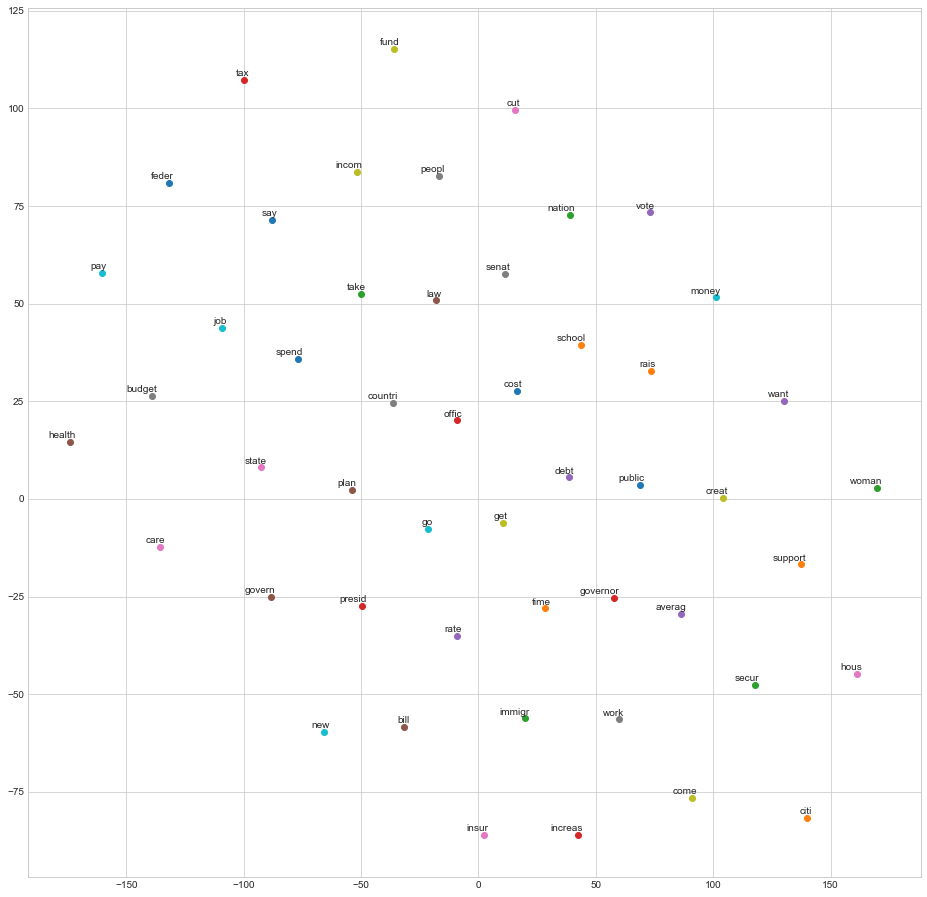

In [245]:
tsne_plot(model)

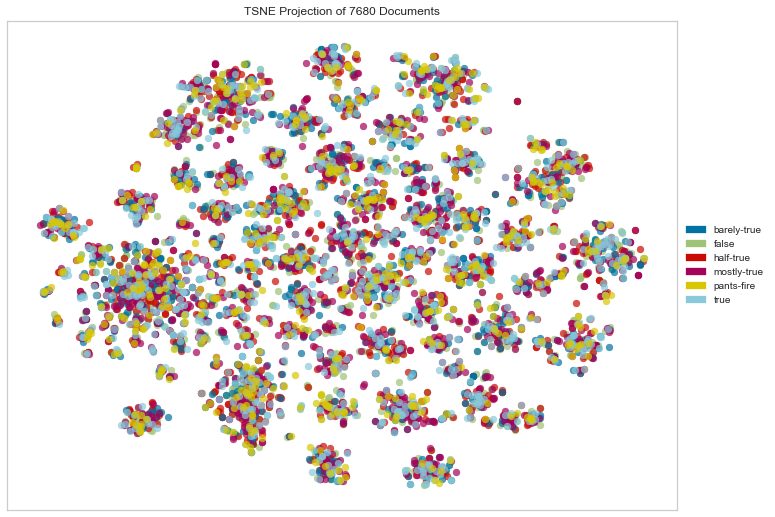

In [247]:
# Create the visualizer and draw the vectors
from yellowbrick.text import TSNEVisualizer
plt.figure(figsize = [15,9])
tsne = TSNEVisualizer()
tsne.fit(X_train_tfidf, y_train)
tsne.poof()

* ### T-Sne projection of documents
#### We can clearly see that different articles categories are almost overlapping, which means that we cannot expect highly accurate classification performance.

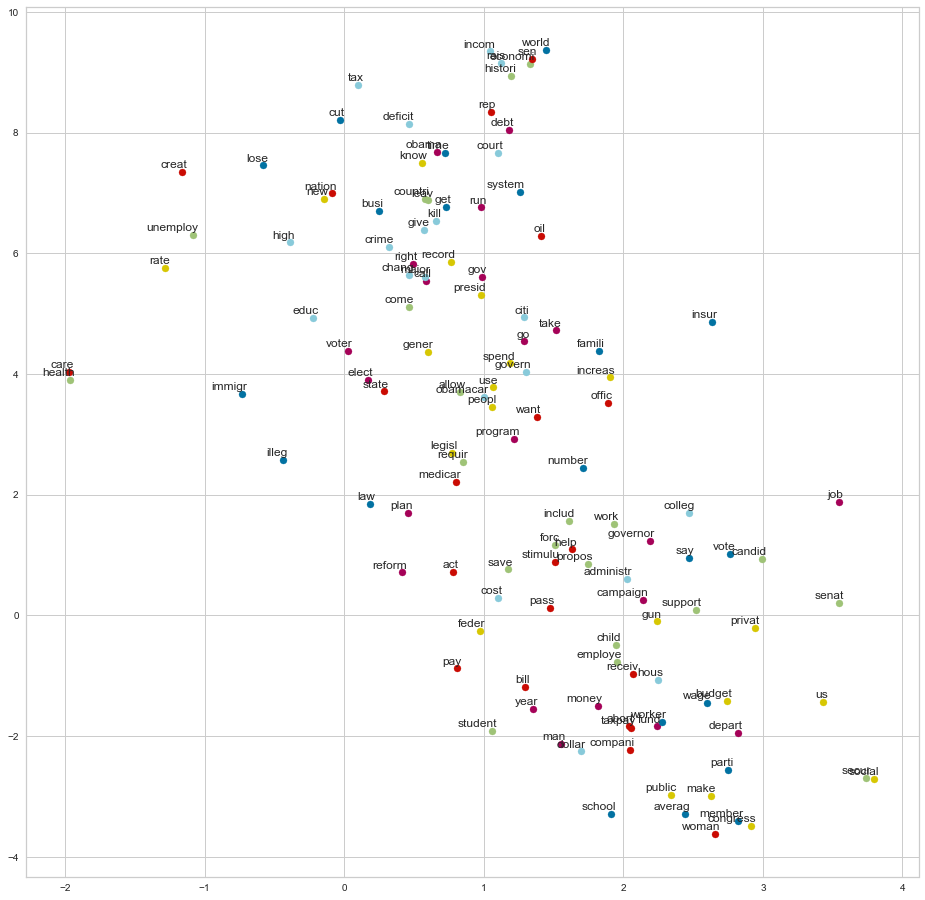

In [248]:
## A less selective model
model = word2vec.Word2Vec(train_data['tokenized'], size=100, window=20, min_count=100, workers=4)
tsne_plot(model)

#### Similar words are grouped together in the plot
#### t-SNE keeps nearby points in the high-dimensional space close to each other in the projected space.

In [251]:
model.most_similar('obama')

/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('forc', 0.9996665716171265),
 ('economi', 0.9996423721313477),
 ('help', 0.9996415972709656),
 ('presid', 0.9996177554130554),
 ('gov', 0.9996035099029541),
 ('use', 0.9995977878570557),
 ('time', 0.9995973706245422),
 ('give', 0.9995932579040527),
 ('leav', 0.9995921850204468),
 ('know', 0.999589204788208)]

In [252]:
model.most_similar('dollar')

/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('pay', 0.9995484352111816),
 ('year', 0.9995269775390625),
 ('obama', 0.9995247721672058),
 ('averag', 0.9995197057723999),
 ('man', 0.9995188117027283),
 ('work', 0.9995168447494507),
 ('save', 0.9995145201683044),
 ('famili', 0.9995079040527344),
 ('receiv', 0.9994833469390869),
 ('help', 0.9994813799858093)]

In [1278]:
cols_of_interest = ['Doc2vec_score','variance_level']

X_doc = train_data[cols_of_interest]
y = train_data['label']
#X_doc

In [1281]:
train_data_contro = train_data.head(1000)

## Export the following columns for common equation calculation

In [1287]:
# import pandas
# import csv

header = ['Doc2vec_score', 'variance_level','label_id']
train_data_contro.to_csv('output_contro.csv', columns = header )

## Conclusion - 

#### Enriched dataset with following columns - 
* Sentiment_polarity - Using Vader Library. To detect sentiment-loaded language on news articles. I calculated the frequencies of negative/neutral/positive words for each article and use these as input for classifiers. Then, used the algorithm to train the emotion • polarity classifier (EP), using both the annotations and sentiment measures. I computed variance level by fiidng the differnce of positive and negative words.
* cosine_similarity_tfidf- When the documents are similar to the controversy vocabulary, it would imply that the statement is more controversial. The model accuracy was not great.
* LSA_controversy_score - The use of the LSA model shows a noticeable quality improvement compared to the use of the tfidf model.
* LDA_controversy_score - model implemented to capture the distribution of topics among news documents. I performed manual evaluations in order to understand the accuracy in similarity scores of the above Topic Models. ( LDA seems to be better than other scores)
* Doc2vec - After iplementing doc2vec model for analyzing the similarity between the controversial documents and news statements, I could analyse that Doc2vec peformed better than other models.

##### Applied following Distillation methods- 

* Sentiment Analysis
* Part of Speech Tagging
* Doc2vec
* LDA
* LSA
* Ranking


##### Applied following multiclass classification models-
* Logistic Regression 
* (Multinomial) Naive Bayes
* Support Vector Machine
* Random Forest models 
* K-nearest Neighbors
* Gradient Boosting

#### Accuracy scores
* Logistic Regression: 0.561816 
* KNearestNeighbor: 0.515918
* DecisionTree: 0.504785 
* NaiveBayes: 0.552344 
* SupportVectorMachine: 0.561719

### Logistic Regression and SVM gave higher accuracy scores

### Applied Doc2vec model for predicting Controversy level in news statements
Controversy score was computed by applying Doc2Vec, LDA, BOW and cosine similarity. The model was trained using Random Forest Classifier, which provided threshold as 0.27 and maximum accuracy as 0.51.

The final model is trained to predict the degree of controversy feature in the news statement and its corresponding weightage using the following method-
* A Random Classifier was built to find the weightage of each factor.
* A for loop iterates between 0 and 1 to pick the best possible threshold that would give the maximum accuracy for each factor.
* For each factor the model was trained with the factor score and label value in the dataset

Further Calculations for each factor have been performed at the Final section of the notebook. 


### References -
* https://msuweb.montclair.edu/~feldmana/publications/paper_64.pdf
* https://fzr72725.github.io/2018/01/14/genism-guide.html
* https://www.ijcai.org/proceedings/2017/0583.pdf
* https://medium.com/scaleabout/a-gentle-introduction-to-doc2vec-db3e8c0cce5e
* http://maroo.cs.umass.edu/getpdf.php?id=1118
* http://ijarcsse.com/Before_August_2017/docs/papers/Volume_7/4_April2017/V7I4-0124.pdf
* http://aclweb.org/anthology/N18-1171
* https://www.onlinejournal.in/IJIRV3I2/230.pdf
* https://petsymposium.org/2017/papers/issue1/paper06-2017-1-source.pdf
* https://nlp.stanford.edu/pubs/prabhakaran2016wiki.pdf
* https://dataskunkworks.com/2018/06/06/extracting-topics-from-11000-newsgroups-posts-with-python-gensim-and-lda/